# Project: Communicate Data Findings
By: Christoph Lindstädt
## Table of Contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#questions">Posing Questions</a></li>
    <li><a href="#sources">Data Sources</a></li>
    <li><a href="#gathering">Data Gathering & Wrangling</a></li>
    <li><a href="#assessing">Data Assessing</a></li>
    <ul>
        <li><a href="#assessingsum">Assessing Summary</a></li>            
    </ul>    
    <li><a href="#cleaning">Data Cleaning</a></li>
    <li><a href="#analysis">Data Visualization</a></li>
    <ul>
        <li><a href="#uni">Univariate Exploration</a></li>
        <li><a href="#bi">Bivariate Exploration</a></li>
        <li><a href="#multi">Multivariate Exploration</a></li> 
    </ul> 
    <li><a href="#conclusion">Summary and Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

<a id='questions'></a>
## Posing Questions

The following analysis will take a look on the following questions:
><ol>
>    <li><p>Q1</p></li>     
>    <li><p>Q2</p></li>     
></ol>

<a id='sources'></a>
## Data Sources

>1. **Name:** result.csv
><ul>   
>    <li><b>Definition:</b> Ford GoBike System - Data</li>
>    <li><b>Source:</b> <a href ="https://www.fordgobike.com/system-data">https://www.fordgobike.com/system-data</a></li>    
>    <li><b>Version:</b>Files from 01.2018 - 02.2019</li>
></ul>


#### Import of the needed libraries:

In [2]:
#Import important libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import zipfile
import requests
import geopy.distance
from sklearn.cluster import KMeans

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='gathering'></a>
## Data Gathering & Wrangling

At first we need to gather the data. The code below will download, unzip and merge the data together to a final *.csv file.

In [ ]:
#define filenames to download
year_data = [x for x in range(201801, 201813)] + [x for x in range(201901, 201903)]

#loop over years
for year in year_data[:3]:
    
    #url structure
    url = f"https://s3.amazonaws.com/fordgobike-data/{year}-fordgobike-tripdata.csv.zip"
    
    #get response
    response = requests.get(url)
   
    #save file
    with open(f"{year}-fordgobike-tripdata.csv.zip", mode = "wb") as file:
        file.write(response.content)

In [ ]:
#https://stackoverflow.com/questions/3451111/unzipping-files-in-python/3451150
#define file names
files = [x for x in os.walk("./Data")][0][2]

#loop over file names
for x in files:
    if ".zip" in x:
        with zipfile.ZipFile(f"./Data/{x}",'r') as zip_ref:
            zip_ref.extractall("./Data")

In [ ]:
month_range =  [int(x[:6]) for x in files if ".zip" not in x] #can be exchanged with year_data .. 

#read in the first file
result = pd.read_csv(f"./Data/{month_range[0]}-fordgobike-tripdata.csv")
len_df = len(result)

#loop over all files and append data one by one
for i, month in enumerate(month_range):
    
    if i+2 > len(month_range):
        break
    
    else:    
        df_append  = pd.read_csv(f"./Data/{month_range[i+1]}-fordgobike-tripdata.csv")
        len_df += len(df_append)
        assert all(result.columns == df_append.columns)
        result = result.append(df_append)
        print(f"{month_range[i+1]}")
        
result.to_csv("result.csv", index = False)
print("Done")           
print(len_df == len(result))
del len_df, df_append, result, files, month_range

<a id='assessing'></a>
## Data Assessing

Now that we have our final "result.csv" file, we have to make sure, that the data is ready for an analysis. Therefore we have to assess the data. 

In [278]:
df = pd.read_csv("result.csv")

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239215 entries, 0 to 2239214
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 273.3+ MB


Here we already can see, that the start_time and end_time column is no datetime - object. Also the ID's and the member_birth_year should be object type.

In [312]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,75284,2018-01-31 22:52:35.2390,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,1986.0,Male,No
1,85422,2018-01-31 16:13:34.3510,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,NaN,NaN,No
2,71576,2018-01-31 14:23:55.8890,2018-02-01 10:16:52.1160,304.0,Jackson St at 5th St,37.348759,-121.894798,296.0,5th St at Virginia St,37.325998,-121.877120,3039,Customer,1996.0,Male,No
3,61076,2018-01-31 14:53:23.5620,2018-02-01 07:51:20.5000,75.0,Market St at Franklin St,37.773793,-122.421239,47.0,4th St at Harrison St,37.780955,-122.399749,321,Customer,NaN,NaN,No
4,39966,2018-01-31 19:52:24.6670,2018-02-01 06:58:31.0530,74.0,Laguna St at Hayes St,37.776435,-122.426244,19.0,Post St at Kearny St,37.788975,-122.403452,617,Subscriber,1991.0,Male,No


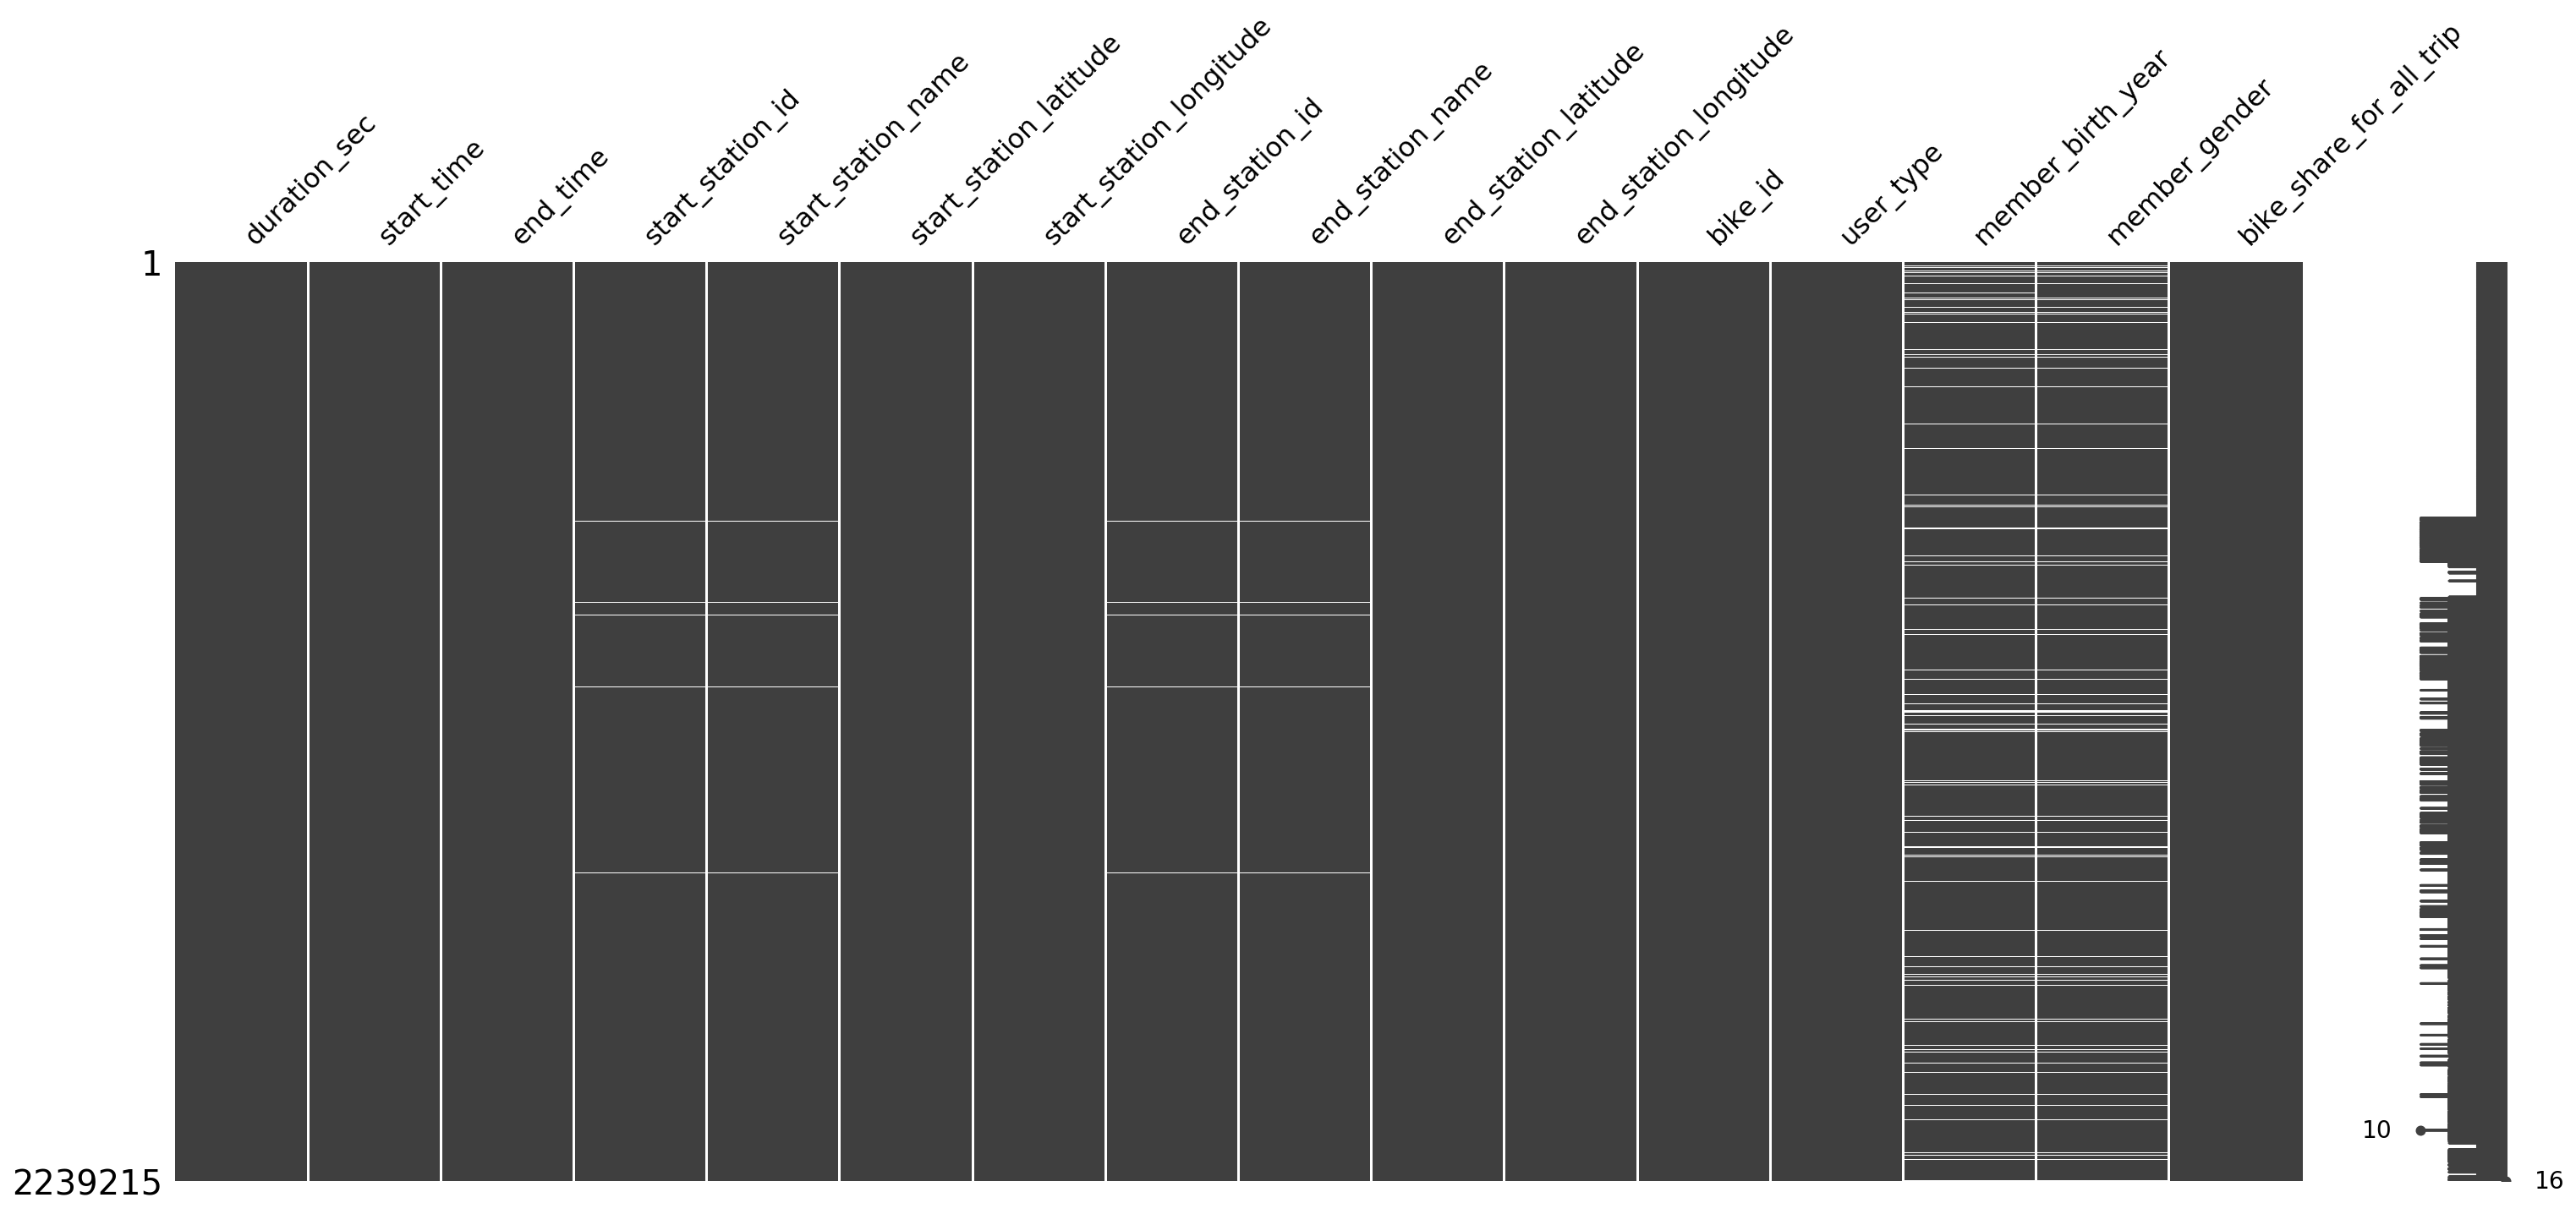

In [313]:
ms.matrix(df);

It seems that we also have a small problem with missing data.

In [314]:
df[df.start_station_id.isnull()].head(10)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
623364,5572,2018-06-30 20:58:31.8550,2018-06-30 22:31:24.5930,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4202,Customer,1989.0,Male,No
623376,573,2018-06-30 22:12:27.5110,2018-06-30 22:22:01.1740,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.93,4095,Subscriber,1994.0,Male,Yes
623393,850,2018-06-30 22:01:25.5850,2018-06-30 22:15:36.1510,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.95,4122,Customer,1990.0,Male,No
623429,562,2018-06-30 21:52:05.1180,2018-06-30 22:01:27.4400,NaN,NaN,37.41,-121.94,NaN,NaN,37.42,-121.94,4184,Subscriber,1989.0,Male,No
623456,819,2018-06-30 21:37:34.5060,2018-06-30 21:51:13.7290,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.96,4137,Customer,1985.0,Male,No
623472,1176,2018-06-30 21:23:30.4880,2018-06-30 21:43:07.3310,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.94,4152,Customer,1961.0,Male,No
623479,160,2018-06-30 21:37:50.9260,2018-06-30 21:40:30.9300,NaN,NaN,37.41,-121.94,NaN,NaN,37.42,-121.94,4105,Subscriber,1990.0,Female,No
623548,7242,2018-06-30 19:19:19.5600,2018-06-30 21:20:02.1110,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4082,Customer,1990.0,Male,No
623549,725,2018-06-30 21:06:44.3580,2018-06-30 21:18:50.2180,NaN,NaN,37.41,-121.96,NaN,NaN,37.41,-121.96,4156,Customer,1983.0,Male,No
623550,694,2018-06-30 21:05:49.6180,2018-06-30 21:17:24.2670,NaN,NaN,37.40,-121.93,NaN,NaN,37.41,-121.94,4136,Customer,1987.0,Female,No


In [315]:
df[df.start_station_id.isnull()].tail(10)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
2211273,984,2019-02-06 08:39:02.6480,2019-02-06 08:55:26.6830,NaN,NaN,37.41,-121.94,NaN,NaN,37.40,-121.92,4249,Subscriber,1976.0,Male,No
2217203,1159,2019-02-05 14:53:30.4310,2019-02-05 15:12:49.4460,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4174,Customer,1986.0,Male,No
2217647,823,2019-02-05 13:28:05.5940,2019-02-05 13:41:49.3090,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.96,4092,Subscriber,1999.0,Male,No
2228284,3791,2019-02-03 14:53:55.9470,2019-02-03 15:57:07.0860,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4174,Subscriber,1977.0,Male,No
2230610,8209,2019-02-02 14:26:59.9650,2019-02-02 16:43:49.5180,NaN,NaN,37.40,-121.93,NaN,NaN,37.41,-121.94,4249,Subscriber,1993.0,Male,Yes
2231957,1447,2019-02-02 12:03:04.5440,2019-02-02 12:27:12.2670,NaN,NaN,37.40,-121.93,NaN,NaN,37.40,-121.93,4249,Customer,1984.0,Male,No
2235533,309,2019-02-01 12:59:45.9690,2019-02-01 13:04:55.4260,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.93,4249,Customer,1987.0,Female,No
2235773,659,2019-02-01 12:17:37.6750,2019-02-01 12:28:37.0140,NaN,NaN,37.41,-121.96,NaN,NaN,37.41,-121.94,4092,Subscriber,1999.0,Female,No
2235909,2013,2019-02-01 11:33:55.1470,2019-02-01 12:07:28.9400,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4251,Customer,1990.0,Female,No
2237004,312,2019-02-01 09:26:34.8030,2019-02-01 09:31:46.9210,NaN,NaN,37.40,-121.93,NaN,NaN,37.40,-121.93,4208,Subscriber,1987.0,Male,No


All the rows with missing data have similar coordinates, which is suspicous. Also These coordinates are less precise than the other entries with none missing data.

In [316]:
df[df.start_station_id.isnull()].start_station_latitude.value_counts()

37.41    5017
37.40    4575
37.42    1233
37.39     843
37.38     412
37.34      37
37.43      23
37.37      17
37.35      17
37.33      17
37.36       8
45.51       4
40.66       3
37.44       3
37.32       2
44.95       2
45.50       2
37.45       1
Name: start_station_latitude, dtype: int64

In [317]:
df[df.start_station_id.isnull()].start_station_longitude.value_counts()

-121.94    4189
-121.93    2915
-121.96    2024
-121.95    1607
-121.92    1278
-121.97      52
-121.91      41
-121.98      33
-121.90      25
-121.89      21
-121.88       8
-73.57        6
-121.87       4
-121.84       3
-74.01        3
-121.86       3
-93.22        2
-121.83       1
-121.99       1
Name: start_station_longitude, dtype: int64

The most frequent coordinates are 37.41 latitude and -121.94 longitude. This is worth to investigate further. 

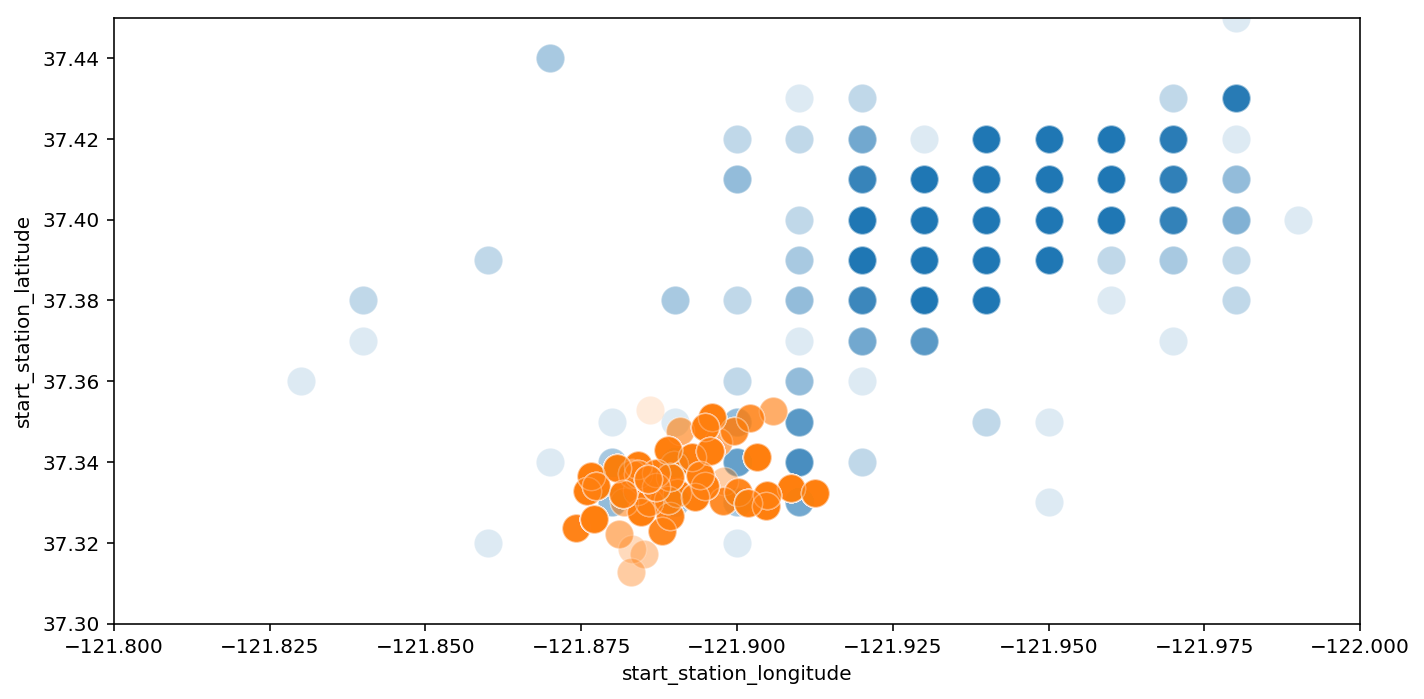

In [322]:
axes, figure = plt.subplots(figsize = (10,5))
sns.scatterplot(data = df[df.start_station_id.isnull()], x = "start_station_longitude", y = "start_station_latitude", alpha = 0.15, s = 200)
sns.scatterplot(data = df.dropna(subset=["start_station_id"]).sample(50000), x = "start_station_longitude", y = "start_station_latitude", alpha = 0.15, s = 200)
plt.xlim(-121.8,-122)
plt.ylim(37.3,37.45)
plt.tight_layout()

By plotting we can see, that these stations are mostly out of the scope of the other stations. Let's take a look on all the stations in this dataset.

In [318]:
#all ids are a start- and ending point
start_station_id_list = list(df.start_station_id.drop_duplicates().dropna().astype("int"))
start_station_id_list.sort()

end_station_id_list = list(df.end_station_id.drop_duplicates().dropna().astype("int"))
end_station_id_list.sort()

start_station_id_list == end_station_id_list

True

In [319]:
df_station_names = df[["end_station_id", "end_station_name", "end_station_latitude", "end_station_longitude"]].copy()

df_station_names.rename(columns={"end_station_id": "id", 
                                 "end_station_name": "station_name", 
                                 "end_station_latitude": "station_latitude", 
                                 "end_station_longitude": "station_longitude"}, inplace = True)

df_station_names.drop_duplicates(inplace = True)
df_station_names.dropna(inplace = True)
df_station_names.sort_values("id", inplace = True)
df_station_names.reset_index(inplace = True, drop = True)

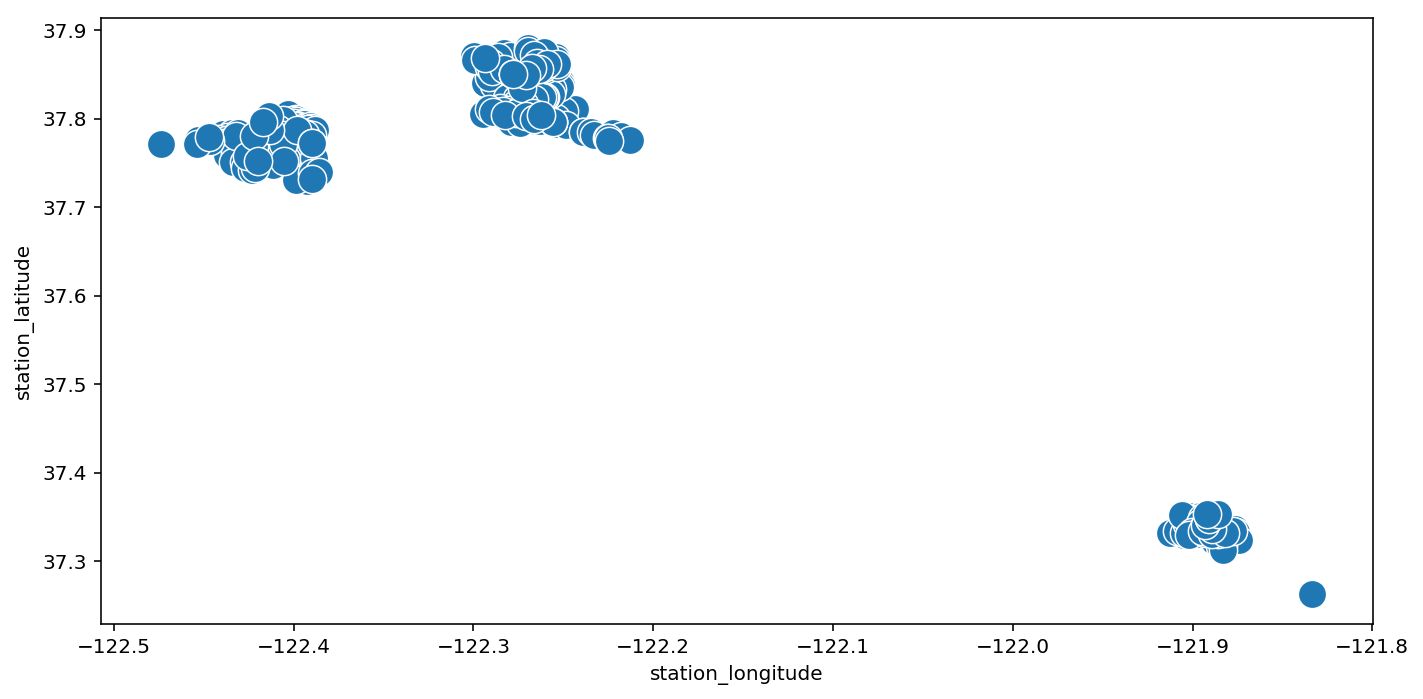

In [323]:
axes, figure = plt.subplots(figsize = (10,5))
#sns.scatterplot(data = df[df.start_station_id.isnull()], x = "start_station_longitude", y = "start_station_latitude", alpha = 0.15, s = 200)
sns.scatterplot(data = df_station_names, x = "station_longitude", y = "station_latitude", s = 200)

plt.tight_layout()

At first we can see, that there are three clear clusters in this dataset. The website of FordGoBike differs following zones: "San Francisco, East Bay, San José"

In [320]:
df_station_names.id.value_counts()[df_station_names.id.value_counts()>1]

192.0    3
205.0    3
130.0    3
221.0    3
244.0    3
212.0    3
208.0    3
233.0    3
101.0    3
280.0    3
250.0    2
364.0    2
234.0    2
358.0    2
224.0    2
281.0    2
344.0    2
245.0    2
302.0    2
321.0    2
173.0    2
272.0    2
345.0    2
80.0     2
Name: id, dtype: int64

Here we can see an interesting thing: One ID can refer to multiple different stations. 

In [325]:
df_station_names[df_station_names.duplicated("id", keep = False)]

,id,station_name,station_latitude,station_longitude
70,80.0,Townsend St at 5th St,37.775306,-122.397380
71,80.0,Townsend St at 5th St,37.775235,-122.397437
89,101.0,San Bruno Ave at 16th St,37.766008,-122.405677
90,101.0,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706
91,101.0,15th St at Potrero Ave,37.767079,-122.407359
116,130.0,22nd St Caltrain Station,37.757718,-122.391813
117,130.0,22nd St Caltrain Station,37.757288,-122.392051
118,130.0,22nd St Caltrain Station,37.757369,-122.392057
157,173.0,Shattuck Ave at 55th Ave,37.840364,-122.264488
158,173.0,Shattuck Ave at 55th St,37.840364,-122.264488


Over time these stations got a new name and/or a new position. This is a problem with data consistency, since we cannot be sure, that - for example - the station 280 is the same station 280 as at the beginning of this datset.

In [326]:
df_station_names.drop_duplicates(subset = ["id", "station_latitude", "station_longitude"]).id.value_counts().head(25) #excludes 4 cases

192.0    3
280.0    3
130.0    3
244.0    3
212.0    3
208.0    3
101.0    3
302.0    2
345.0    2
234.0    2
358.0    2
224.0    2
221.0    2
344.0    2
245.0    2
250.0    2
364.0    2
205.0    2
233.0    2
80.0     2
116.0    1
112.0    1
106.0    1
136.0    1
134.0    1
Name: id, dtype: int64

If we filter this data by these stations, which didn't changed the position and just the name, we exclude just 4 cases. The rest of the cases are still relevant to investigate.

In [327]:
df_consistency = df[["end_station_id", "end_station_name", "end_station_latitude", "end_station_longitude"]].copy().merge(df_station_names, left_on = "end_station_id", right_on = "id", how = "outer")

df_consistency_issues = df_consistency.drop_duplicates().dropna()

In [328]:
df_stat_dist = df_consistency_issues[(df_consistency_issues.end_station_latitude != df_consistency_issues.station_latitude) & \
                                     (df_consistency_issues.end_station_longitude != df_consistency_issues.station_longitude)].copy()

In [329]:
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude/43211266#43211266

def calculate_coord_dist(col):
    coords_1 = (col[0], col[1])
    coords_2 = (col[2], col[3])
    
    return geopy.distance.distance(coords_1, coords_2).m

In [330]:
df_stat_dist["dist_in_m"] = df_stat_dist[["end_station_latitude", "end_station_longitude", "station_latitude", "station_longitude"]].apply(calculate_coord_dist, axis = 1)

In [331]:
df_stat_dist_data = df_stat_dist.drop_duplicates("dist_in_m").sort_values("dist_in_m", ascending = False)
df_stat_dist_data

,end_station_id,end_station_name,end_station_latitude,end_station_longitude,id,station_name,station_latitude,station_longitude,dist_in_m
2225146,302.0,Tamien Station,37.312854,-121.882941,302.0,Tamien Station,37.347721,-121.890856,3932.749001
2089615,208.0,S. 4th St at San Carlos St,37.332836,-121.883912,208.0,William St at 4th St (Temporary Location),37.329964,-121.881922,364.265416
2089614,208.0,S. 4th St at San Carlos St,37.332836,-121.883912,208.0,S. 4th St at San Carlos St,37.330040,-121.881821,361.415563
2064741,192.0,MLK Jr Way at 36th St (Temporary Location),37.825794,-122.269399,192.0,37th St at West St,37.826696,-122.271797,233.626394
2062975,192.0,37th St at West St,37.826696,-122.271795,192.0,MLK Jr Way at 36th St (Temporary Location),37.825794,-122.269399,233.531415
2114531,101.0,San Bruno Ave at 16th St,37.766008,-122.405677,101.0,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,191.626231
2114532,101.0,San Bruno Ave at 16th St,37.766008,-122.405677,101.0,15th St at Potrero Ave,37.767079,-122.407359,189.950934
742450,205.0,Shafter Ave at Cavour St,37.837947,-122.257243,205.0,Miles Ave at Cavour St,37.838800,-122.258732,161.715577
1519216,212.0,Webster St at MacArthur Blvd (Temporary Location),37.825008,-122.261649,212.0,Mosswood Park,37.824893,-122.260437,107.512094
1510980,212.0,Mosswood Park,37.824931,-122.260479,212.0,Webster St at MacArthur Blvd (Temporary Location),37.825008,-122.261649,103.387088


We can see that the range of distance between new stations lies between nearly 0 to 364 meters (and nearly 4 km in the worst case). This needs to be a part of data cleaning. Now we will look at the overall number structure of this dataset.

In [260]:
df.describe().round(2)

,duration_sec,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,label,age,dayofweek,start_hr,end_hr
count,2226999.00,2226999.00,2226999.00,2226999.00,2226999.00,2226999.00,2226999.00,2226999.00,2226999.00,2226999.00
mean,833.69,37.77,-122.35,37.77,-122.35,1.17,149.02,2.60,13.50,13.67
std,2249.12,0.10,0.12,0.10,0.12,0.48,462.35,1.83,4.74,4.77
min,61.00,37.26,-122.47,37.26,-122.47,0.00,17.00,0.00,0.00,0.00
25%,346.00,37.77,-122.41,37.77,-122.41,1.00,28.00,1.00,9.00,9.00
50%,549.00,37.78,-122.40,37.78,-122.40,1.00,33.00,3.00,14.00,14.00
75%,859.00,37.80,-122.29,37.80,-122.29,1.00,42.00,4.00,17.00,18.00
max,86366.00,37.88,-121.83,37.88,-121.83,2.00,2018.00,6.00,23.00,23.00


Nothing too obvious here. There seems to be an outlier at the maximum duration_sec.

In [261]:
df.query("duration_sec == 86366")

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,new_id,label,age,month_year,day_month_year,dayofweek,start_hr,end_hr,label_name,combi
1375987,86366,2018-02-03 17:32:04.042,2018-02-04 17:31:30.788,197,El Embarcadero at Grand Ave,37.808848,-122.24968,197,El Embarcadero at Grand Ave,37.808848,...,197_0,2,2018,2018-02,2018-02-03,5,17,17,San Francisco,197_0 - 197_0


Maybe somebody forgot to log off. 

In [262]:
df.query("duration_sec > 80000")

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,new_id,label,age,month_year,day_month_year,dayofweek,start_hr,end_hr,label_name,combi
5131,81785,2018-07-27 17:51:06.310,2018-07-28 16:34:11.905,86,Market St at Dolores St,37.769305,-122.426826,43,San Francisco Public Library (Grove St at Hyde...,37.778768,...,86_0,1,34,2018-07,2018-07-27,4,17,16,San José,86_0 - 43_0
11320,86003,2018-04-02 16:43:50.239,2018-04-03 16:37:13.786,316,San Salvador St at 1st St,37.330165,-121.885831,304,Jackson St at 5th St,37.348759,...,316_0,0,2018,2018-04,2018-04-02,0,16,16,East Bay,316_0 - 304_0
43638,82743,2019-01-19 16:13:13.763,2019-01-20 15:12:16.894,11,Davis St at Jackson St,37.797280,-122.398436,64,5th St at Brannan St,37.776754,...,11_0,1,42,2019-01,2019-01-19,5,16,15,San José,11_0 - 64_0
61586,82849,2018-06-26 18:24:37.670,2018-06-27 17:25:27.530,17,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,345,Hubbell St at 16th St,37.766474,...,17_0,1,25,2018-06,2018-06-26,1,18,17,San José,17_0 - 345_0
97230,84193,2018-01-10 10:01:32.352,2018-01-11 09:24:46.268,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,72,Page St at Scott St,37.772406,...,15_0,1,49,2018-01,2018-01-10,2,10,9,San José,15_0 - 72_0
98831,85422,2018-01-31 16:13:34.351,2018-02-01 15:57:17.310,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,...,15_0,1,2018,2018-01,2018-01-31,2,16,15,San José,15_0 - 15_0
100414,80343,2018-02-16 17:02:41.515,2018-02-17 15:21:45.351,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,342,Colin P Kelly Jr St at Townsend St (Temporary ...,37.781383,...,15_0,1,2018,2018-02,2018-02-16,4,17,15,San José,15_0 - 342_0
104907,83754,2018-04-13 12:37:04.119,2018-04-14 11:52:58.211,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,93,4th St at Mission Bay Blvd S,37.770407,...,15_0,1,69,2018-04,2018-04-13,4,12,11,San José,15_0 - 93_0
111713,81678,2018-06-10 18:39:19.656,2018-06-11 17:20:38.104,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,104,4th St at 16th St,37.767045,...,15_0,1,2018,2018-06,2018-06-10,6,18,17,San José,15_0 - 104_0
112784,82524,2018-06-18 20:54:51.141,2018-06-19 19:50:15.385,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,126,Esprit Park,37.761634,...,15_0,1,28,2018-06,2018-06-18,0,20,19,San José,15_0 - 126_0


Or some users really rent these bikes for this duration. For the final part of this assessing we will look on the missing values in the birth_year column.

In [339]:
df[df.member_birth_year.isnull()].head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
1,85422,2018-01-31 16:13:34.3510,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,2815,Customer,NaN,NaN,No
3,61076,2018-01-31 14:53:23.5620,2018-02-01 07:51:20.5000,75.0,Market St at Franklin St,37.773793,-122.421239,47.0,4th St at Harrison St,37.780955,-122.399749,321,Customer,NaN,NaN,No
5,6477,2018-01-31 22:58:44.8670,2018-02-01 00:46:41.9080,236.0,Market St at 8th St,37.803686,-122.282497,160.0,West Oakland BART Station,37.805318,-122.294837,1306,Customer,NaN,NaN,No
10,1316,2018-01-31 23:24:00.4160,2018-01-31 23:45:56.8240,98.0,Valencia St at 16th St,37.765052,-122.421866,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,1278,Customer,NaN,NaN,No
18,350,2018-01-31 23:13:45.5290,2018-01-31 23:19:36.2650,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,274.0,Oregon St at Adeline St,37.857567,-122.267558,431,Subscriber,NaN,NaN,No


The reason for this missing values can be, that the users don't have to write down their birth years during registration.

<a id='assessingsum'></a>
### Assessing Summary

#### Quality
##### df table
- there are missing values in the station_id, station_name, member_birth_year and member_gender columns
- the columns 'start_time' and 'end_time' are not datetime type
- the columns 'start_station_id', 'end_station_id', 'member_birth_year' and 'bike_id' are not object type
- some stations share the same ID while they changed the position over time (consistency problem)


#### Tidiness
##### df table
- None

<a id='cleaning'></a>
## Data Cleaning

### Issue #1
> #### Define #1
>- there are missing values in the station_id, station_name, member_birth_year and member_gender columns

> #### Clean #1

In [279]:
#there are multiple ways how to handle this - but since the coordinates are not precise we will just drop them
df.dropna(subset = ["start_station_id"], inplace = True)

In [280]:
#fill up the missing values
df.member_birth_year.fillna(0, inplace = True)
df.member_gender.fillna("not defined", inplace = True)

> #### Test #1

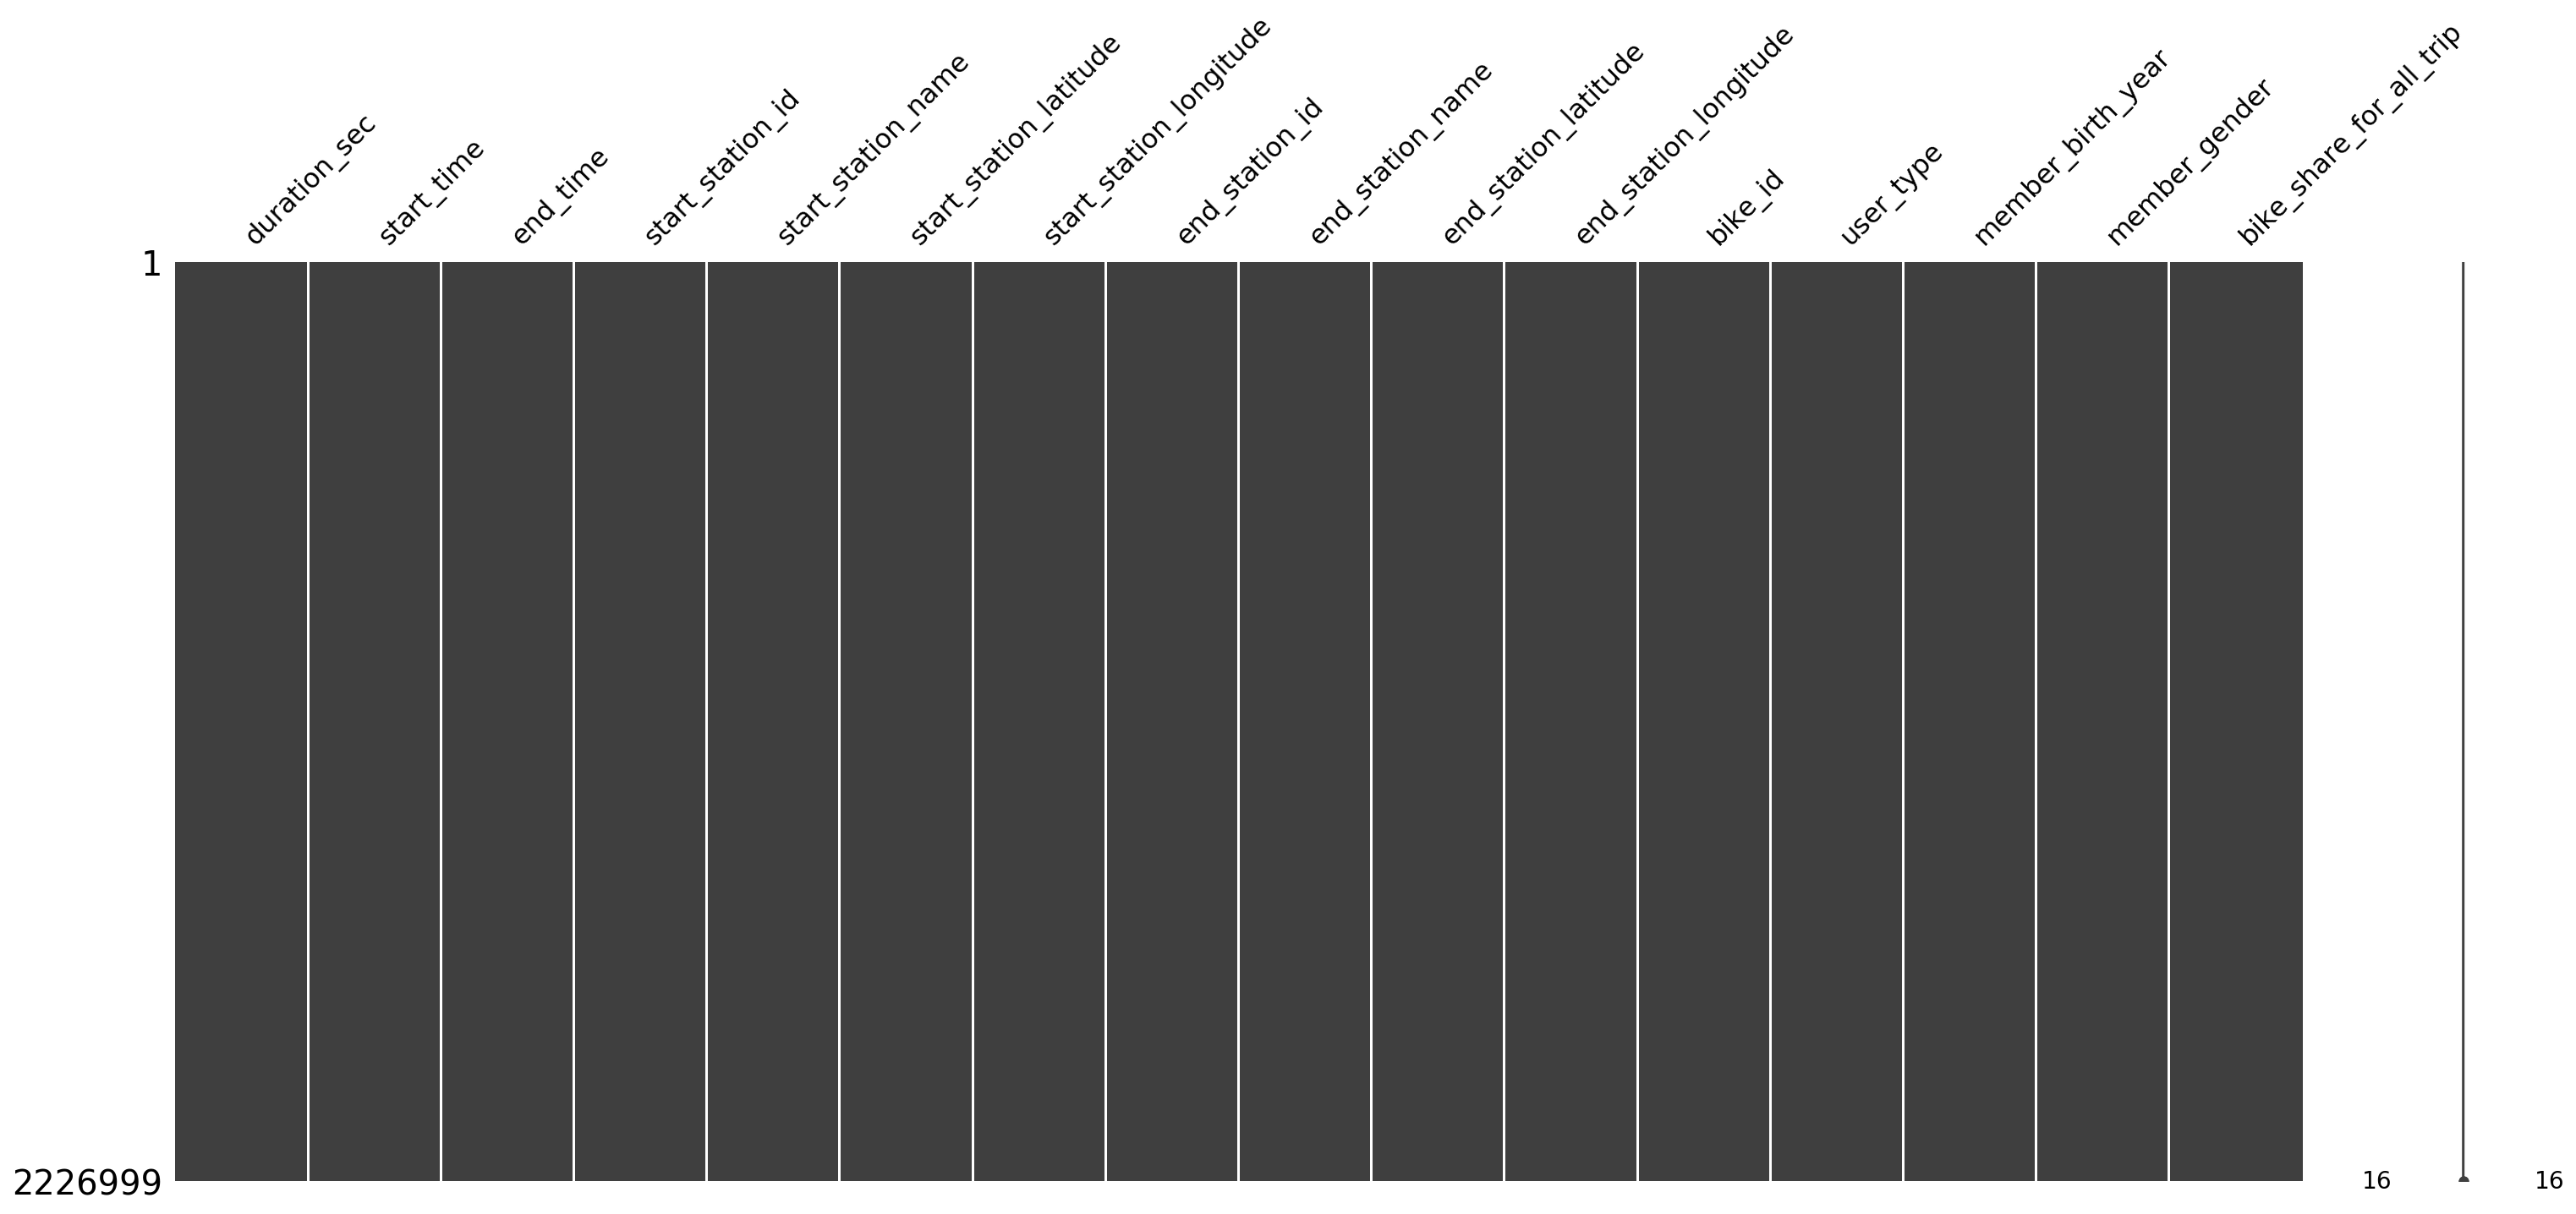

In [281]:
ms.matrix(df)

### Issue #2
> #### Define #2
>- the columns 'start_time' and 'end_time' are not datetime type
>- the columns 'start_station_id', 'end_station_id', 'member_birth_year' and 'bike_id' are not object type

> #### Clean #2

In [282]:
for col in ["start_time", "end_time"]:
    df[col] = pd.to_datetime(df[col])
    
for col in ["start_station_id", "end_station_id"]:
    df[col] = df[col].astype("int")

for col in ["start_station_id", "end_station_id", "member_birth_year", "bike_id"]:
    df[col] = df[col].astype("str")

> #### Test #2

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2226999 entries, 0 to 2239214
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          object
member_gender              object
bike_share_for_all_trip    object
dtypes: datetime64[ns](2), float64(4), int64(1), object(9)
memory usage: 288.8+ MB


### Issue #3
> #### Define #3
>- some stations share the same ID while they changed the position over time (consistency problem)

> #### Clean #3

We could just accept, that these stations differ over time. Another approach is to give the ID's a new "subindex". So everytime the coordinates of a station ID differs from the occurrence of this station before, we will increase the subindex by 1.

In [284]:
df.sort_values("start_time", inplace = True)
df.reset_index(inplace = True, drop = True)

In [285]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,13709,2018-01-01 00:01:53.847,2018-01-01 03:50:23.433,86,Market St at Dolores St,37.769305,-122.426826,119,18th St at Noe St,37.761047,-122.432642,2924,Customer,0.0,not defined,No
1,145,2018-01-01 00:07:41.040,2018-01-01 00:10:06.241,316,San Salvador St at 1st St,37.330165,-121.885831,311,Paseo De San Antonio at 2nd St,37.333798,-121.886943,2473,Subscriber,1957.0,Male,No
2,714,2018-01-01 00:07:52.943,2018-01-01 00:19:47.075,74,Laguna St at Hayes St,37.776435,-122.426244,70,Central Ave at Fell St,37.773311,-122.444293,2423,Subscriber,1986.0,Male,No
3,1151,2018-01-01 00:09:31.745,2018-01-01 00:28:43.159,97,14th St at Mission St,37.768265,-122.420110,125,20th St at Bryant St,37.759200,-122.409851,3455,Subscriber,1992.0,Male,No
4,1359,2018-01-01 00:14:37.187,2018-01-01 00:37:16.445,11,Davis St at Jackson St,37.797280,-122.398436,323,Broadway at Kearny,37.798014,-122.405950,2173,Customer,1995.0,Male,No


In [286]:
def get_new_id(col):
    
    #when the row is not in id_data - append it
    if col[0] not in id_data:
        id_data[col[0]] = [col[1], col[2], col[3], f"{col[0]}_0"]
        return id_data[col[0]][3]
    
    #if the row exists in id_data, then check if the coordinates change, if yes - calculate the distance and increase the id and replace the saved coordinates in id_data with the new ones,
    #if not, then just return the saved id
    elif col[0] in id_data:
        if id_data[col[0]][1] != col[2] or id_data[col[0]][2] != col[3]:
            coords_1 = (id_data[col[0]][1], id_data[col[0]][2])
            coords_2 = (col[2], col[3])
                
            if geopy.distance.distance(coords_1, coords_2).m > 100:
                new_ind = str(col[0]) + "_" + str(int(id_data[col[0]][3][-1])+1)
                id_data[col[0]][3] = new_ind
                id_data[col[0]][1] = col[2]
                id_data[col[0]][2] = col[3]

                return new_ind
            else:
                return id_data[col[0]][3]

        else:
            return id_data[col[0]][3]
            
    else:
        return "Error"   

In [287]:
id_data = {}
df["start_station_id_new"] = df[["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude"]].apply(get_new_id, axis = 1)

In [288]:
id_data = {}
df["end_station_id_new"] = df[["end_station_id", "end_station_name", "end_station_latitude", "end_station_longitude"]].apply(get_new_id, axis = 1)

In [289]:
df_station_names.head()

,id,station_name,station_latitude,station_longitude,new_id
0,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,3.0_0
1,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,4.0_0
2,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,5.0_0
3,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,6.0_0
4,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,7.0_0


In [290]:
df_station_names = df[["start_time", "start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude"]].copy()
df_station_names.sort_values("start_time", inplace = True)
df_station_names.drop("start_time", axis = 1, inplace = True)
df_station_names.rename(columns={"start_station_id": "id", 
                                 "start_station_name": "station_name", 
                                 "start_station_latitude": "station_latitude", 
                                 "start_station_longitude": "station_longitude"}, inplace = True)

df_station_names.drop_duplicates(inplace = True)
df_station_names.dropna(inplace = True)
id_data = {}
df_station_names["new_id"] = df_station_names[["id", "station_name", "station_latitude", "station_longitude"]].apply(get_new_id, axis = 1)
df_station_names.sort_values("id", inplace = True)
df_station_names.reset_index(inplace = True, drop = True)

> #### Test #3

In [291]:
df.query("start_station_id == '208'").drop_duplicates("start_station_id_new")[["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude", "start_station_id_new"]]

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,start_station_id_new
556,208,S. 4th St at San Carlos St,37.332836,-121.883912,208_0
817544,208,S. 4th St at San Carlos St,37.330040,-121.881821,208_1


In [292]:
df.query("end_station_id == '208'").drop_duplicates("end_station_id_new")[["end_station_id", "end_station_name", "end_station_latitude", "end_station_longitude", "end_station_id_new"]]

,end_station_id,end_station_name,end_station_latitude,end_station_longitude,end_station_id_new
478,208,S. 4th St at San Carlos St,37.332836,-121.883912,208_0
817103,208,S. 4th St at San Carlos St,37.330040,-121.881821,208_1


In [293]:
#export the station names to csv
df_station_names.to_csv("df_station_names.csv", index = False)

In [294]:
#export the cleaned csv 
df.to_csv("result_clean.csv", index = False)

<a id='analysis'></a>
## Exploratory Data Visualization

Now that the cleaning is done, we can start to visualize the data. 

In [295]:
df = pd.read_csv("result_clean.csv")

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226999 entries, 0 to 2226998
Data columns (total 18 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           int64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             int64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
start_station_id_new       object
end_station_id_new         object
dtypes: float64(5), int64(4), object(9)
memory usage: 305.8+ MB


In [390]:
#wrong datatypes again
for col in ["start_time", "end_time"]:
    df[col] = pd.to_datetime(df[col])
    
for col in ["member_birth_year"]:
    df[col] = df[col].astype("int")

for col in ["start_station_id", "end_station_id", "member_birth_year", "bike_id"]:
    df[col] = df[col].astype("str")

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226999 entries, 0 to 2226998
Data columns (total 18 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          object
member_gender              object
bike_share_for_all_trip    object
start_station_id_new       object
end_station_id_new         object
dtypes: datetime64[ns](2), float64(4), int64(1), object(11)
memory usage: 305.8+ MB


In [299]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_station_id_new,end_station_id_new
0,13709,2018-01-01 00:01:53.847,2018-01-01 03:50:23.433,86,Market St at Dolores St,37.769305,-122.426826,119,18th St at Noe St,37.761047,-122.432642,2924,Customer,0,not defined,No,86_0,119_0
1,145,2018-01-01 00:07:41.040,2018-01-01 00:10:06.241,316,San Salvador St at 1st St,37.330165,-121.885831,311,Paseo De San Antonio at 2nd St,37.333798,-121.886943,2473,Subscriber,1957,Male,No,316_0,311_0
2,714,2018-01-01 00:07:52.943,2018-01-01 00:19:47.075,74,Laguna St at Hayes St,37.776435,-122.426244,70,Central Ave at Fell St,37.773311,-122.444293,2423,Subscriber,1986,Male,No,74_0,70_0
3,1151,2018-01-01 00:09:31.745,2018-01-01 00:28:43.159,97,14th St at Mission St,37.768265,-122.420110,125,20th St at Bryant St,37.759200,-122.409851,3455,Subscriber,1992,Male,No,97_0,125_0
4,1359,2018-01-01 00:14:37.187,2018-01-01 00:37:16.445,11,Davis St at Jackson St,37.797280,-122.398436,323,Broadway at Kearny,37.798014,-122.405950,2173,Customer,1995,Male,No,11_0,323_0


In [300]:
df_station_names = pd.read_csv("df_station_names.csv")

In [301]:
df_station_names.head()

,id,station_name,station_latitude,station_longitude,new_id
0,10,Washington St at Kearny St,37.795393,-122.404770,10_0
1,100,Bryant St at 15th St,37.767100,-122.410662,100_0
2,101,San Bruno Ave at 16th St,37.766008,-122.405677,101_0
3,101,15th St at Potrero Ave,37.767079,-122.407359,101_1
4,101,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,101_1


Before we start visualizing, we can extract some additional information out of the data to improve the insights. We saw, that these datapoints can be separeted in three clear clusters. Since these clusters are really obvious, we can classify them using the K-Means Clustering algorithm. 

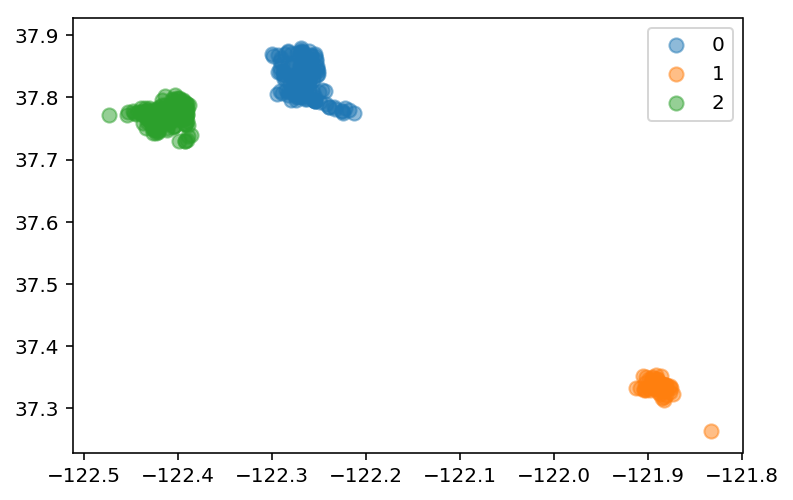

In [302]:
#https://datatofish.com/k-means-clustering-python/

kmeans = KMeans(n_clusters=3).fit(df_station_names[["station_longitude", "station_latitude"]])

df_station_names["label"] = kmeans.labels_

for x in set(list(df_station_names.label)):
    
    df_plot_cluster = df_station_names.query(f"label == {x}")

    plt.scatter(df_plot_cluster['station_longitude'], df_plot_cluster["station_latitude"], s=50, alpha=0.5, label = x);

plt.legend();


Now that this is done, we can visualize this data on a map. This can happen with Bokeh or Plotly for example, but I will take the website kepler.gl out of the toolbox for the map visualizations.

**Source:** <a href = https://kepler.gl/>kepler.gl</a>

![All Stations](Images/stations_kepler.png)
![Upper Two Cluster](Images/stations_1.png)
![Lower Cluster](Images/stations_2.png)

Now we will map the labels with the original names.

In [303]:
mapping = {0: "East Bay", 1: "San José", 2: "San Francisco"}

In [304]:
df_station_names["label_name"] = df_station_names["label"].map(mapping)

In [305]:
df_station_names.head()

,id,station_name,station_latitude,station_longitude,new_id,label,label_name
0,10,Washington St at Kearny St,37.795393,-122.404770,10_0,2,San Francisco
1,100,Bryant St at 15th St,37.767100,-122.410662,100_0,2,San Francisco
2,101,San Bruno Ave at 16th St,37.766008,-122.405677,101_0,2,San Francisco
3,101,15th St at Potrero Ave,37.767079,-122.407359,101_1,2,San Francisco
4,101,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,101_1,2,San Francisco


In [306]:
df_station_names.label_name.value_counts()

San Francisco    172
East Bay         146
San José          56
Name: label_name, dtype: int64

In [307]:
df_station_names.head()

,id,station_name,station_latitude,station_longitude,new_id,label,label_name
0,10,Washington St at Kearny St,37.795393,-122.404770,10_0,2,San Francisco
1,100,Bryant St at 15th St,37.767100,-122.410662,100_0,2,San Francisco
2,101,San Bruno Ave at 16th St,37.766008,-122.405677,101_0,2,San Francisco
3,101,15th St at Potrero Ave,37.767079,-122.407359,101_1,2,San Francisco
4,101,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,101_1,2,San Francisco


In [308]:
df_station_names[df_station_names.duplicated("new_id", keep = False)] # duplicates for new coordinates which are not > 100 m away from the origin 

,id,station_name,station_latitude,station_longitude,new_id,label,label_name
3,101,15th St at Potrero Ave,37.767079,-122.407359,101_1,2,San Francisco
4,101,Potrero Ave at 15th St (Temporary Location),37.766629,-122.407706,101_1,2,San Francisco
31,130,22nd St Caltrain Station,37.757718,-122.391813,130_0,2,San Francisco
32,130,22nd St Caltrain Station,37.757288,-122.392051,130_0,2,San Francisco
33,130,22nd St Caltrain Station,37.757369,-122.392057,130_0,2,San Francisco
76,173,Shattuck Ave at 55th Ave,37.840364,-122.264488,173_0,0,East Bay
77,173,Shattuck Ave at 55th St,37.840364,-122.264488,173_0,0,East Bay
111,205,Miles Ave at Cavour St,37.838800,-122.258732,205_1,0,East Bay
113,205,Miles Ave at Cavour St (Temporary Location),37.838800,-122.258732,205_1,0,East Bay
116,208,William St at 4th St (Temporary Location),37.329964,-121.881922,208_1,1,San José


In [309]:
df_station_names.drop_duplicates(subset = ["new_id"], inplace = True)

In [310]:
df_station_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 373
Data columns (total 7 columns):
id                   348 non-null int64
station_name         348 non-null object
station_latitude     348 non-null float64
station_longitude    348 non-null float64
new_id               348 non-null object
label                348 non-null int32
label_name           348 non-null object
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 20.4+ KB


In [311]:
df[df.duplicated(subset = ["start_time", "end_time"], keep = False)]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_station_id_new,end_station_id_new


In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226999 entries, 0 to 2226998
Data columns (total 18 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          object
member_gender              object
bike_share_for_all_trip    object
start_station_id_new       object
end_station_id_new         object
dtypes: datetime64[ns](2), float64(4), int64(1), object(11)
memory usage: 305.8+ MB


Now we can merge the labels to the id's of the main dataframe.

In [313]:
df = df.merge(df_station_names[["new_id", "label"]], left_on = "start_station_id_new", right_on = "new_id", how = "outer")

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2226999 entries, 0 to 2226998
Data columns (total 20 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          object
member_gender              object
bike_share_for_all_trip    object
start_station_id_new       object
end_station_id_new         object
new_id                     object
label                      int32
dtypes: datetime64[ns](2), float64(4), int32(1), int64(1), object(12)
memory usage: 348.3+ MB


In [315]:
df[df.label.isnull()].start_station_id_new.value_counts()

Series([], Name: start_station_id_new, dtype: int64)

In [316]:
df.query("start_station_id == '205'").drop_duplicates("start_station_id_new")[["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude", "start_station_id_new", "label"]]

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,start_station_id_new,label
1157345,205,Shafter Ave at Cavour St,37.837947,-122.257243,205_0,0
2178748,205,Miles Ave at Cavour St (Temporary Location),37.838800,-122.258732,205_1,0


In [ ]:
df["label_name"] = df["label"].map(mapping)

In [391]:
df.label_name.value_counts()

San Francisco    1639401
East Bay          485045
San José          102553
Name: label_name, dtype: int64

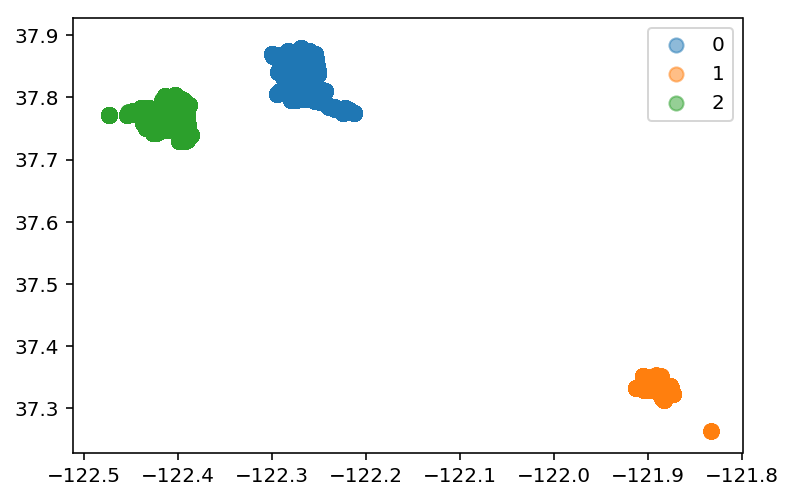

In [324]:
for x in set(list(df.label)):
    
    df_plot_cluster = df.query(f"label == {x}")

    plt.scatter(df_plot_cluster['start_station_longitude'], df_plot_cluster["start_station_latitude"], s=50, alpha=0.5, label = x);

plt.legend();


Now we will extract multiple other informations out of the birth year and the start_time - timestamp.

In [317]:
df["age"] = df["member_birth_year"].apply(lambda x: 2018 - int(x))

In [318]:
df['month_year'] = pd.to_datetime(df["start_time"]).dt.to_period('M')

In [319]:
df['day_month_year'] = pd.to_datetime(df["start_time"]).dt.to_period('D')

In [320]:
df["dayofweek"] = df["start_time"].apply(lambda x: x.dayofweek)

In [321]:
df["start_hr"] = df["start_time"].apply(lambda x: x.hour)
df["end_hr"] = df["end_time"].apply(lambda x: x.hour)

In [325]:
df_age = df.query("age != 2018 and age < 100").copy()

In [326]:
df_age.age.min()

17

In [327]:
bins = [x for x in range(10,101, 10)]
df_age["age_bins"] = pd.cut(df_age.age, bins = bins, precision = 0, include_lowest=False)

In [328]:
df_age[["age", "age_bins"]].head()

,age,age_bins
2,61,"(60, 70]"
3,31,"(30, 40]"
5,54,"(50, 60]"
6,34,"(30, 40]"
7,37,"(30, 40]"


In [329]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,end_station_id_new,new_id,label,age,month_year,day_month_year,dayofweek,start_hr,end_hr,label_name
0,13709,2018-01-01 00:01:53.847,2018-01-01 03:50:23.433,86,Market St at Dolores St,37.769305,-122.426826,119,18th St at Noe St,37.761047,...,119_0,86_0,2,2018,2018-01,2018-01-01,0,0,3,San Francisco
1,9996,2018-01-01 04:37:08.115,2018-01-01 07:23:44.143,86,Market St at Dolores St,37.769305,-122.426826,223,16th St Mission BART Station 2,37.764765,...,223_0,86_0,2,2018,2018-01,2018-01-01,0,4,7,San Francisco
2,197,2018-01-01 09:29:57.079,2018-01-01 09:33:14.662,86,Market St at Dolores St,37.769305,-122.426826,85,Church St at Duboce Ave,37.770083,...,85_0,86_0,2,61,2018-01,2018-01-01,0,9,9,San Francisco
3,183,2018-01-01 11:25:27.634,2018-01-01 11:28:31.059,86,Market St at Dolores St,37.769305,-122.426826,75,Market St at Franklin St,37.773793,...,75_0,86_0,2,31,2018-01,2018-01-01,0,11,11,San Francisco
4,893,2018-01-01 12:07:39.271,2018-01-01 12:22:32.393,86,Market St at Dolores St,37.769305,-122.426826,42,San Francisco City Hall (Polk St at Grove St),37.778650,...,42_0,86_0,2,2018,2018-01,2018-01-01,0,12,12,San Francisco


Now we are truely ready for the exploratory visualizations.

<a id='uni'></a>
### Univariate Exploration


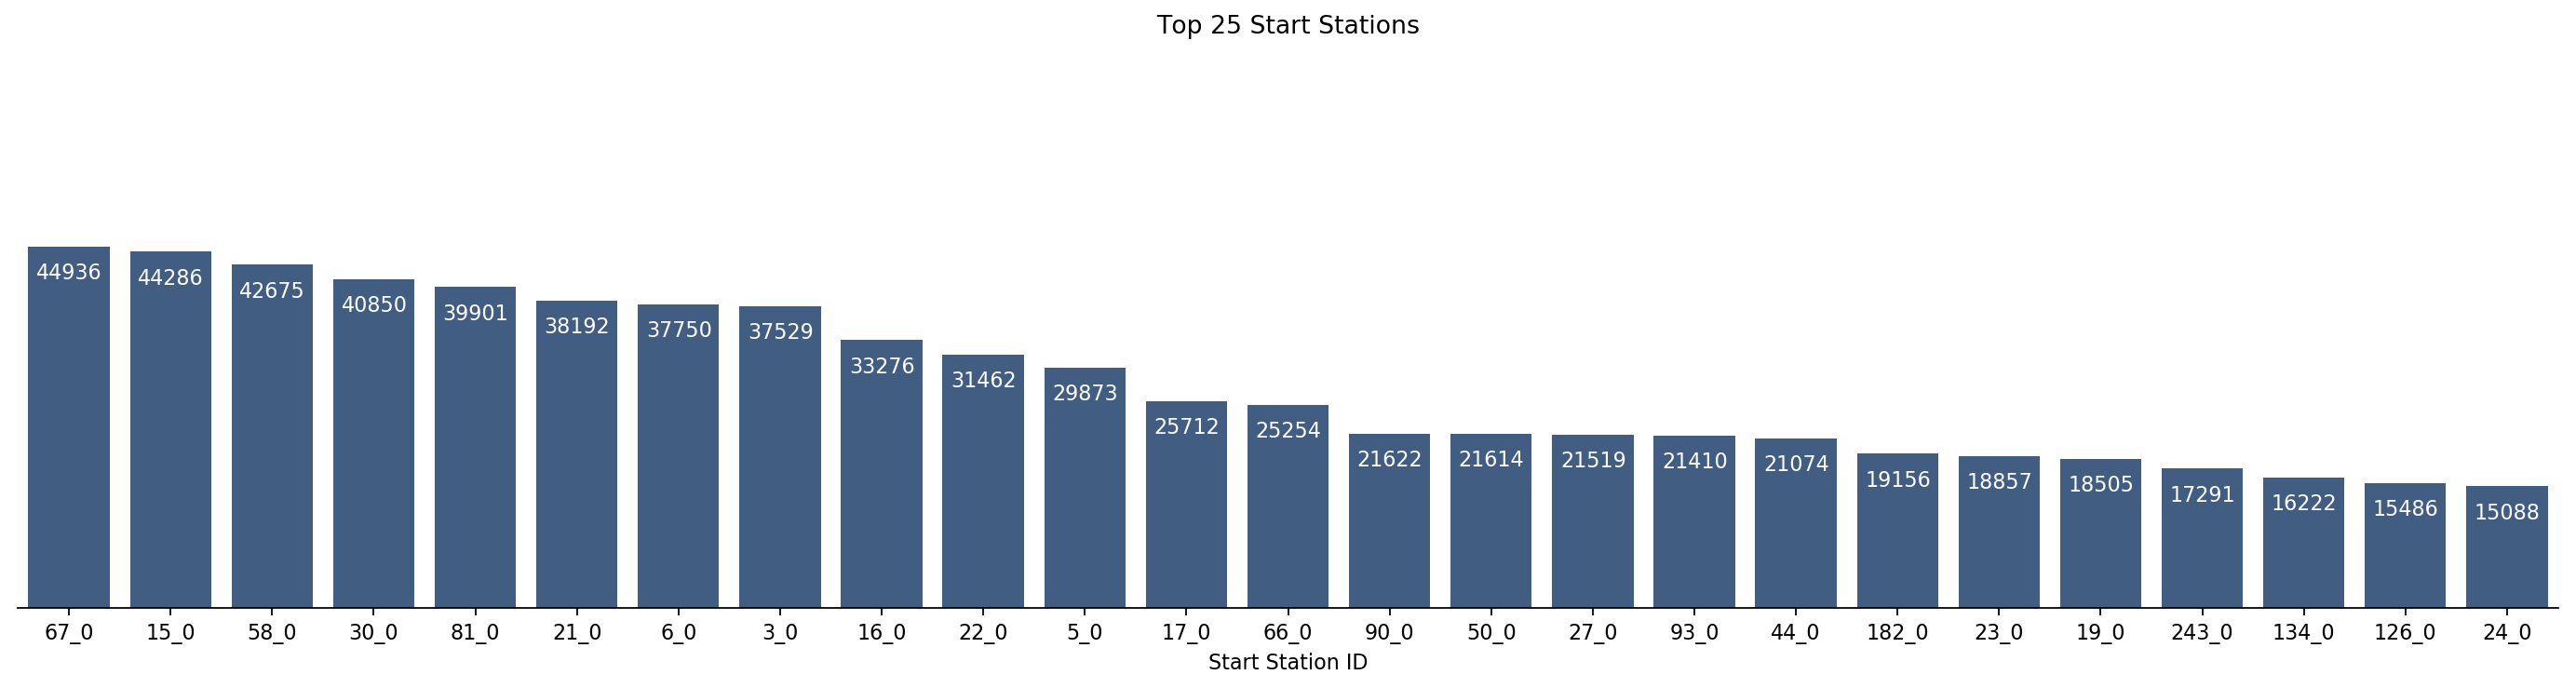

In [330]:
#https://codeyarns.com/2015/06/29/how-to-hide-axis-of-plot-in-matplotlib/

value_ct = df.start_station_id_new.value_counts().iloc[:25]

fig, ax = plt.subplots(figsize = (22,5), dpi = 80)
color = sns.color_palette("viridis")[1]
sns.countplot(x = "start_station_id_new", data = df, order=value_ct.index, color = color);

plt.ylim(0,70000)

cur_axes = plt.gca()
#cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.08, p.get_height()-4000), color = "white")

plt.title("Top 25 Start Stations");
plt.xlabel("Start Station ID");

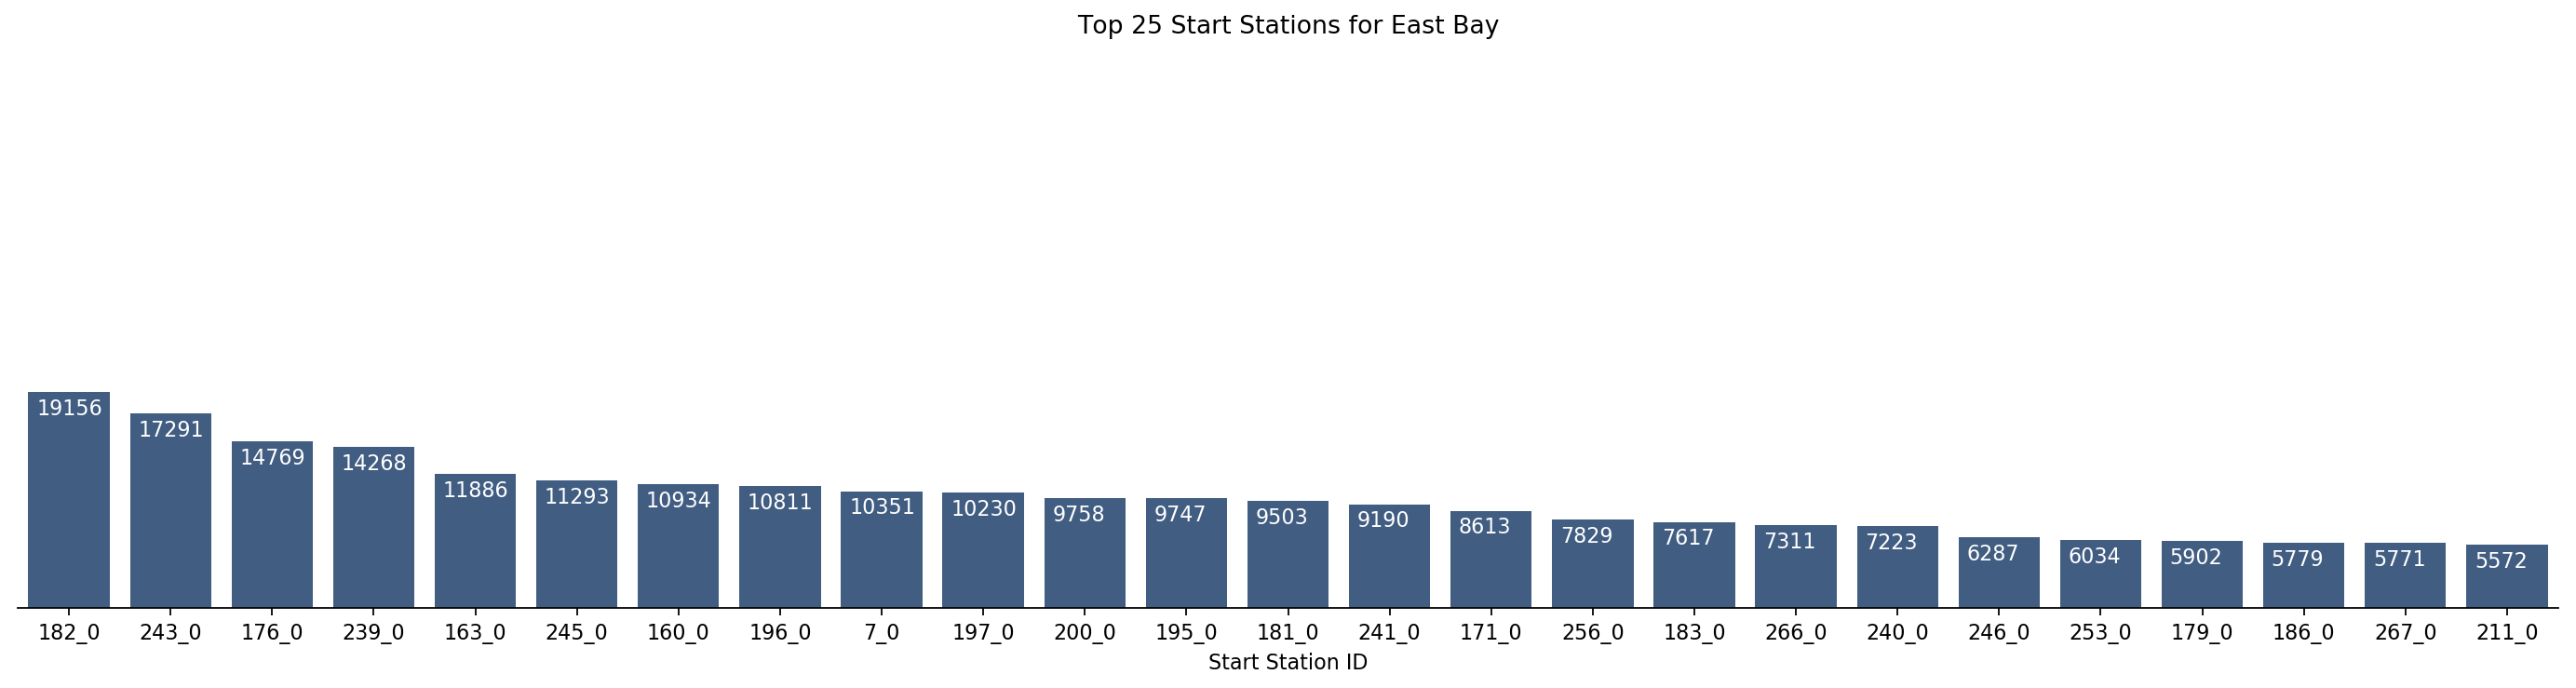

In [392]:
#https://codeyarns.com/2015/06/29/how-to-hide-axis-of-plot-in-matplotlib/

df_new = df.query("label == 0").copy()

value_ct = df_new.start_station_id_new.value_counts().iloc[:25]

fig, ax = plt.subplots(figsize = (22,5), dpi = 80)
color = sns.color_palette("viridis")[1]
sns.countplot(x = "start_station_id_new", data = df_new, order=value_ct.index, color = color);

plt.ylim(0,50000)

cur_axes = plt.gca()
#cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.08, p.get_height()-2000), color = "white")

plt.title("Top 25 Start Stations for East Bay");
plt.xlabel("Start Station ID");

In [332]:
for x in value_ct.index:
    print(x + " - " + str(df.query(f"start_station_id_new == '{x}'").start_station_name.drop_duplicates().get_values()))

182_0 - ['19th Street BART Station']
243_0 - ['Bancroft Way at College Ave']
176_0 - ['MacArthur BART Station']
239_0 - ['Bancroft Way at Telegraph Ave']
163_0 - ['Lake Merritt BART Station']
245_0 - ['Downtown Berkeley BART']
160_0 - ['West Oakland BART Station']
196_0 - ['Grand Ave at Perkins St']
7_0 - ['Frank H Ogawa Plaza']
197_0 - ['El Embarcadero at Grand Ave']
200_0 - ['2nd Ave at E 18th St']
195_0 - ['Bay Pl at Vernon St']
181_0 - ['Grand Ave at Webster St']
241_0 - ['Ashby BART Station']
171_0 - ['Rockridge BART Station']
256_0 - ['Hearst Ave at Euclid Ave']
183_0 - ['Telegraph Ave at 19th St']
266_0 - ['Parker St at Fulton St']
240_0 - ['Haste St at Telegraph Ave']
246_0 - ['Berkeley Civic Center']
253_0 - ['Haste St at College Ave']
179_0 - ['Telegraph Ave at 27th St']
186_0 - ['Lakeside Dr at 14th St']
267_0 - ['Derby St at College Ave']
211_0 - ['Broadway at 40th St']


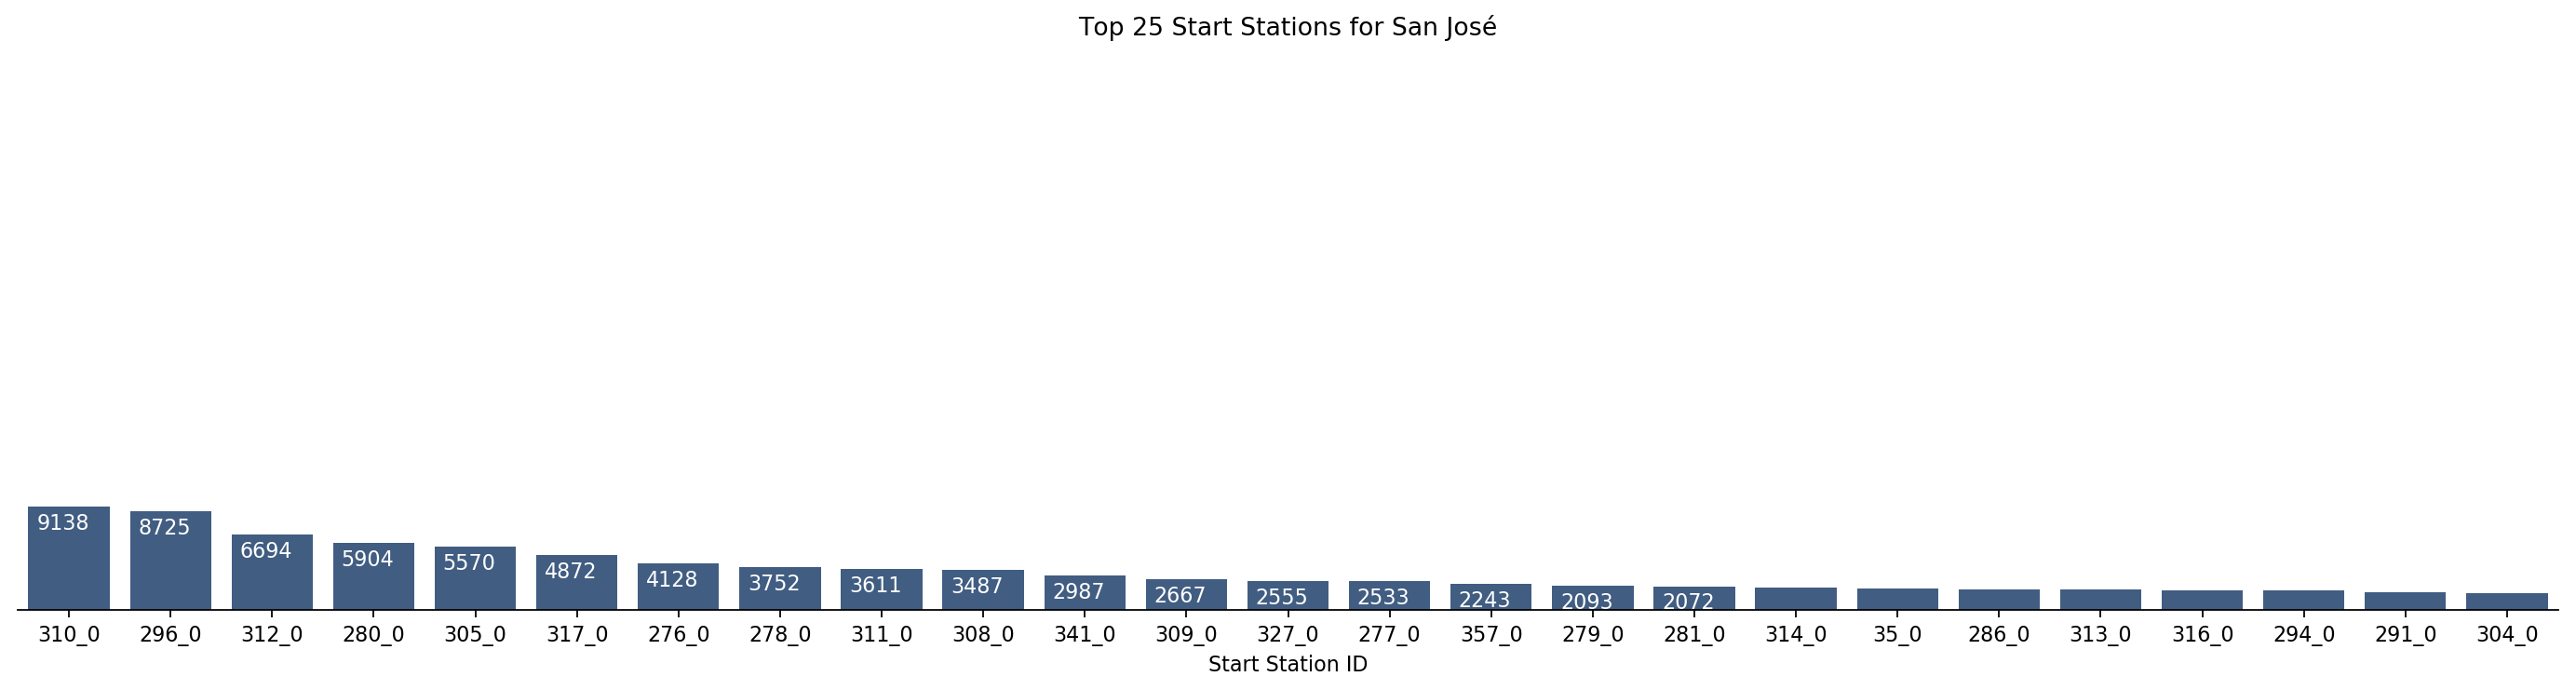

In [393]:
#https://codeyarns.com/2015/06/29/how-to-hide-axis-of-plot-in-matplotlib/

df_new = df.query("label == 1").copy()

value_ct = df_new.start_station_id_new.value_counts().iloc[:25]

fig, ax = plt.subplots(figsize = (22,5), dpi = 80)
color = sns.color_palette("viridis")[1]
sns.countplot(x = "start_station_id_new", data = df_new, order=value_ct.index, color = color);

plt.ylim(0,50000)

cur_axes = plt.gca()
#cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.08, p.get_height()-2000), color = "white")

plt.title("Top 25 Start Stations for San José");
plt.xlabel("Start Station ID");

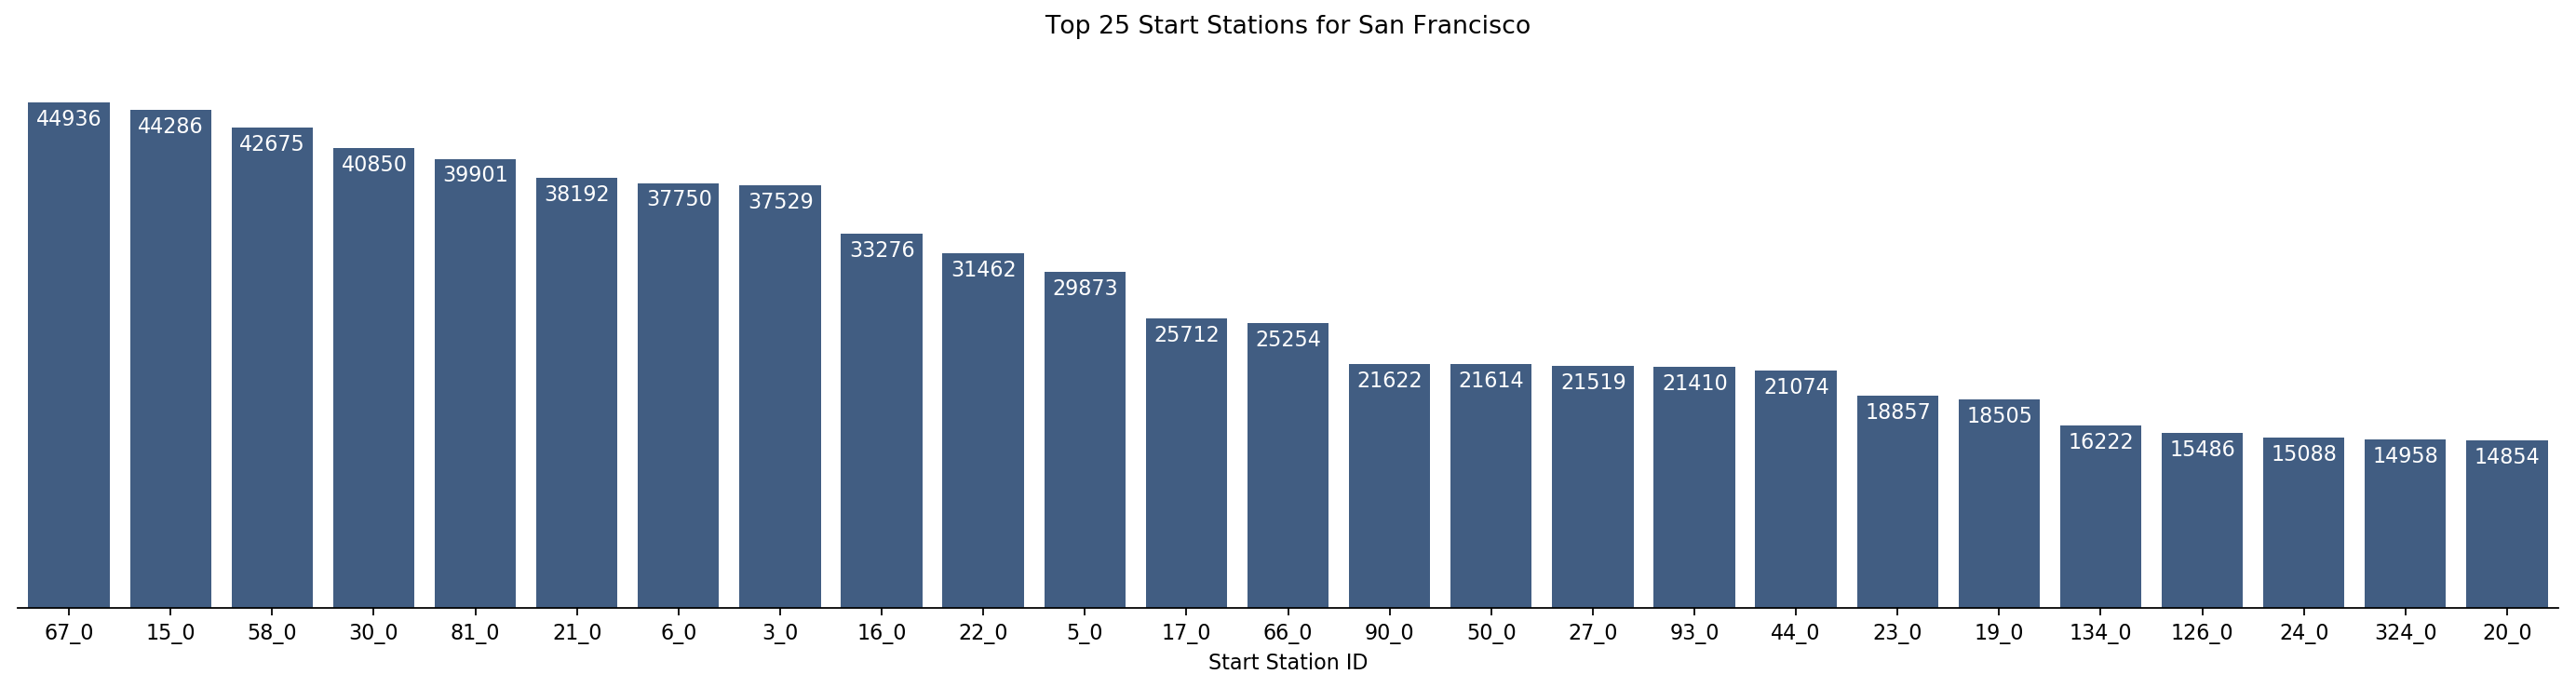

In [394]:
#https://codeyarns.com/2015/06/29/how-to-hide-axis-of-plot-in-matplotlib/

df_new = df.query("label == 2").copy()

value_ct = df_new.start_station_id_new.value_counts().iloc[:25]

fig, ax = plt.subplots(figsize = (22,5), dpi = 80)
color = sns.color_palette("viridis")[1]
sns.countplot(x = "start_station_id_new", data = df_new, order=value_ct.index, color = color);

plt.ylim(0,50000)

cur_axes = plt.gca()
#cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.08, p.get_height()-2000), color = "white")

plt.title("Top 25 Start Stations for San Francisco");
plt.xlabel("Start Station ID");

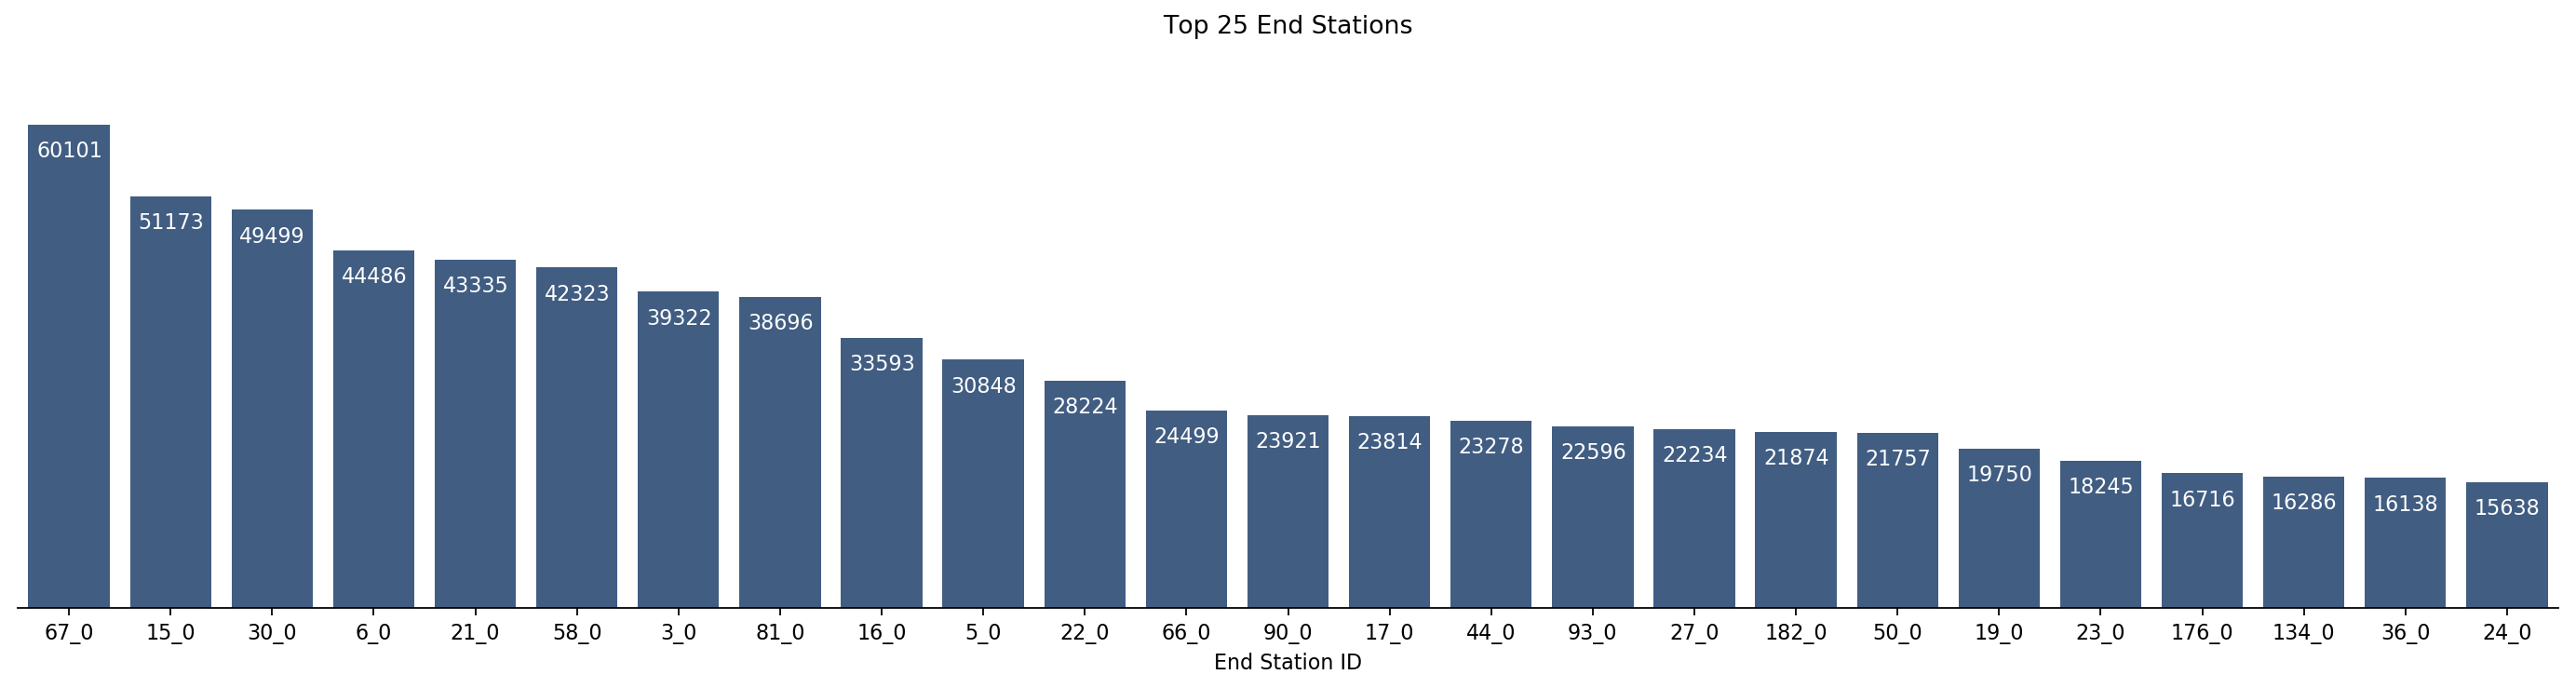

In [335]:
#https://codeyarns.com/2015/06/29/how-to-hide-axis-of-plot-in-matplotlib/

value_ct = df.end_station_id_new.value_counts().iloc[:25]

fig, ax = plt.subplots(figsize = (22,5), dpi = 80)
color = sns.color_palette("viridis")[1]
sns.countplot(x = "end_station_id_new", data = df, order=value_ct.index, color = color);

plt.ylim(0,70000)

cur_axes = plt.gca()
#cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.08, p.get_height()-4000), color = "white")

plt.title("Top 25 End Stations");
plt.xlabel("End Station ID");

In [336]:
for x in value_ct.index:
    print(x + " - " + str(df.query(f"end_station_id_new == '{x}'").end_station_name.drop_duplicates().get_values()))

67_0 - ['San Francisco Caltrain Station 2  (Townsend St at 4th St)']
15_0 - ['San Francisco Ferry Building (Harry Bridges Plaza)']
30_0 - ['San Francisco Caltrain (Townsend St at 4th St)']
6_0 - ['The Embarcadero at Sansome St']
21_0 - ['Montgomery St BART Station (Market St at 2nd St)']
58_0 - ['Market St at 10th St']
3_0 - ['Powell St BART Station (Market St at 4th St)']
81_0 - ['Berry St at 4th St']
16_0 - ['Steuart St at Market St']
5_0 - ['Powell St BART Station (Market St at 5th St)']
22_0 - ['Howard St at Beale St']
66_0 - ['3rd St at Townsend St']
90_0 - ['Townsend St at 7th St']
17_0 - ['Embarcadero BART Station (Beale St at Market St)']
44_0 - ['Civic Center/UN Plaza BART Station (Market St at McAllister St)']
93_0 - ['4th St at Mission Bay Blvd S']
27_0 - ['Beale St at Harrison St']
182_0 - ['19th Street BART Station']
50_0 - ['2nd St at Townsend St']
19_0 - ['Post St at Kearny St']
23_0 - ['The Embarcadero at Steuart St']
176_0 - ['MacArthur BART Station']
134_0 - ['Valenci

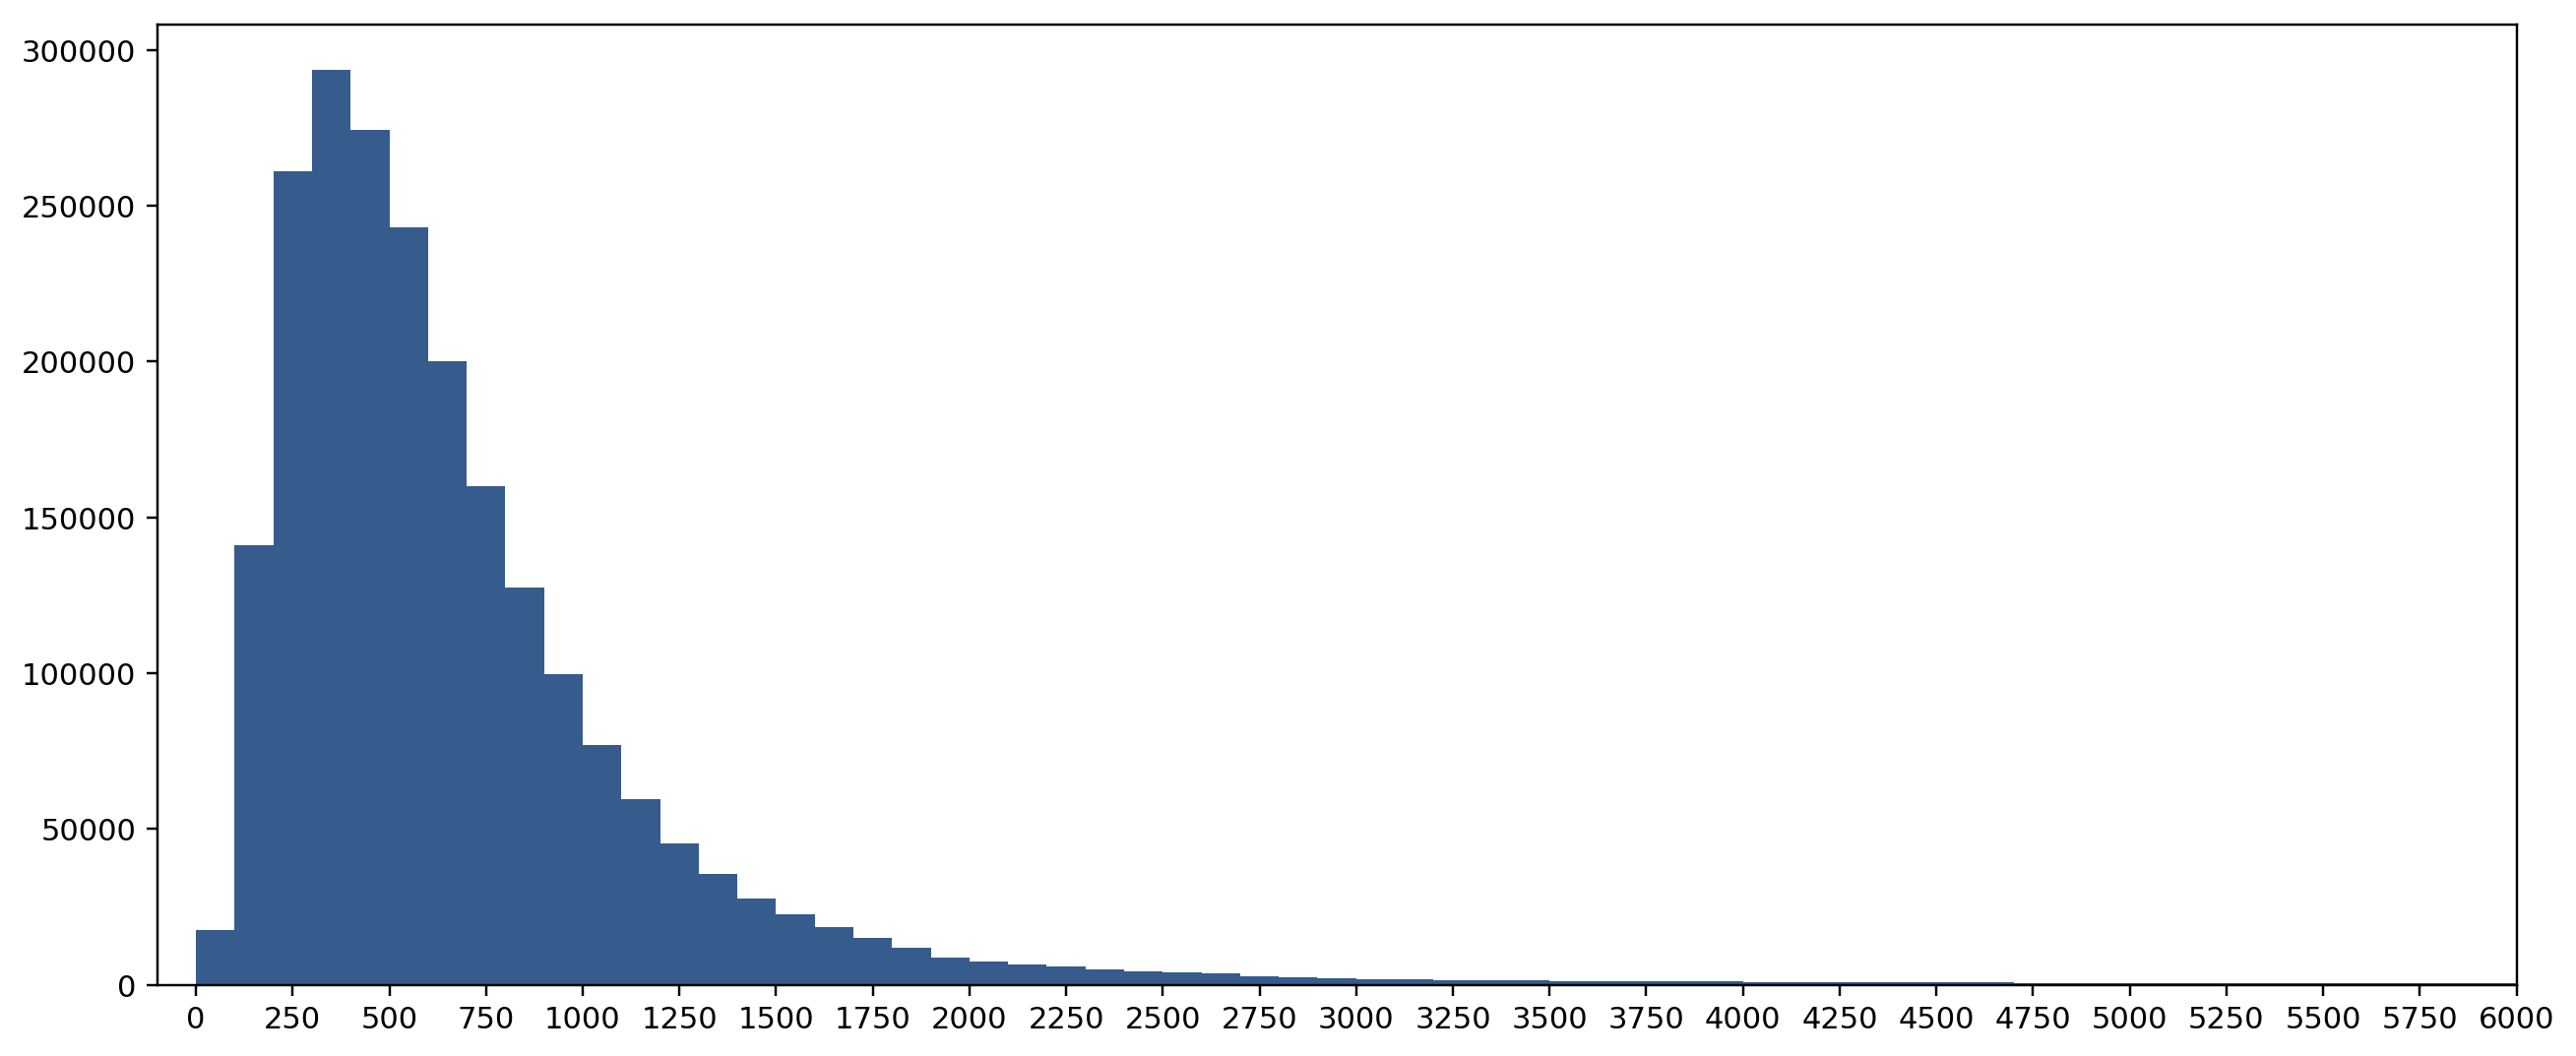

In [337]:
#maybe a customer forgot to log off
bin_size = 100
bins = np.arange(0,df.duration_sec.max()+bin_size,bin_size)

fig, axes = plt.subplots(figsize = (12,5), dpi = 110)

plt.hist(df.duration_sec, bins = bins, color= color);
plt.xticks(ticks = [x for x in range(0,7000,250)])
plt.xlim(-100,6000);
plt.tight_layout()

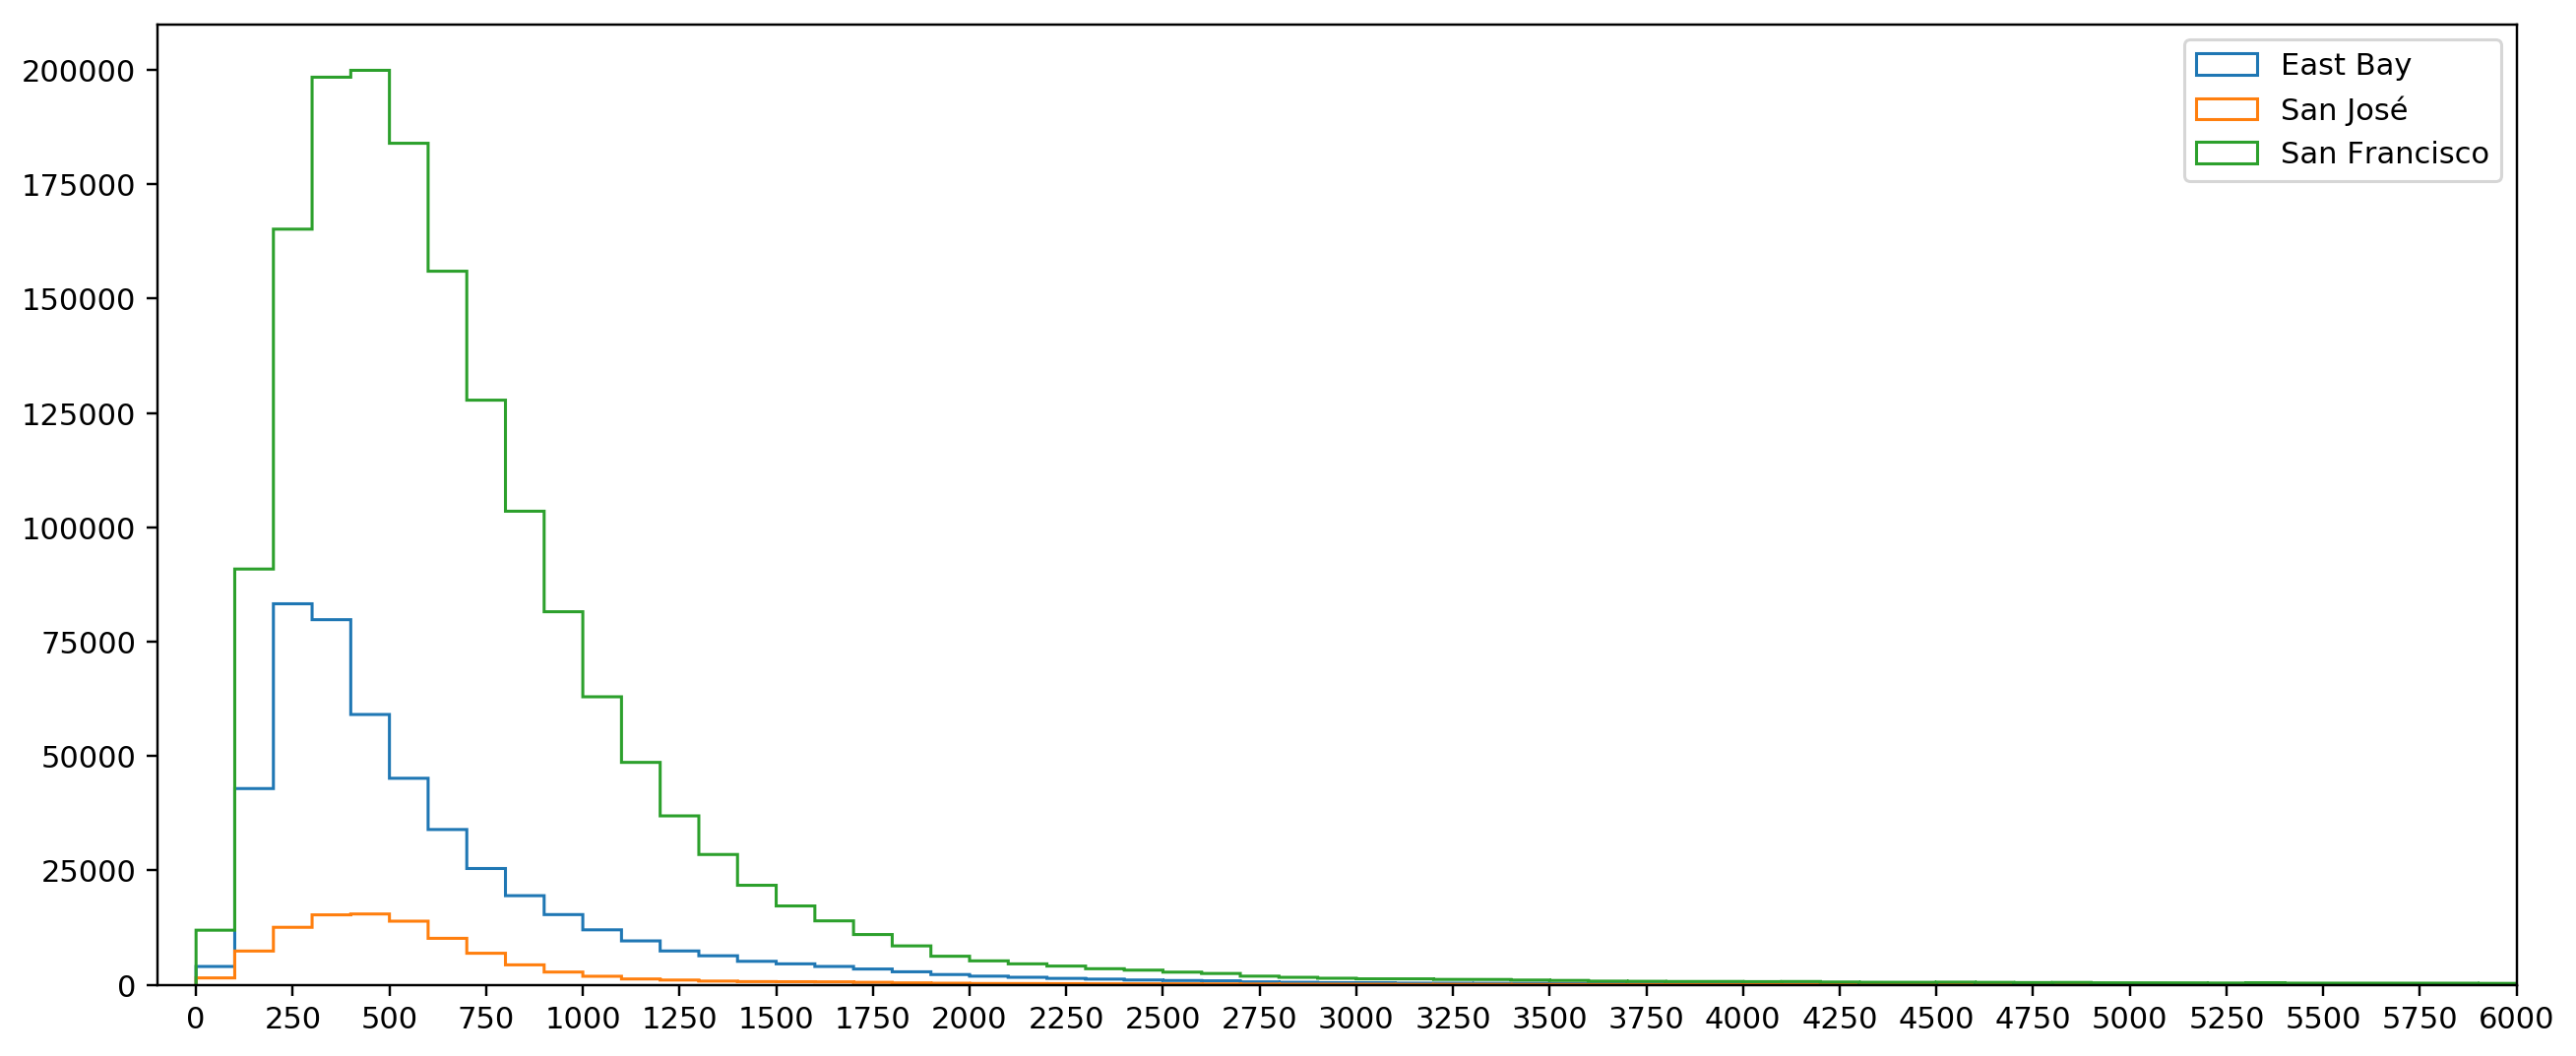

In [338]:
fig, axes = plt.subplots(figsize = (12,5), dpi = 110)
for x in mapping.values():
    df_new = df.query(f"label_name == '{x}'")

    bin_size = 100
    bins = np.arange(0,df_new.duration_sec.max()+bin_size,bin_size)   

    plt.hist(df_new.duration_sec, bins = bins, label = x, histtype='step');
    
plt.xticks(ticks = [x for x in range(0,7000,250)])
plt.legend()
plt.xlim(-100,6000);
plt.tight_layout()

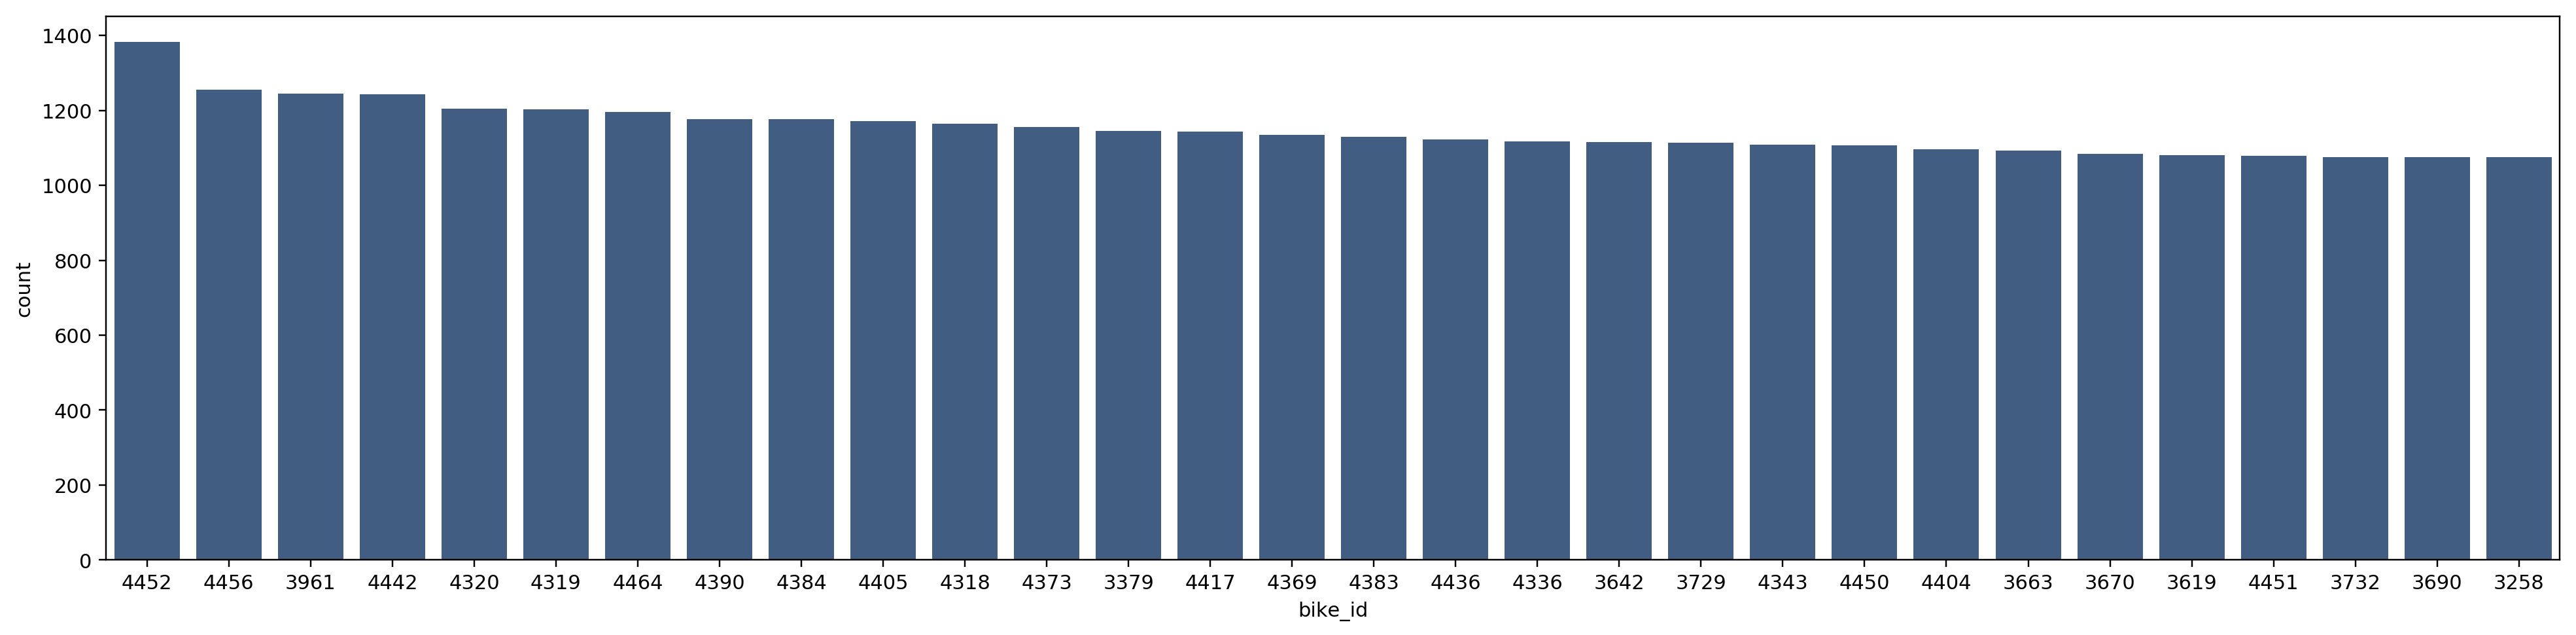

In [339]:
value_ct = df.bike_id.value_counts().iloc[:30]

fig, ax = plt.subplots(figsize = (22,5), dpi = 110)
color = sns.color_palette("viridis")[1]
sns.countplot(x = "bike_id", data = df, order=value_ct.index, color = color);

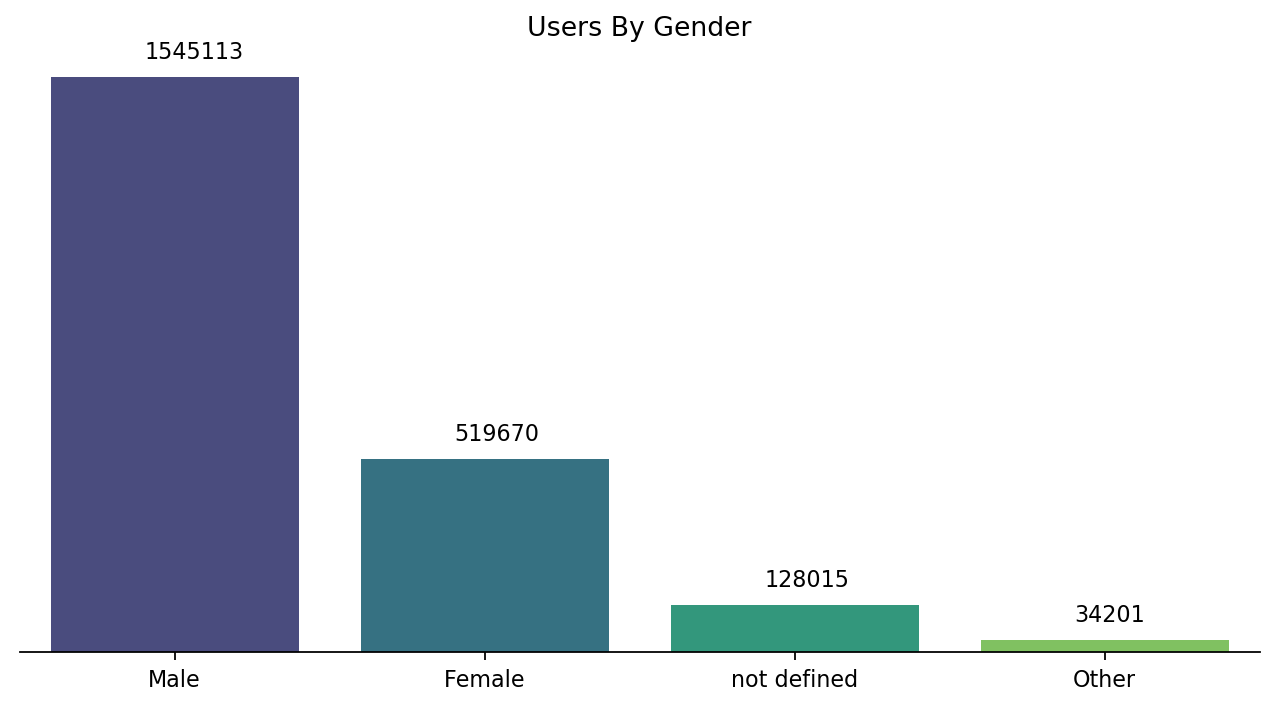

In [340]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
sns.countplot(x = "member_gender", data = df,  order=df.member_gender.value_counts().index, palette = "viridis");

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.303, p.get_height()+50000))

plt.title("Users By Gender");
plt.xlabel("");

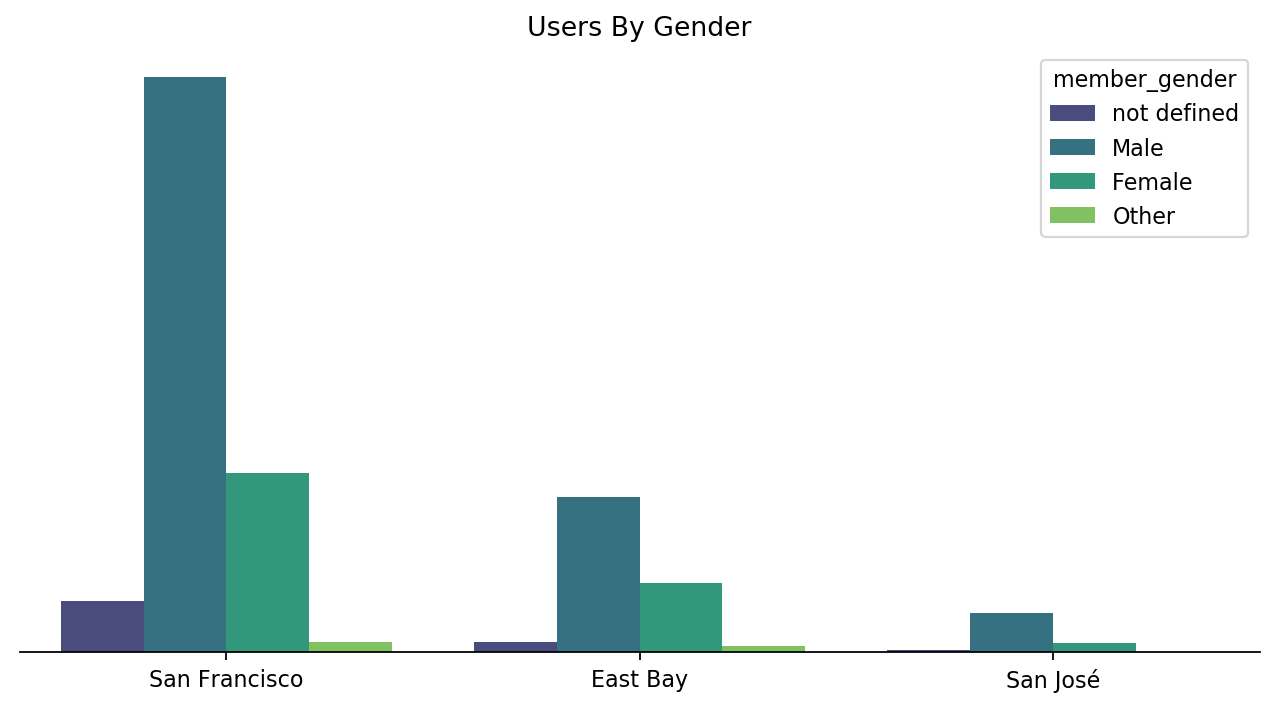

In [341]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
sns.countplot(x = "label_name", data = df,  order=df.label_name.value_counts().index, palette = "viridis", hue = "member_gender");

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
sns.despine(fig, left = True)

#for p in ax.patches:
 #   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+50000))

plt.title("Users By Gender");
plt.xlabel("");

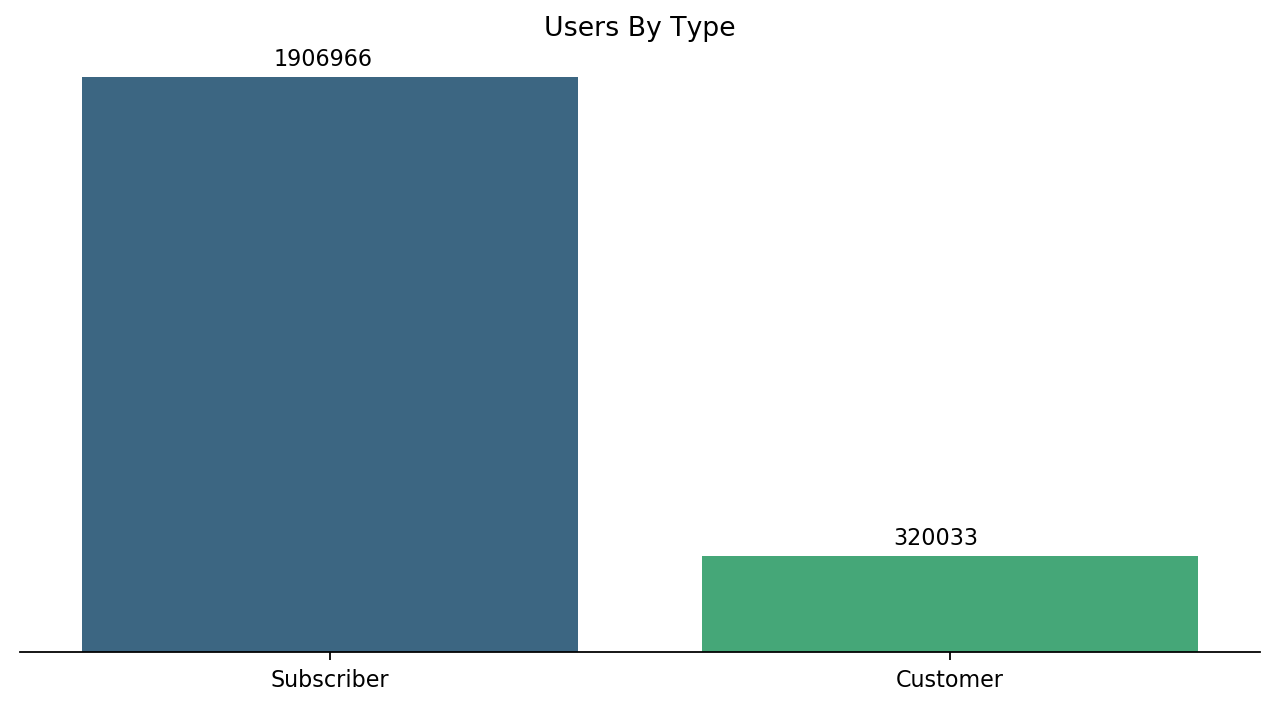

In [342]:
value_ct = df.user_type.value_counts().iloc[:31]

fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
sns.countplot(x = "user_type", data = df, order=value_ct.index, palette = "viridis");

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.31, p.get_height()+40000))

plt.title("Users By Type");
plt.xlabel("");

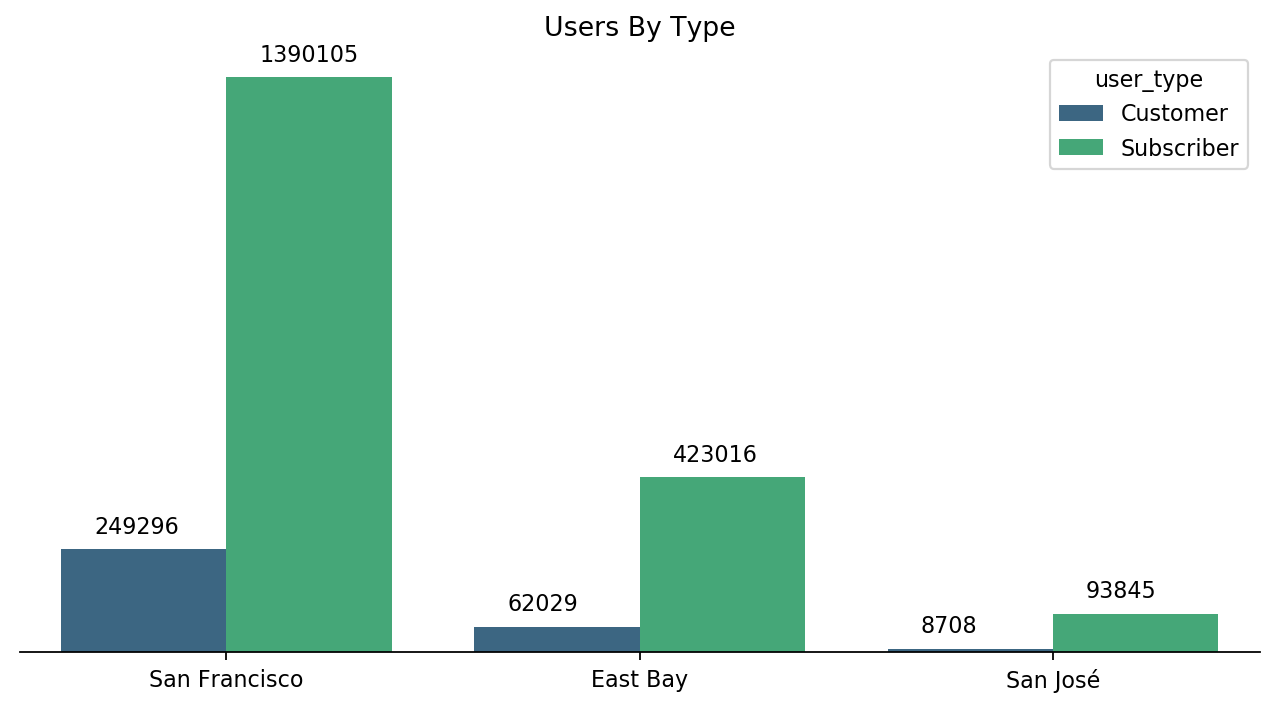

In [343]:
value_ct = df.label_name.value_counts().iloc[:31]

fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
sns.countplot(x = "label_name", data = df, order=value_ct.index, palette = "viridis", hue = "user_type");

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
sns.despine(fig, left = True)

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.08, p.get_height()+40000))

plt.title("Users By Type");
plt.xlabel("");

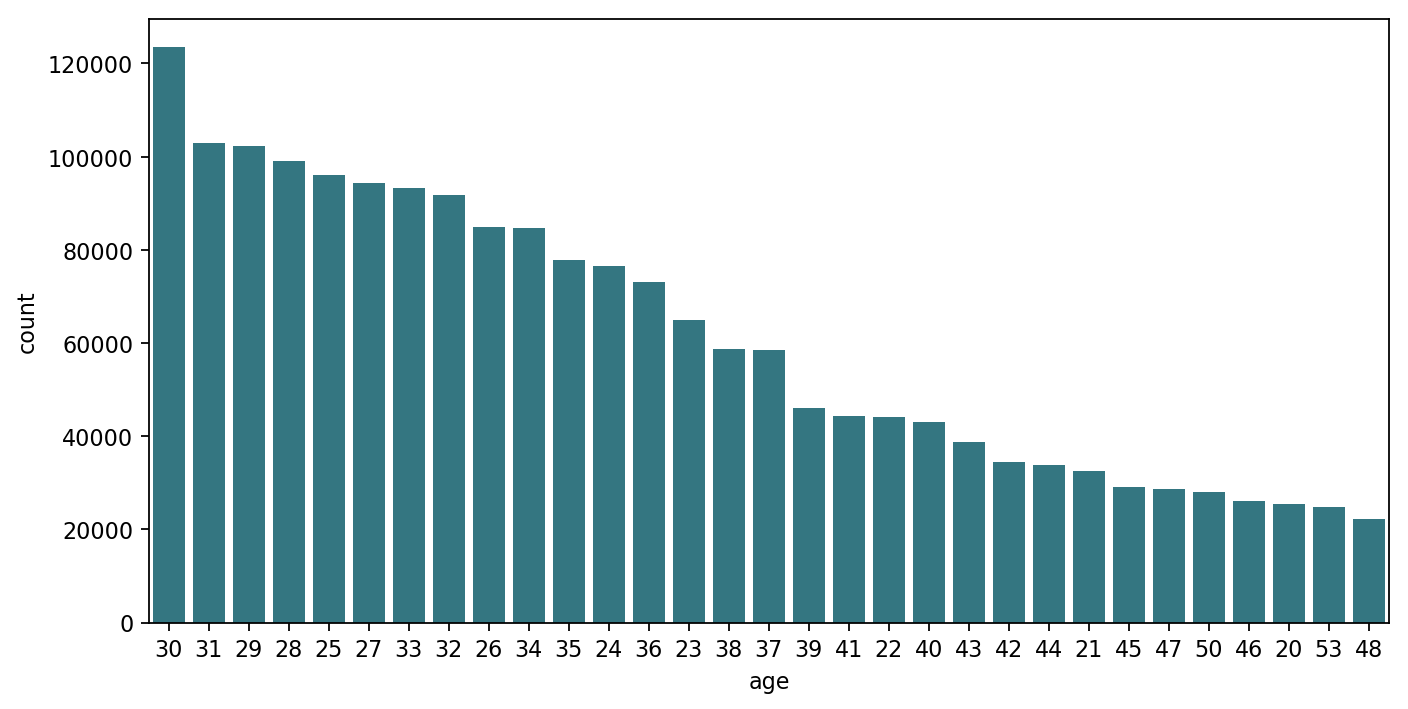

In [344]:
value_ct = df.query("age != 2018").age.value_counts().iloc[:31]

fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
color = sns.color_palette("viridis")[2]
sns.countplot(x = "age", data = df.query("age != 2018"), order=value_ct.index, color = color);

In [345]:
df.query("age != 2018").age.mean()

34.69976603784374

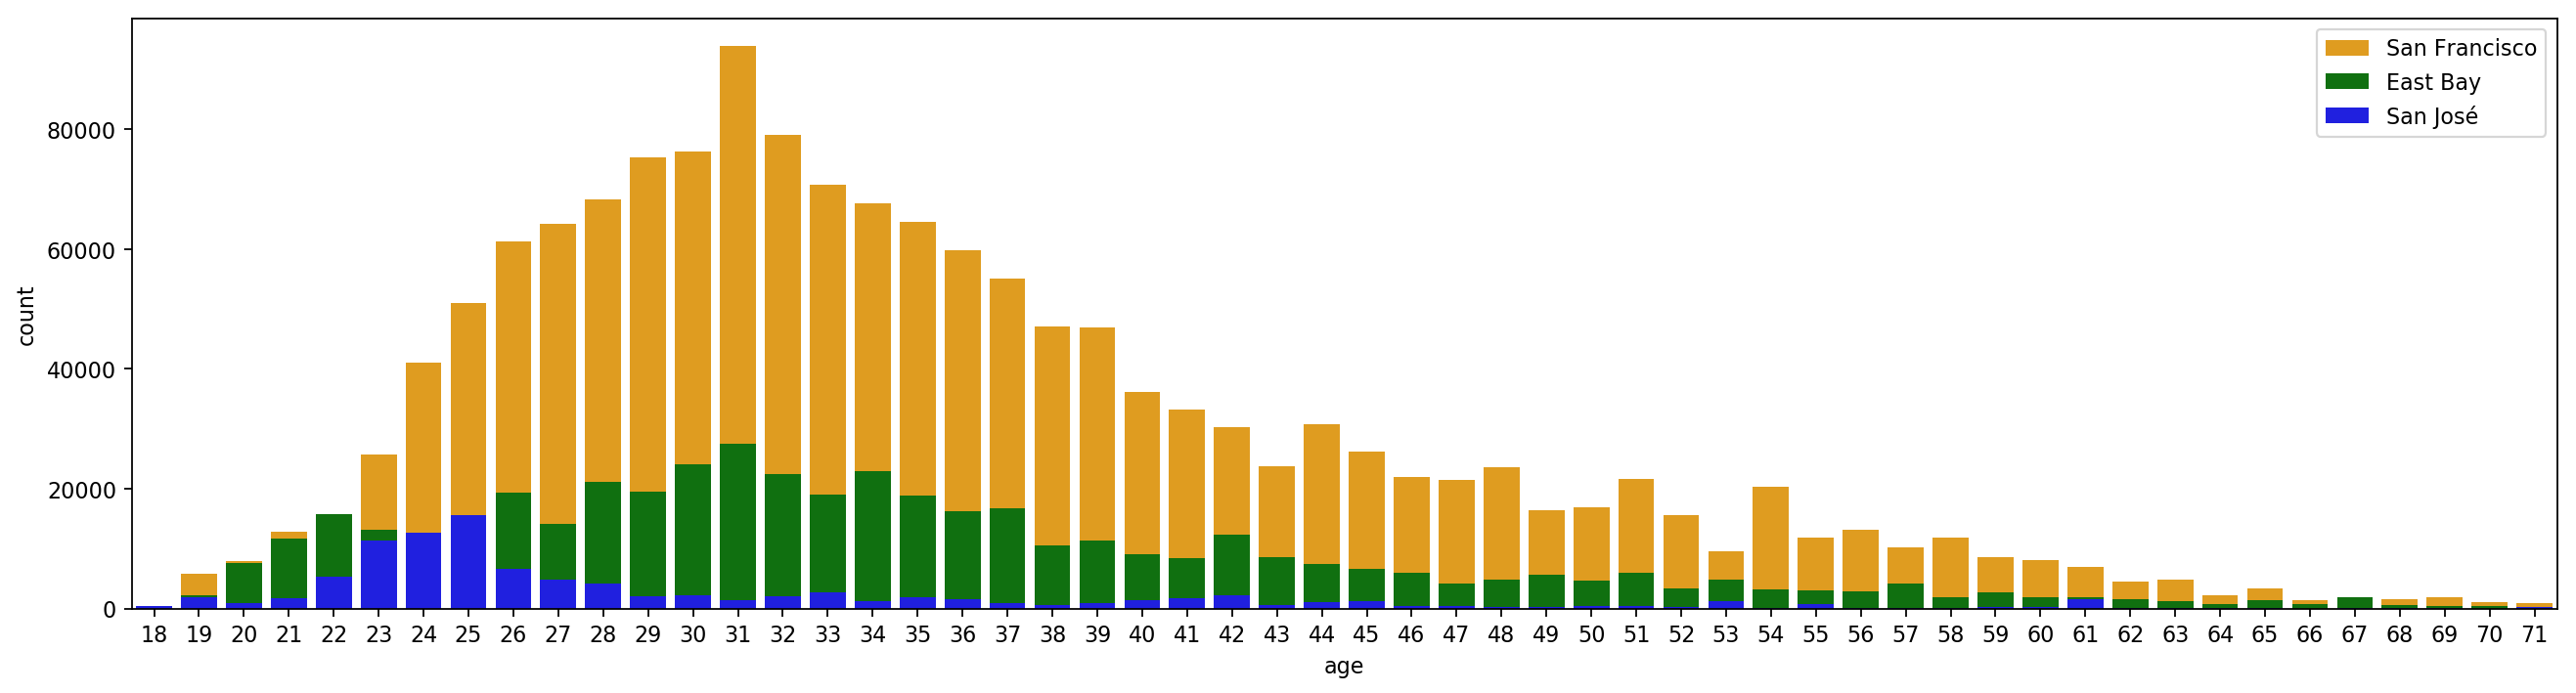

In [401]:
fig, ax = plt.subplots(figsize = (20,5), dpi = 80)
color = sns.color_palette("viridis")[2]
sns.countplot(x = "age", data = df.query("age != 2018 and age < 73 and label == 2").sort_values("age"), color = 'orange', label = "San Francisco");
sns.countplot(x = "age", data = df.query("age != 2018 and age < 73 and label == 0").sort_values("age"), color = 'g', label = "East Bay");
sns.countplot(x = "age", data = df.query("age != 2018 and age < 73 and label == 1").sort_values("age"), color = 'b', label = "San José");
plt.legend();

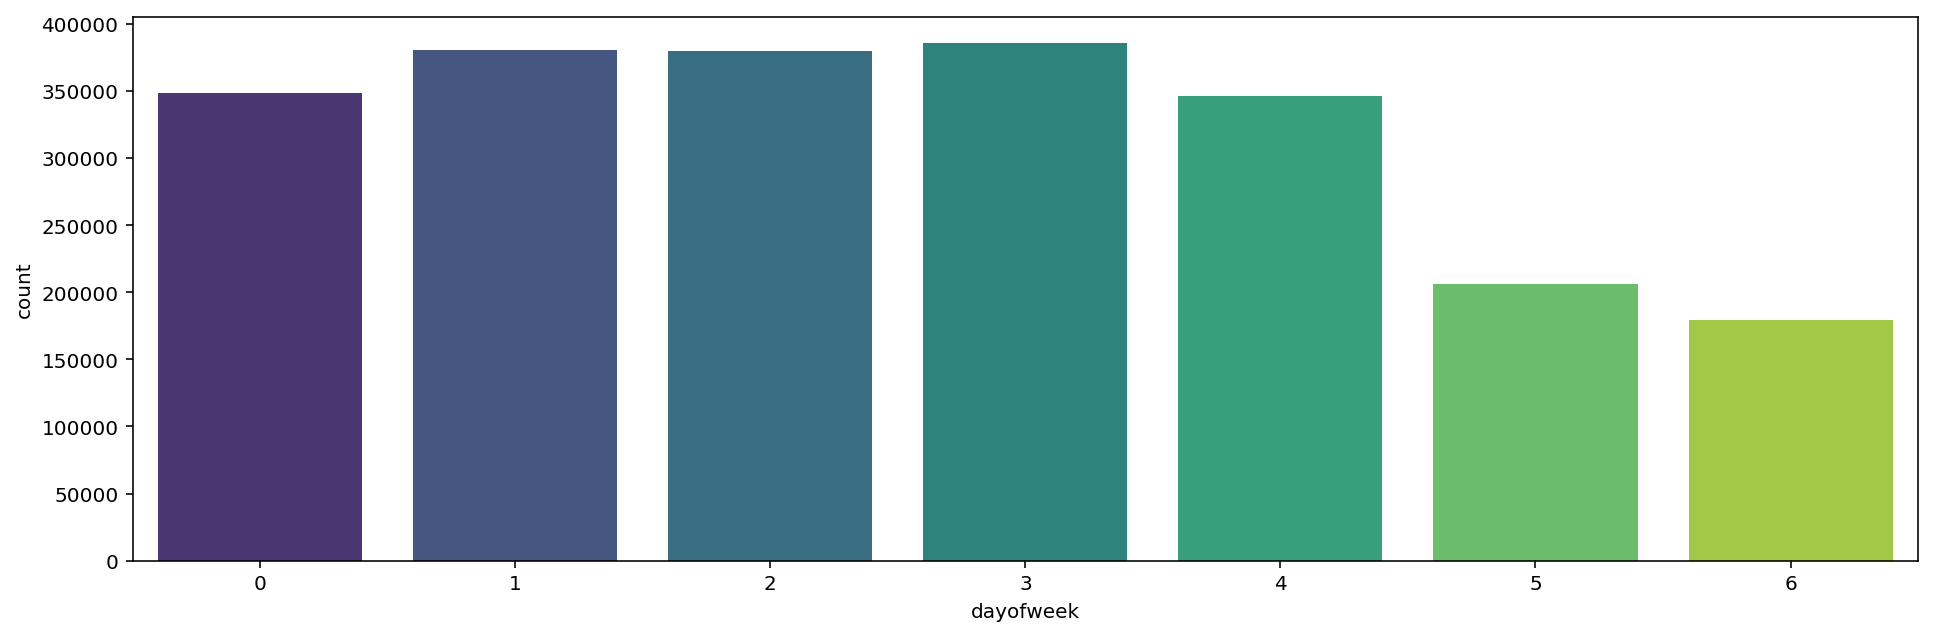

In [347]:
fig, ax = plt.subplots(figsize = (16,5))
sns.countplot(x = "dayofweek", data = df, palette = "viridis");

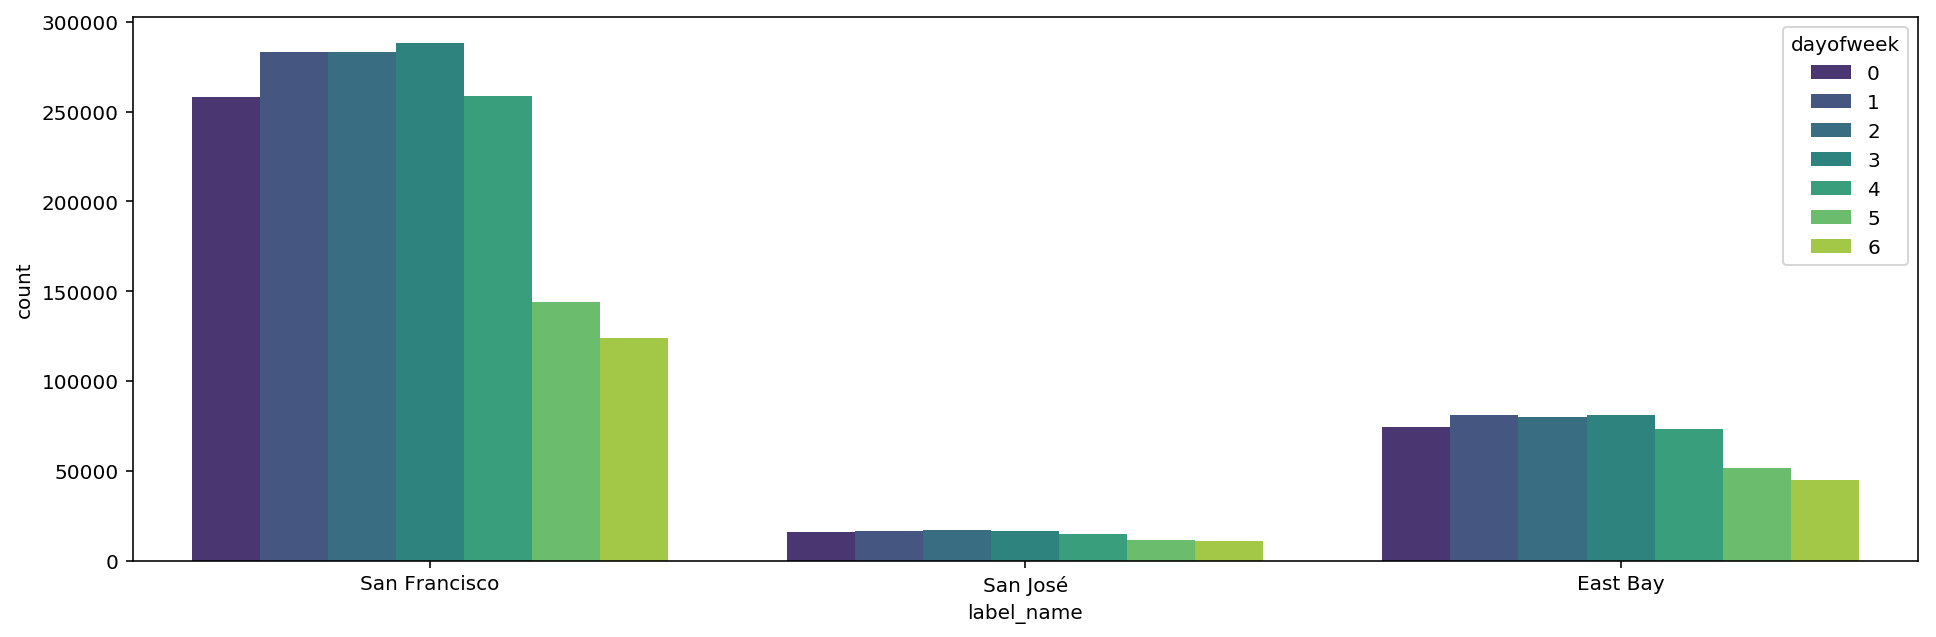

In [348]:
fig, ax = plt.subplots(figsize = (16,5))
sns.countplot(x = "label_name", data = df, palette = "viridis", hue = "dayofweek");

In [349]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,end_station_id_new,new_id,label,age,month_year,day_month_year,dayofweek,start_hr,end_hr,label_name
0,13709,2018-01-01 00:01:53.847,2018-01-01 03:50:23.433,86,Market St at Dolores St,37.769305,-122.426826,119,18th St at Noe St,37.761047,...,119_0,86_0,2,2018,2018-01,2018-01-01,0,0,3,San Francisco
1,9996,2018-01-01 04:37:08.115,2018-01-01 07:23:44.143,86,Market St at Dolores St,37.769305,-122.426826,223,16th St Mission BART Station 2,37.764765,...,223_0,86_0,2,2018,2018-01,2018-01-01,0,4,7,San Francisco
2,197,2018-01-01 09:29:57.079,2018-01-01 09:33:14.662,86,Market St at Dolores St,37.769305,-122.426826,85,Church St at Duboce Ave,37.770083,...,85_0,86_0,2,61,2018-01,2018-01-01,0,9,9,San Francisco
3,183,2018-01-01 11:25:27.634,2018-01-01 11:28:31.059,86,Market St at Dolores St,37.769305,-122.426826,75,Market St at Franklin St,37.773793,...,75_0,86_0,2,31,2018-01,2018-01-01,0,11,11,San Francisco
4,893,2018-01-01 12:07:39.271,2018-01-01 12:22:32.393,86,Market St at Dolores St,37.769305,-122.426826,42,San Francisco City Hall (Polk St at Grove St),37.778650,...,42_0,86_0,2,2018,2018-01,2018-01-01,0,12,12,San Francisco


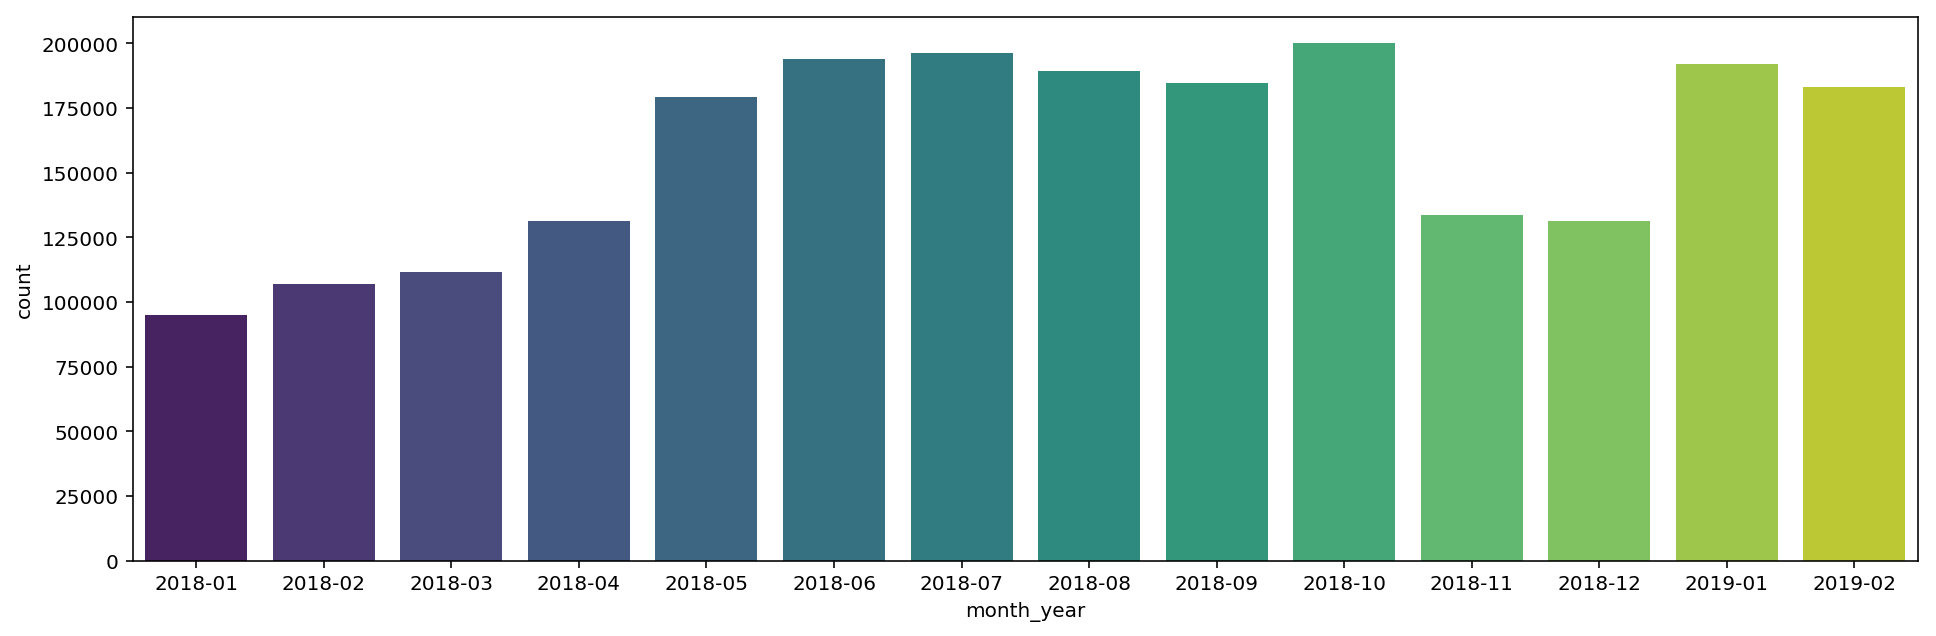

In [350]:
fig, ax = plt.subplots(figsize = (16,5))
sns.countplot(x = "month_year", data = df, palette = "viridis");

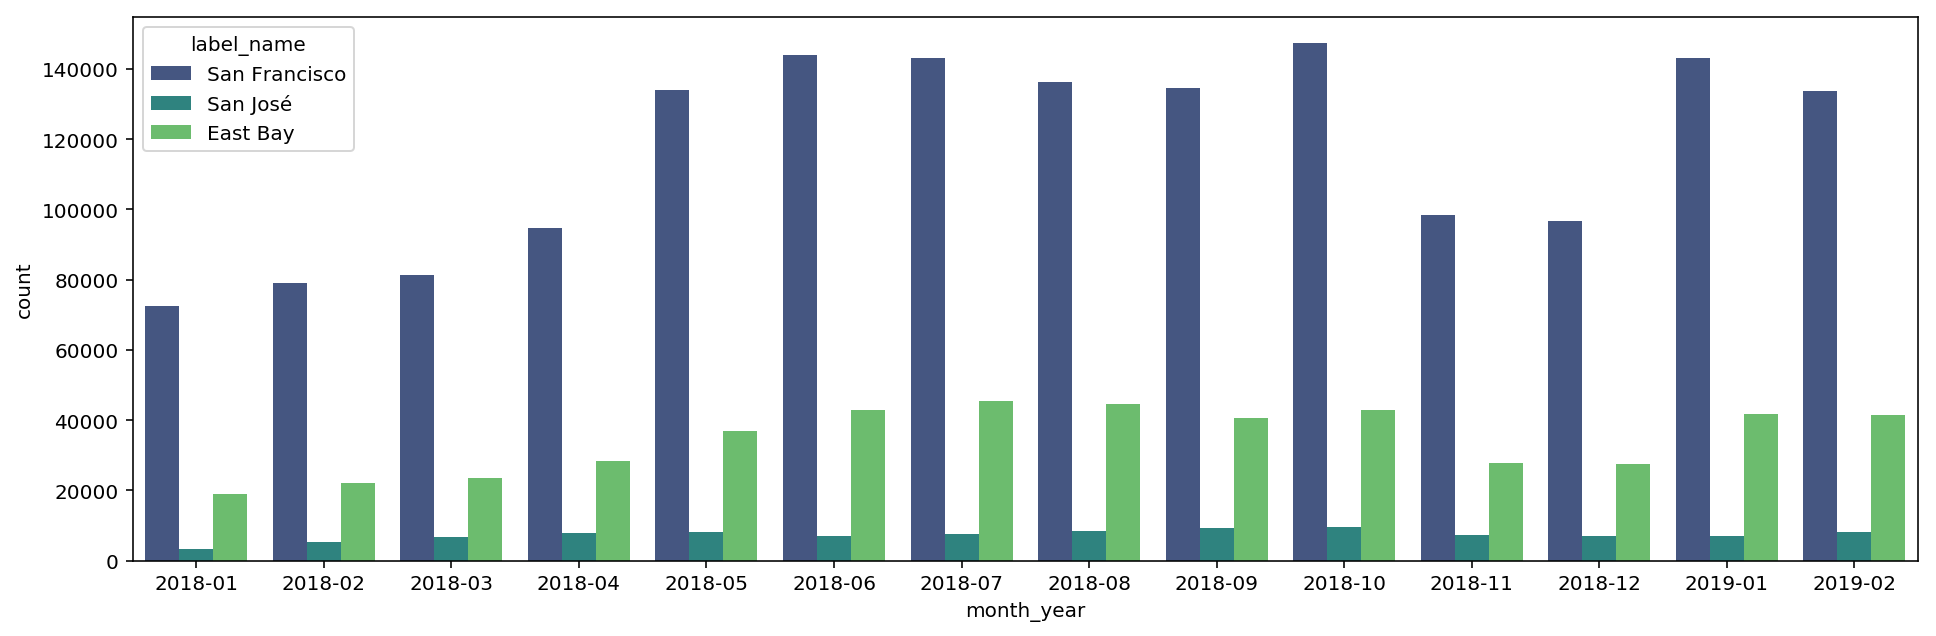

In [351]:
fig, ax = plt.subplots(figsize = (16,5))
sns.countplot(x = "month_year", data = df, palette = "viridis", hue = "label_name");

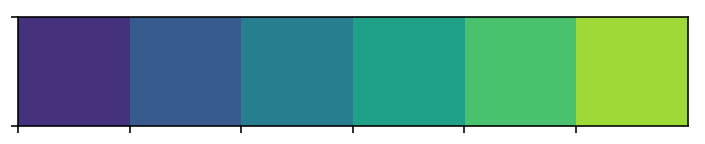

In [352]:
#https://seaborn.pydata.org/generated/seaborn.color_palette.html
sns.palplot(sns.color_palette("viridis"))

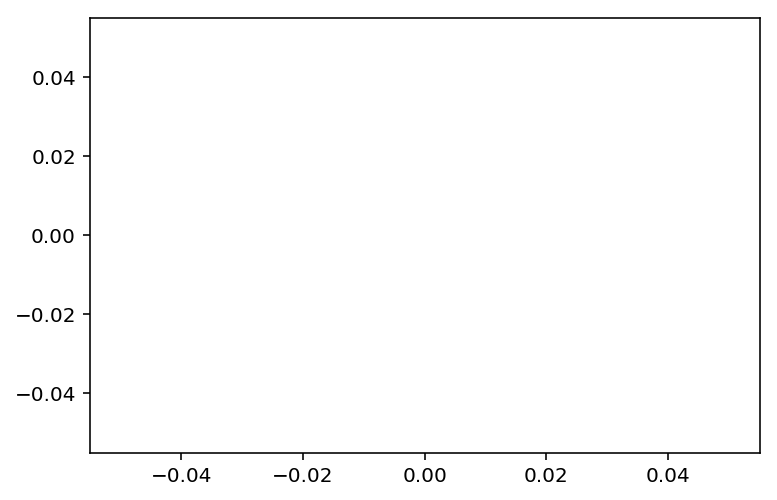

In [353]:
#https://stackoverflow.com/questions/35143672/seaborn-conditional-colors-based-on-value

custom_palette = {}
for q in set(df.day_month_year):
    if q.dayofweek == 0:
        custom_palette[q] = sns.color_palette("viridis")[0]
    elif q.dayofweek == 1:
        custom_palette[q] = sns.color_palette("viridis")[1]
    elif q.dayofweek == 2:
        custom_palette[q] = sns.color_palette("viridis")[2]
    elif q.dayofweek == 3:
        custom_palette[q] = sns.color_palette("viridis")[3]
    elif q.dayofweek == 4:
        custom_palette[q] = sns.color_palette("viridis")[4]
    elif q.dayofweek == 5:
        custom_palette[q] = sns.color_palette("viridis")[5]
    elif q.dayofweek == 6:
        custom_palette[q] = (224/255, 228/255, 65/255)
    else:
        custom_palette[q] = 'g'
        
legend_obj = []

colors = [sns.color_palette("viridis")[0],
          sns.color_palette("viridis")[1],
          sns.color_palette("viridis")[2],
          sns.color_palette("viridis")[3],
          sns.color_palette("viridis")[4],
          sns.color_palette("viridis")[5],
          (224/255, 228/255, 65/255)]

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for i, s in enumerate(days):
    legend_obj.append(plt.scatter([],[],color = colors[i]));  

In [354]:
#https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
def plot_data_time(start_date="12.31.17", end_date="03.01.18"):
    fig, ax = plt.subplots(figsize = (30,5), dpi = 100)
    sns.countplot(x = "day_month_year", data = df[(df["start_time"] < pd.to_datetime(end_date)) & (df["start_time"] > pd.to_datetime(start_date))], palette = custom_palette);
    plt.xticks(rotation = 90);
    plt.ylim(0,10000);
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(legend_obj, days, loc='center left', bbox_to_anchor=(1, 0.5))

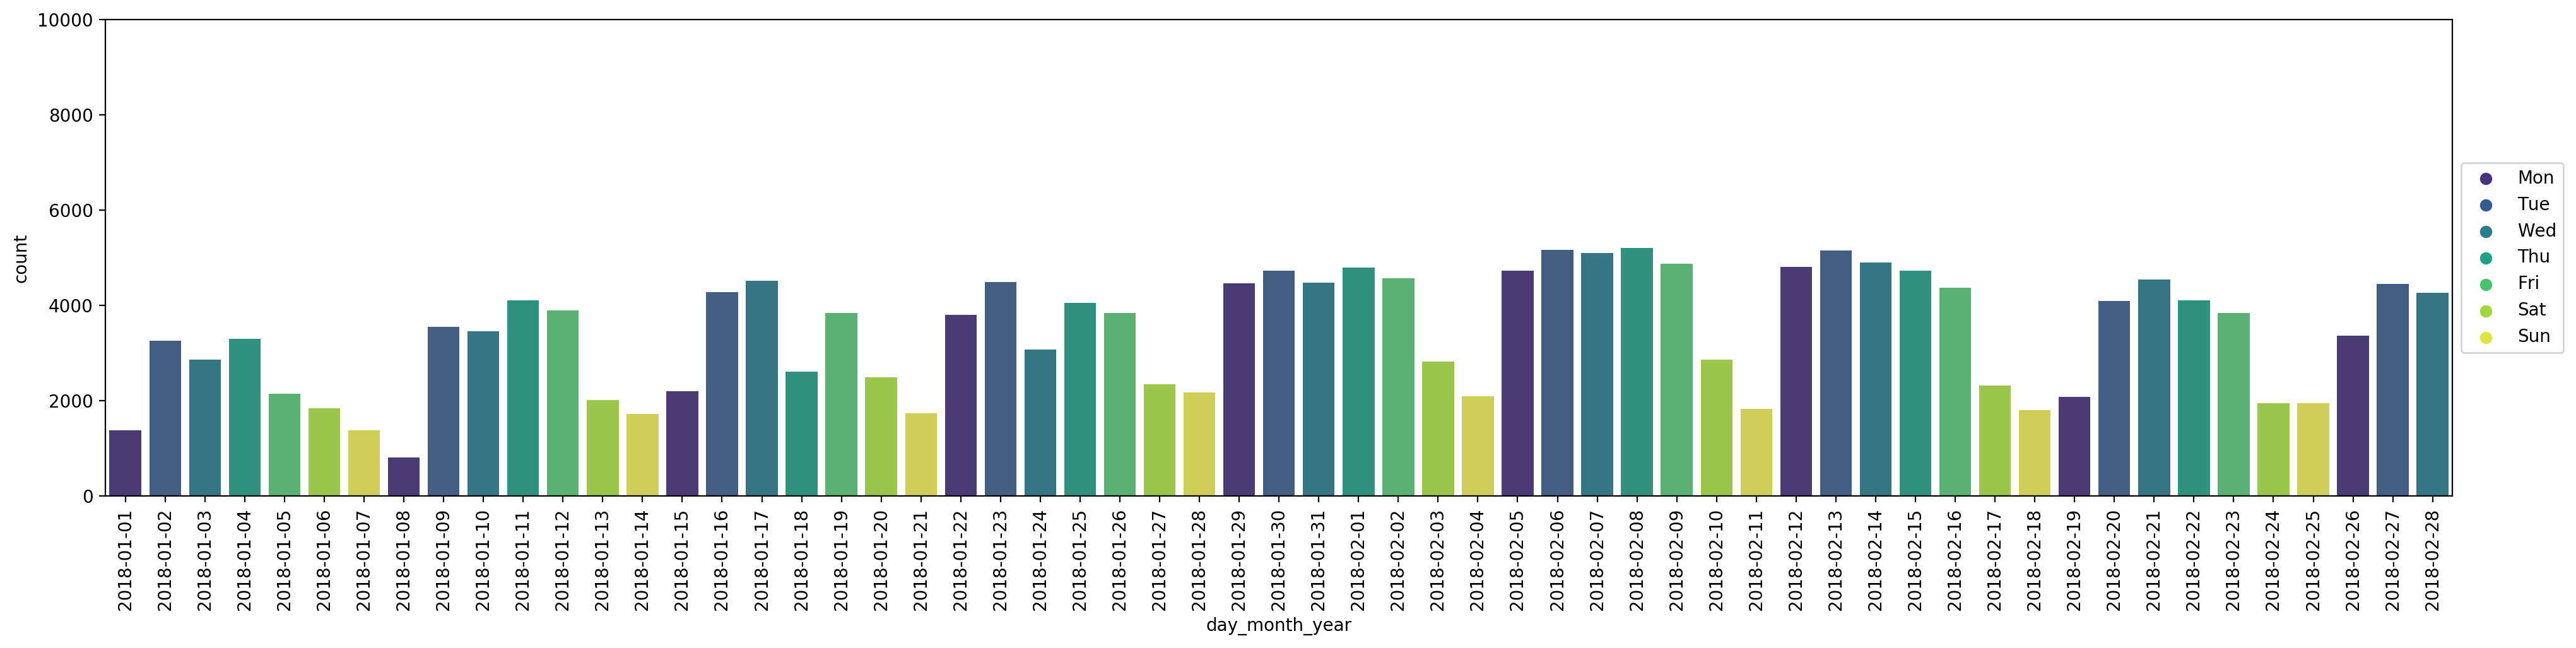

In [355]:
plot_data_time()

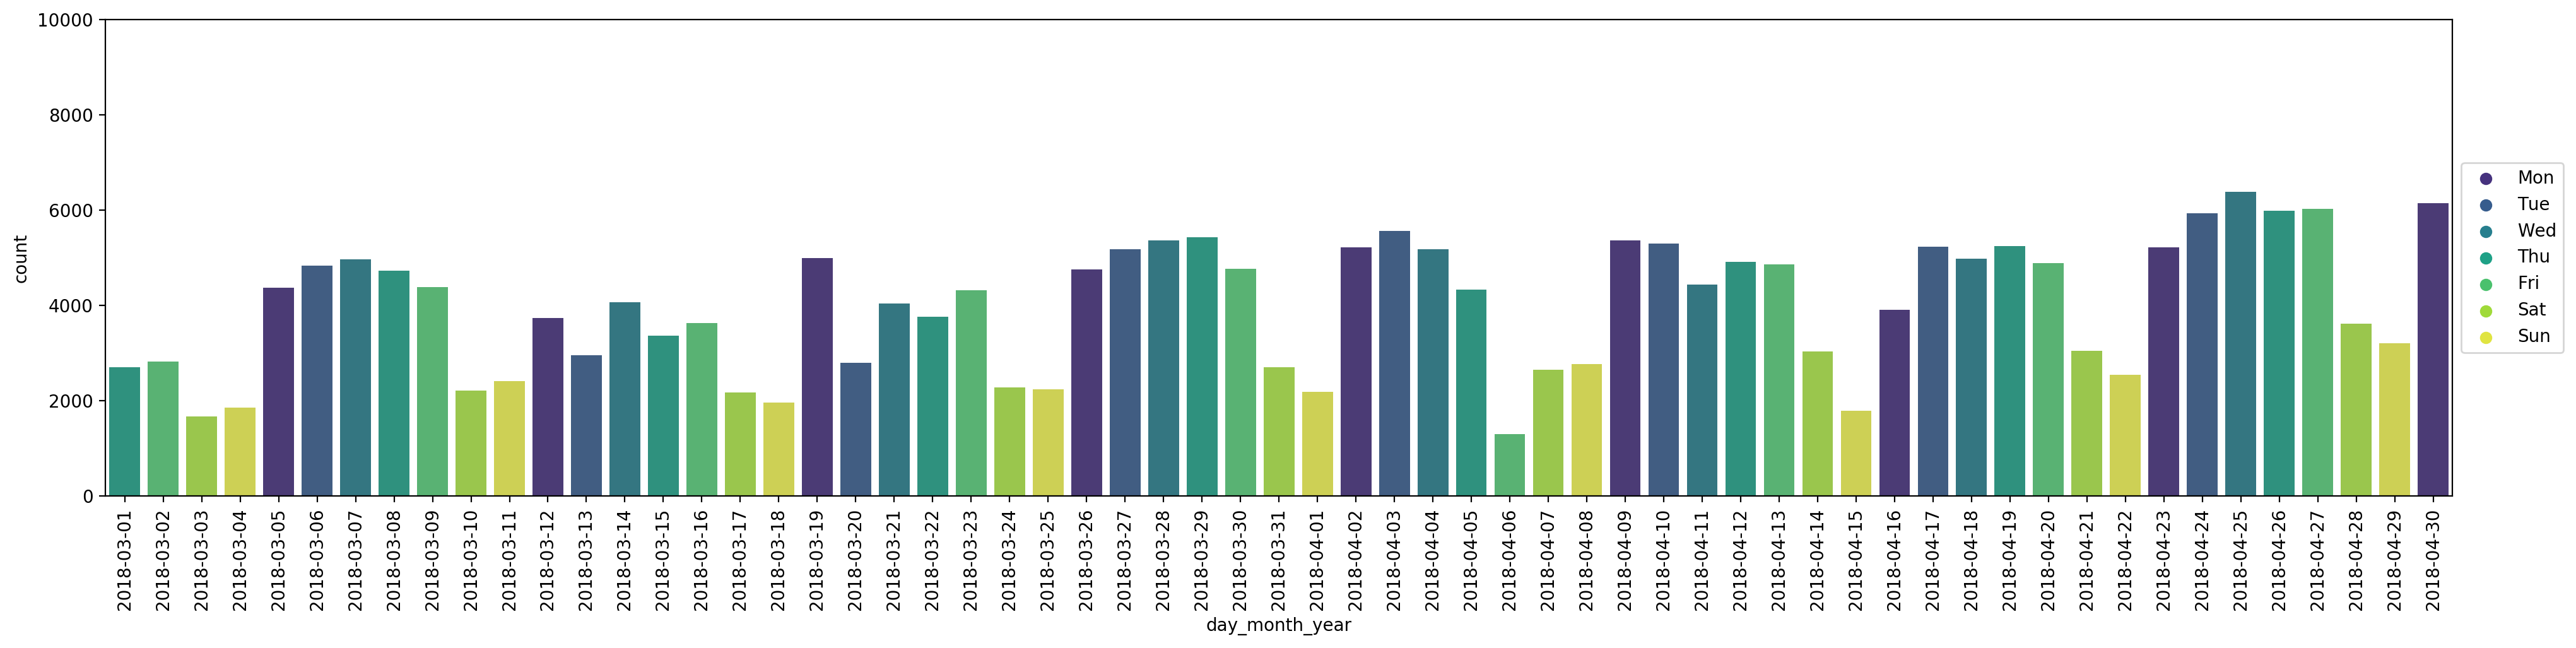

In [356]:
plot_data_time("03.01.18","05.01.18")

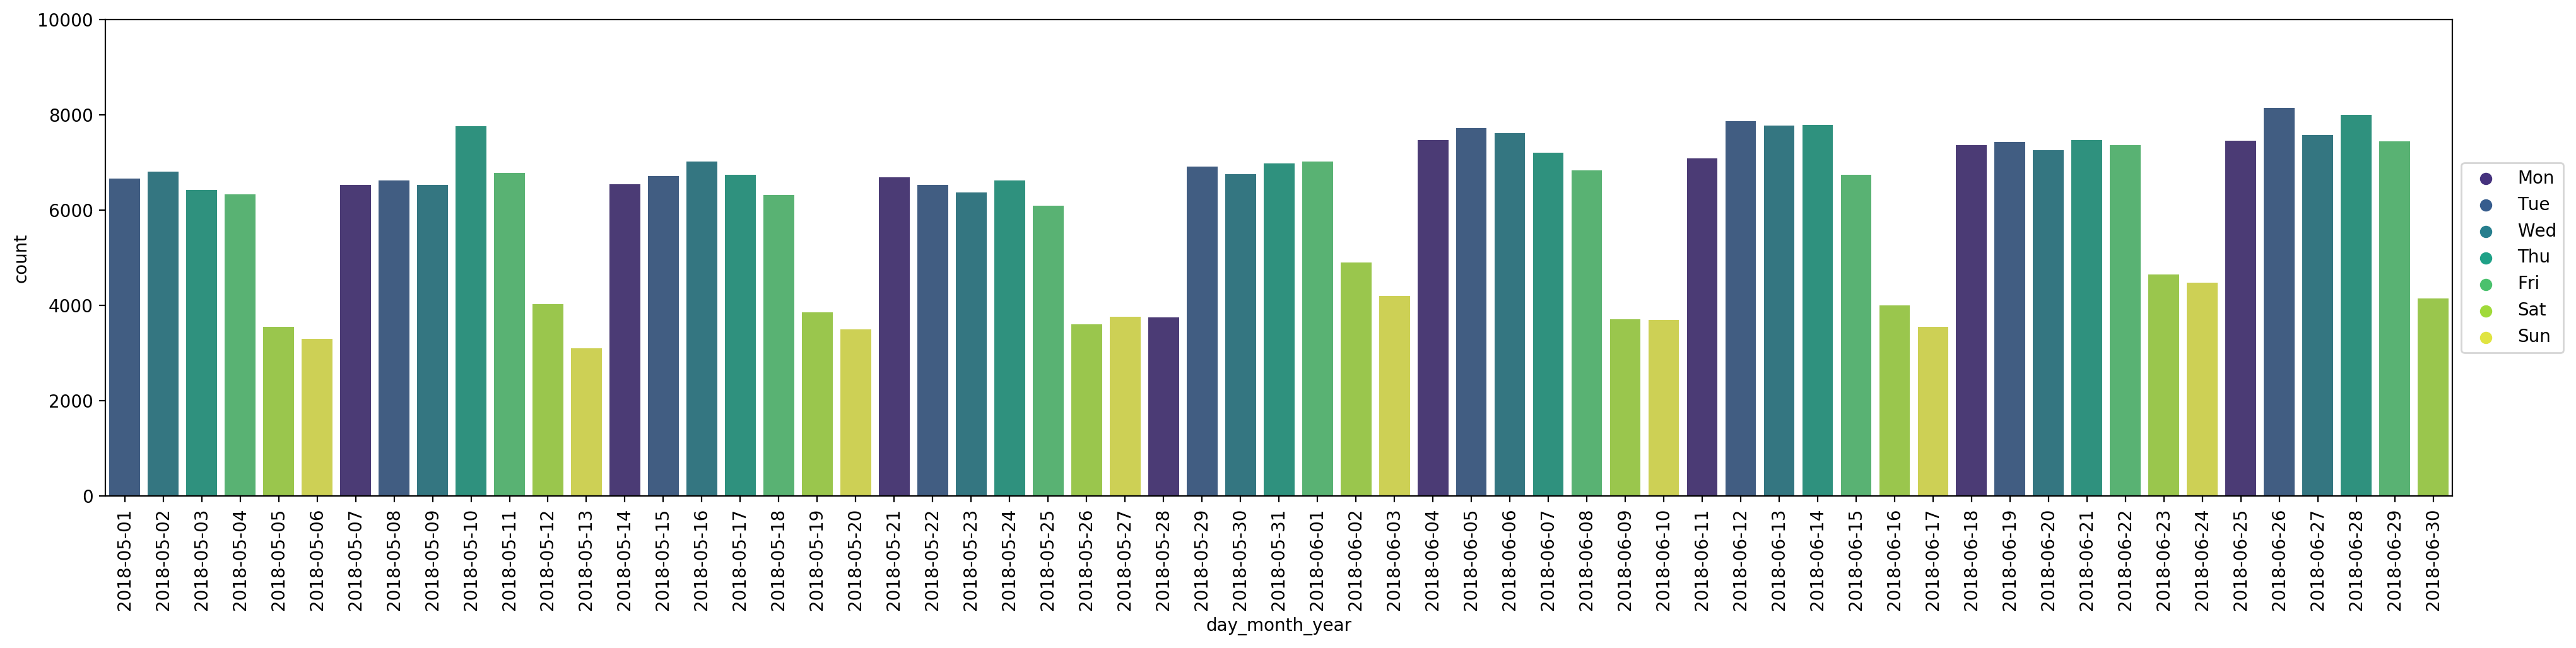

In [357]:
plot_data_time("05.01.18","07.01.18")

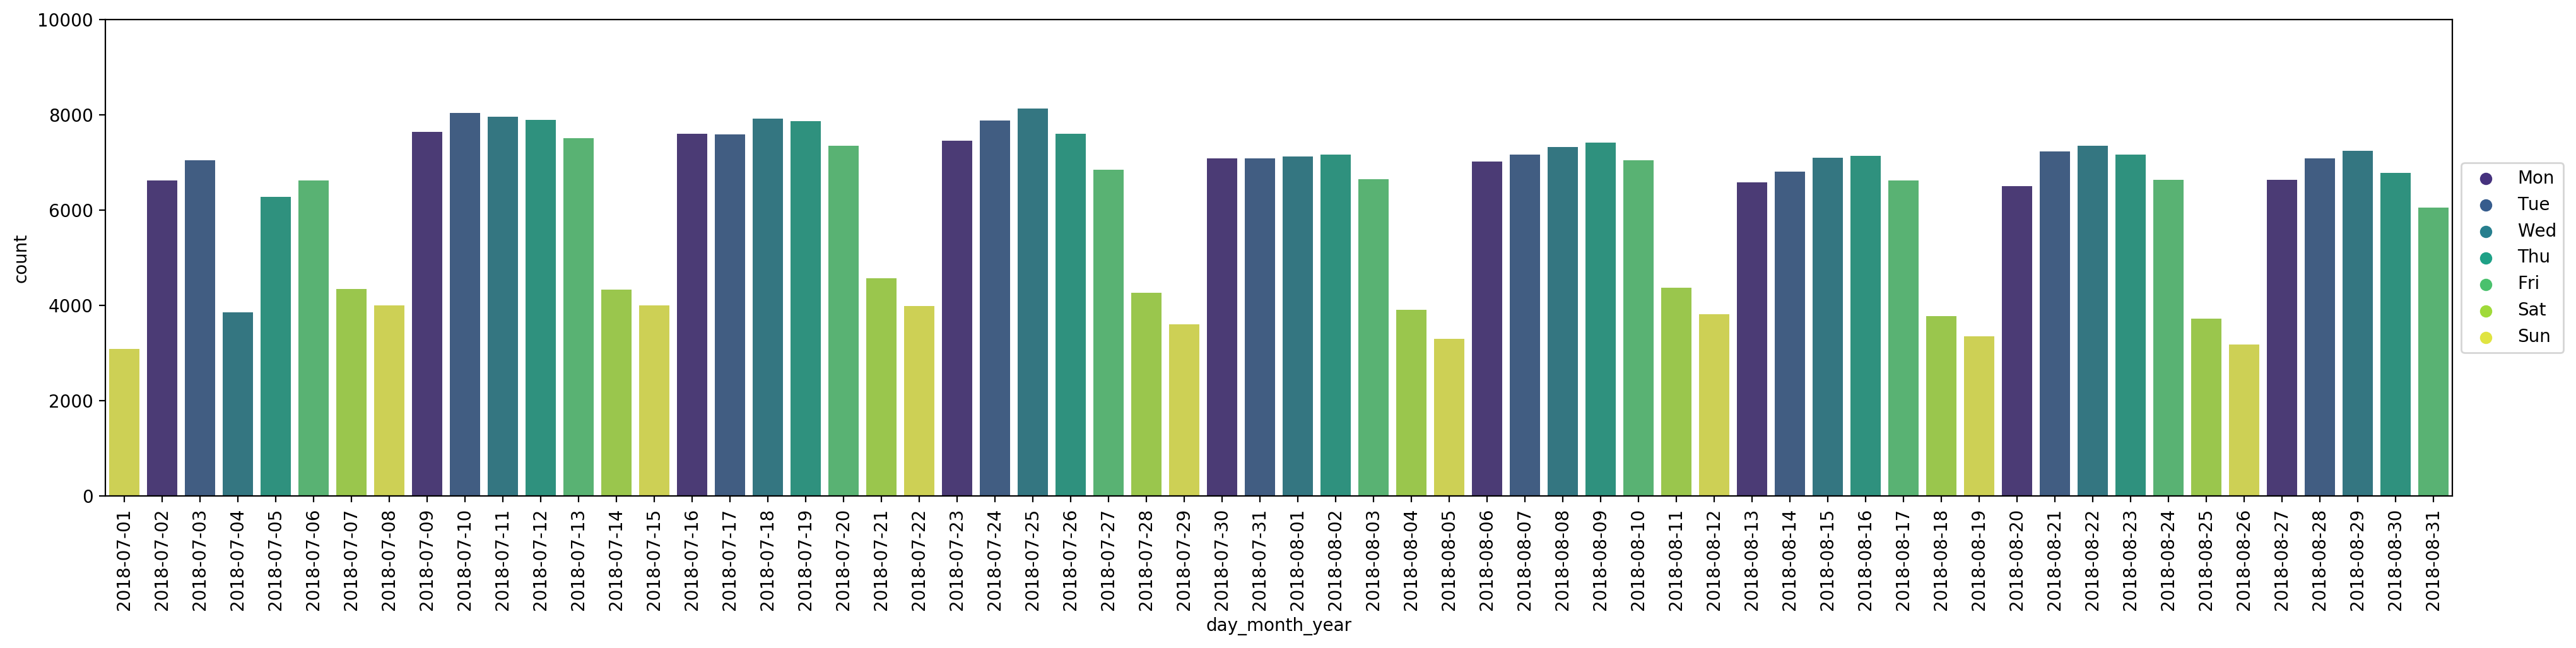

In [358]:
plot_data_time("07.01.18","09.01.18")

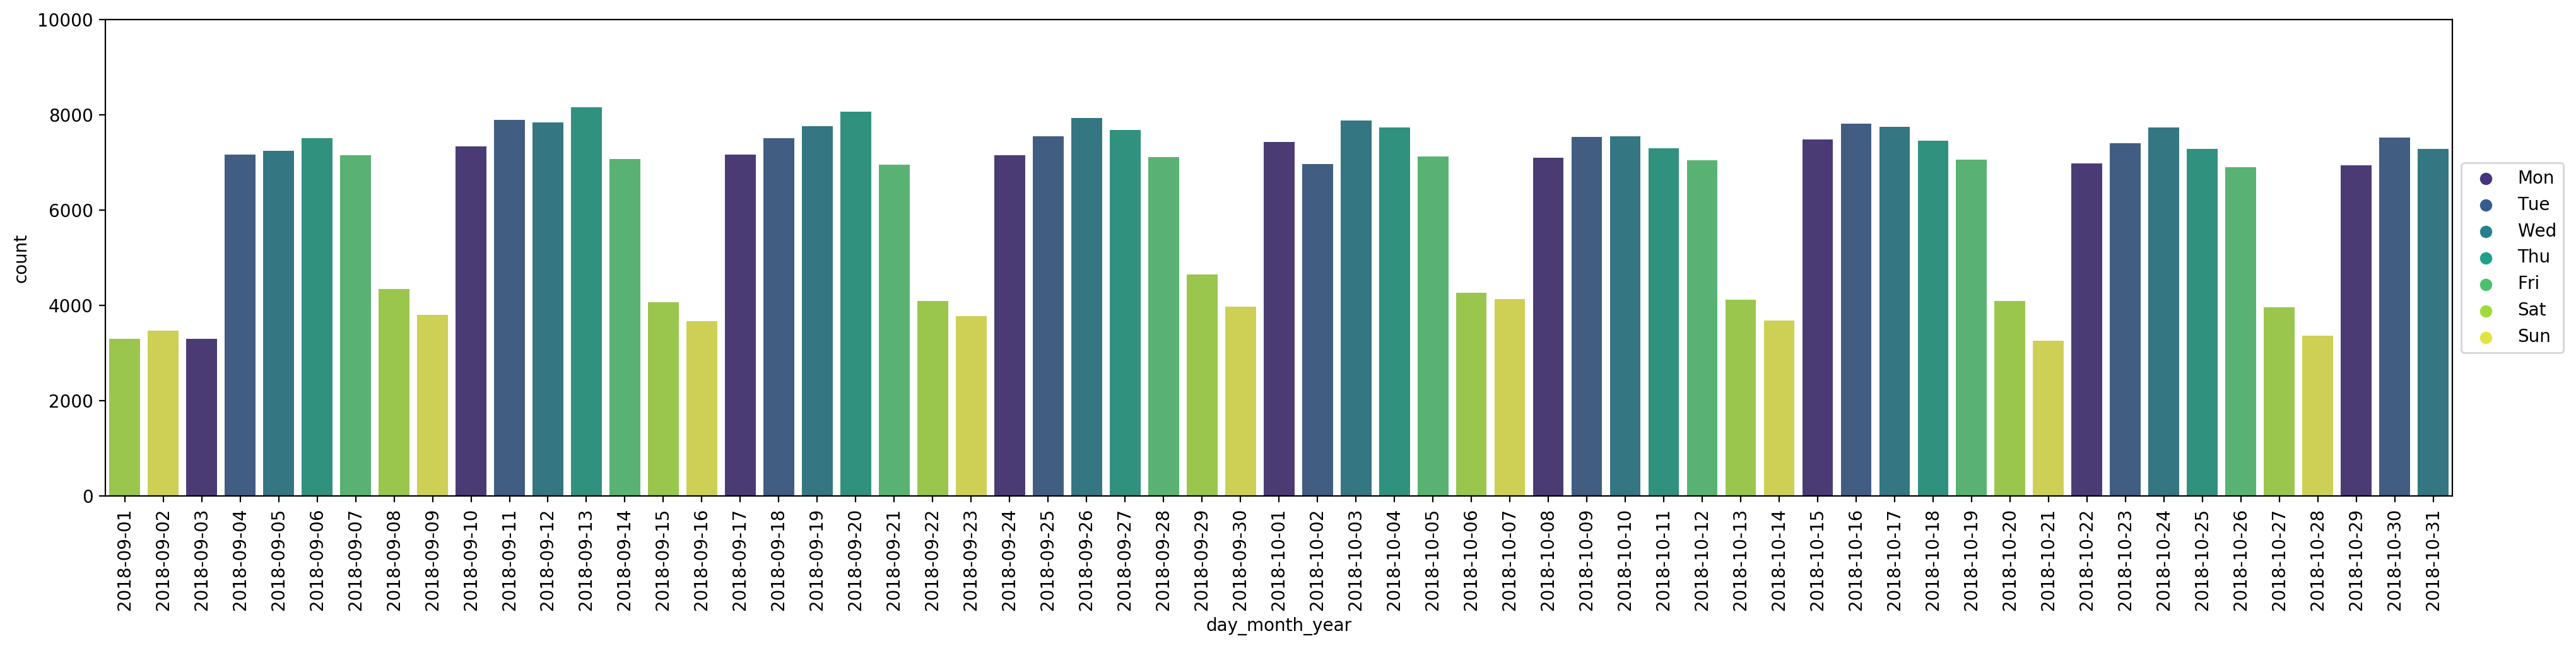

In [359]:
plot_data_time("09.01.18","11.01.18")

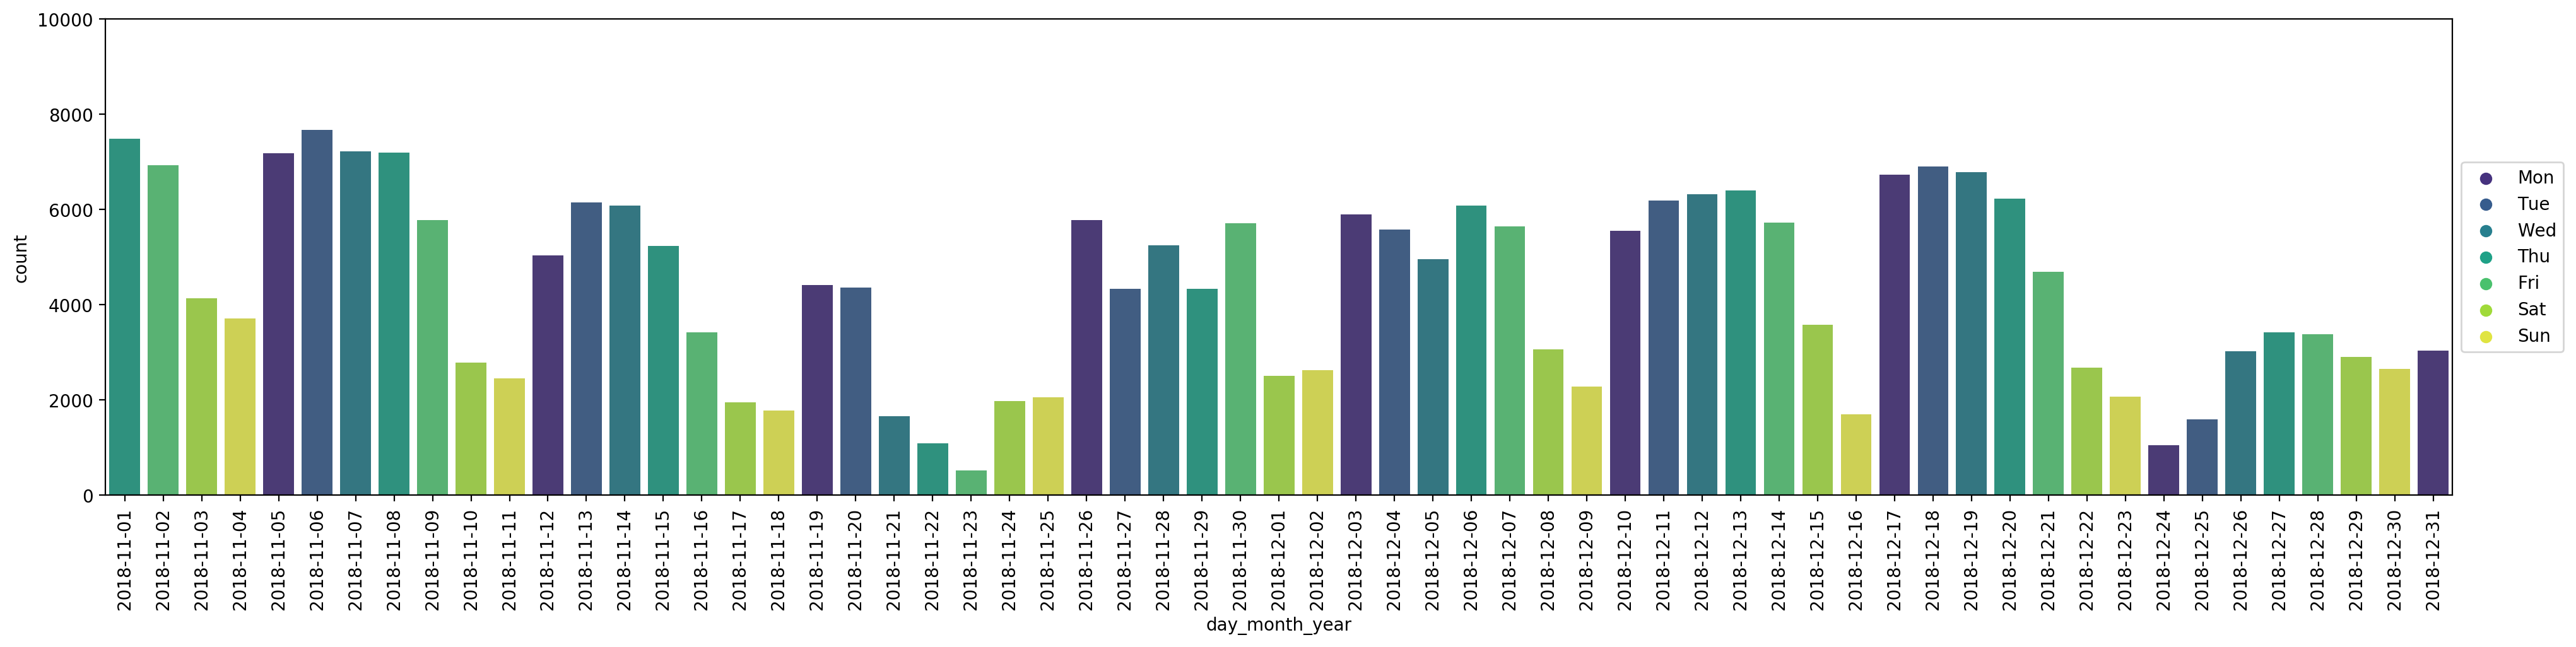

In [360]:
plot_data_time("11.01.18","01.01.19")

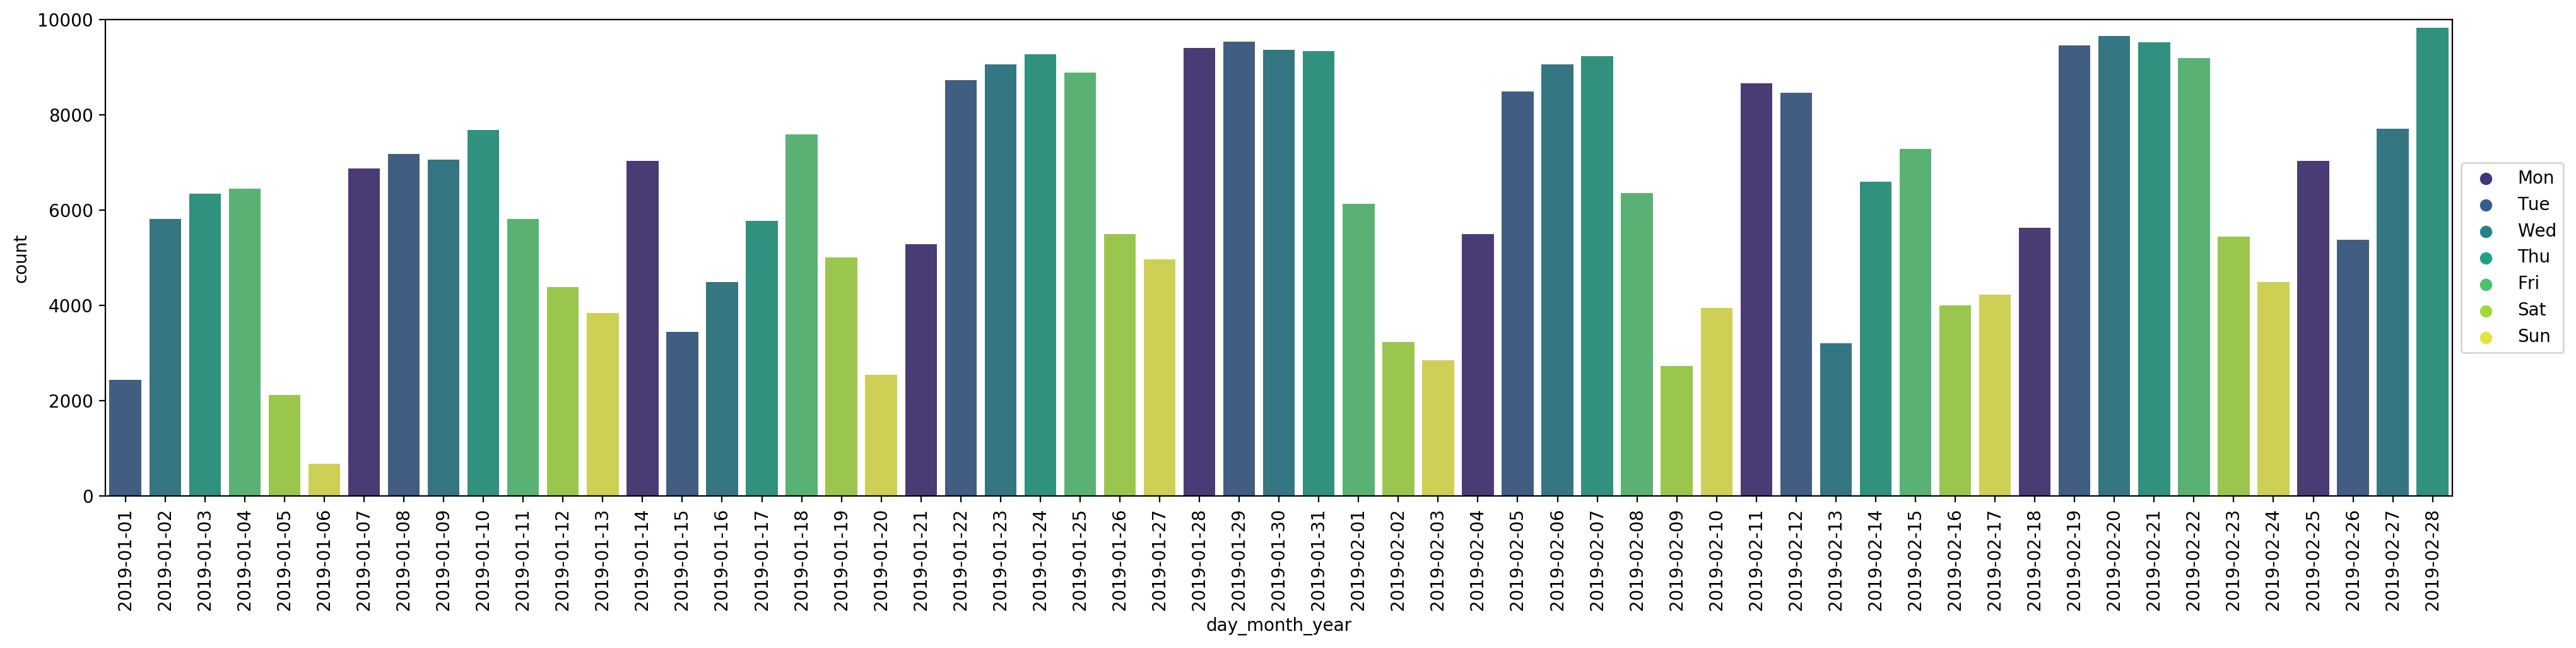

In [361]:
plot_data_time("01.01.19","03.01.19")

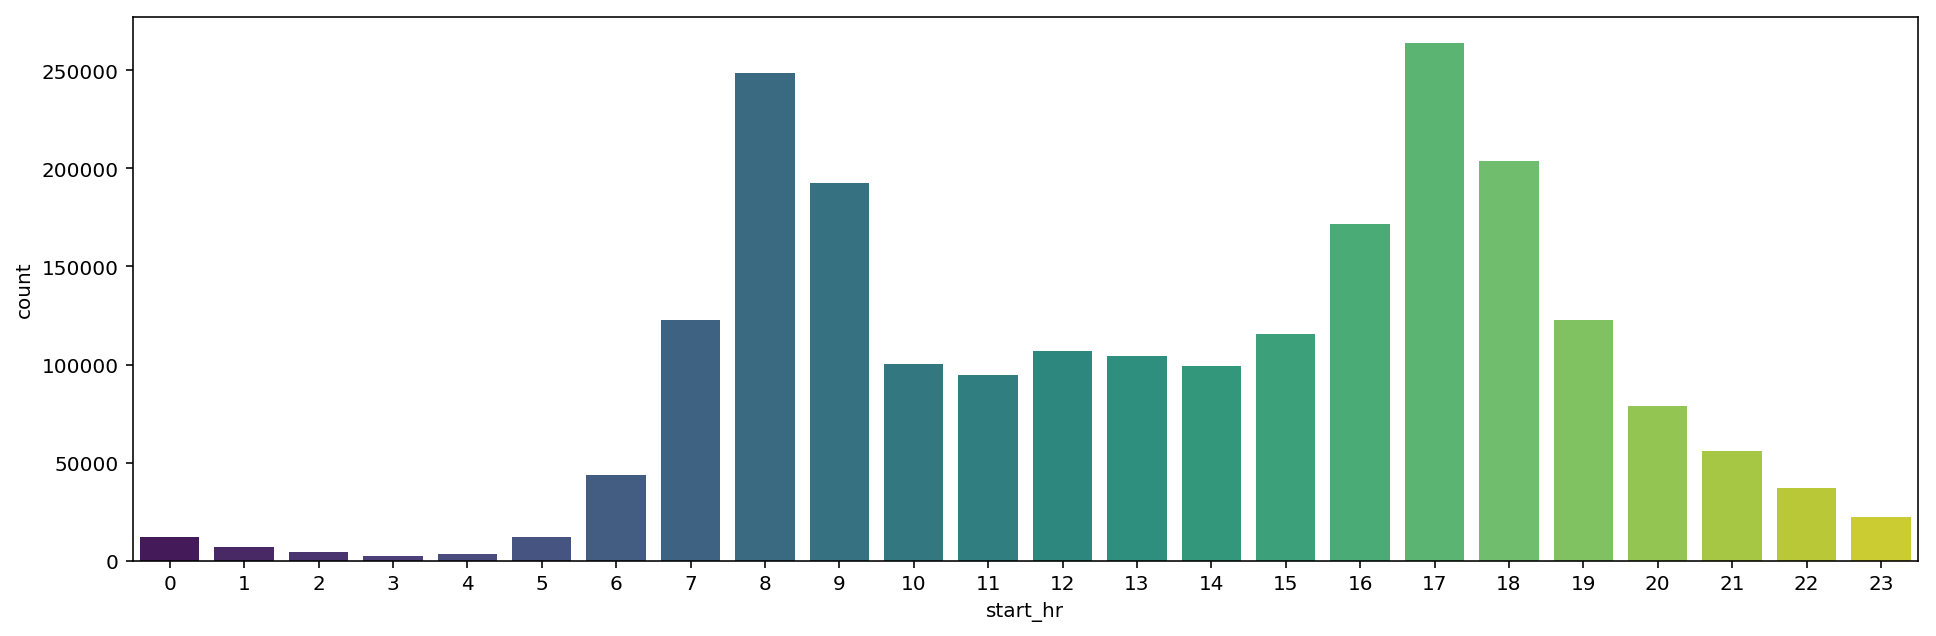

In [362]:
fig, ax = plt.subplots(figsize = (16,5))

sns.countplot(x = "start_hr", data = df, palette = "viridis", ax = ax);

        


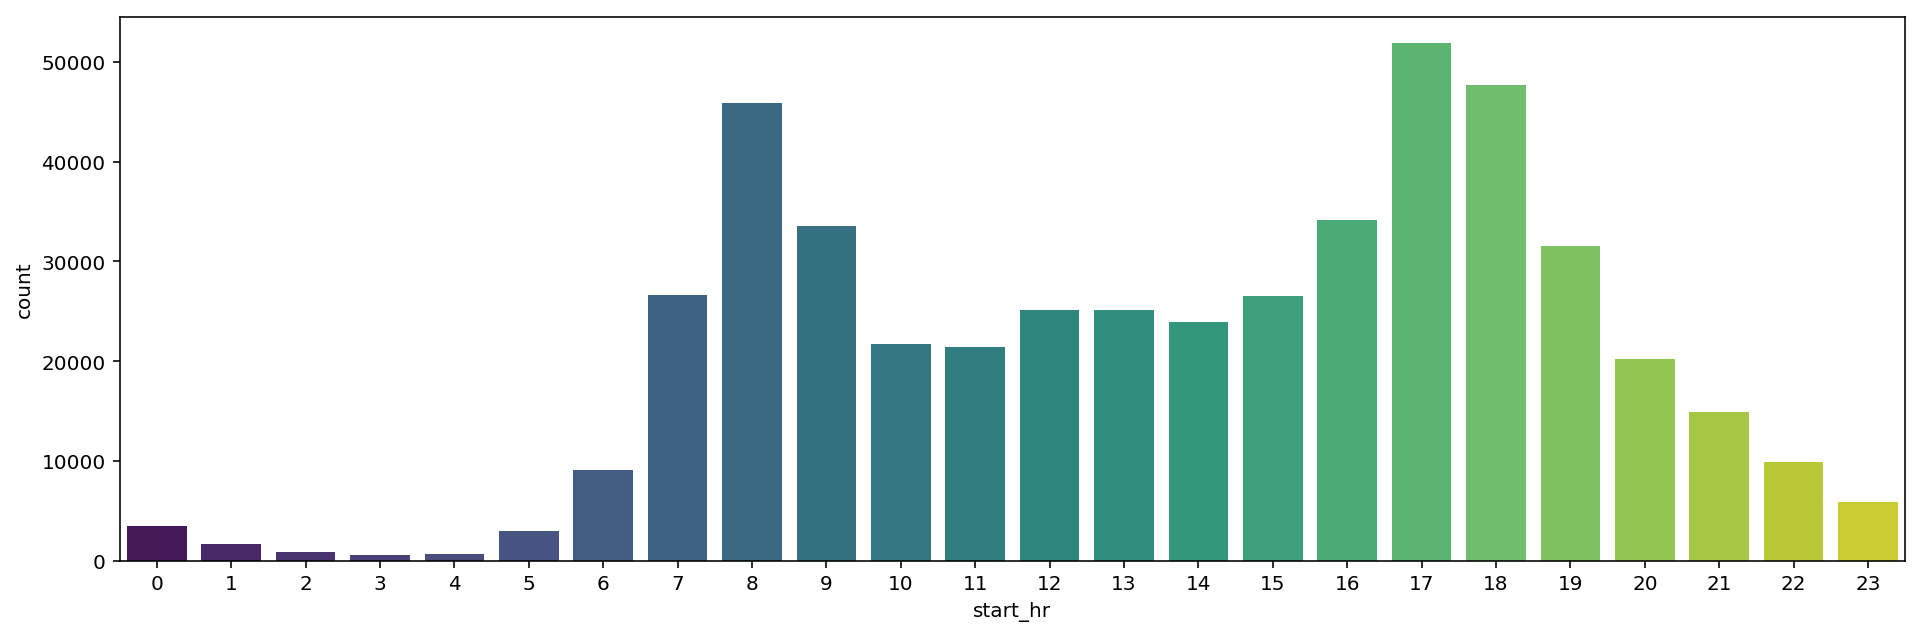

In [363]:
fig, ax = plt.subplots(figsize = (16,5))

sns.countplot(x = "start_hr", data = df.query("label == 0"), palette = "viridis", ax = ax);

        

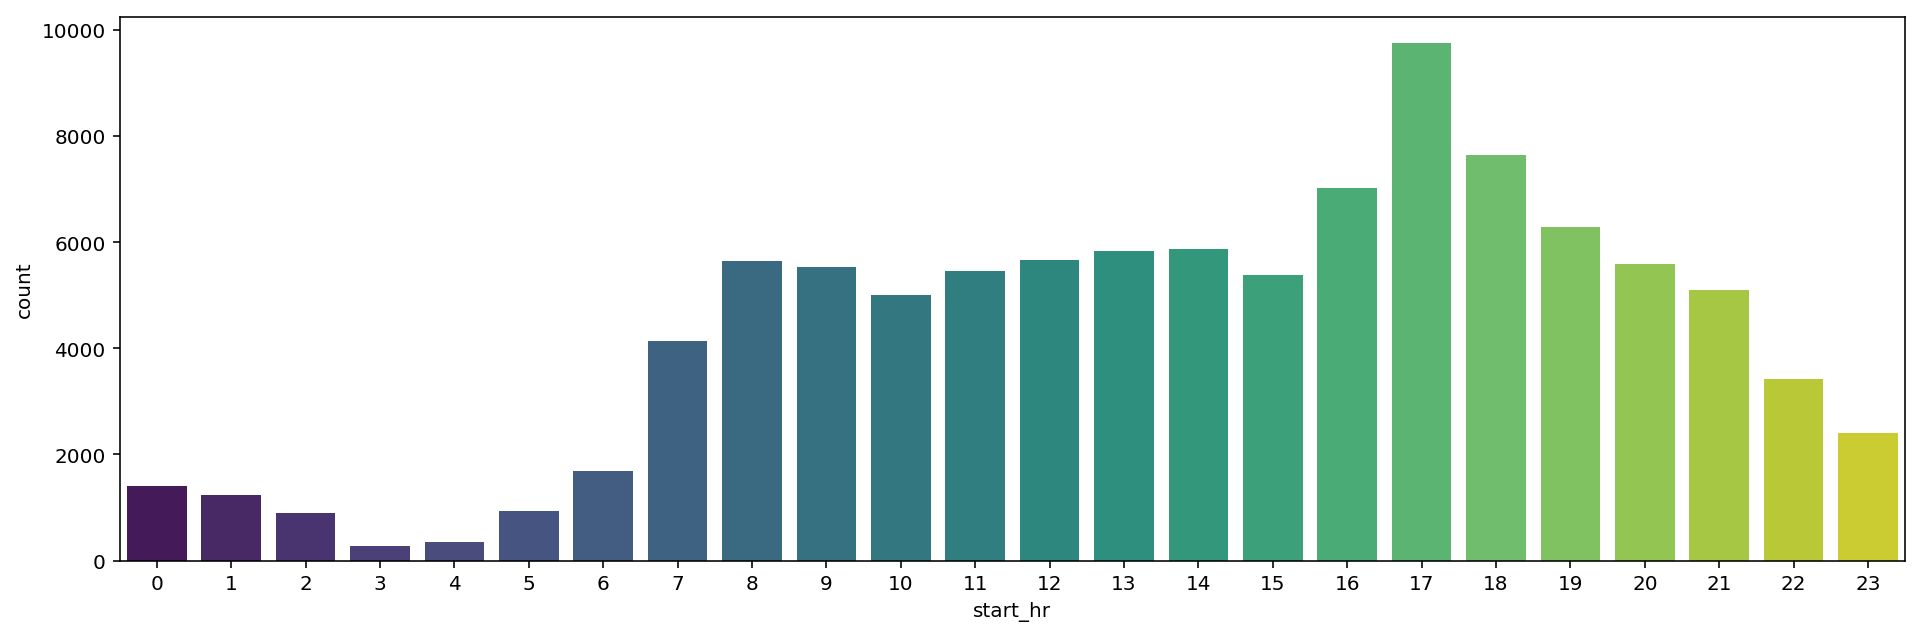

In [364]:
fig, ax = plt.subplots(figsize = (16,5))

sns.countplot(x = "start_hr", data = df.query("label == 1"), palette = "viridis", ax = ax);


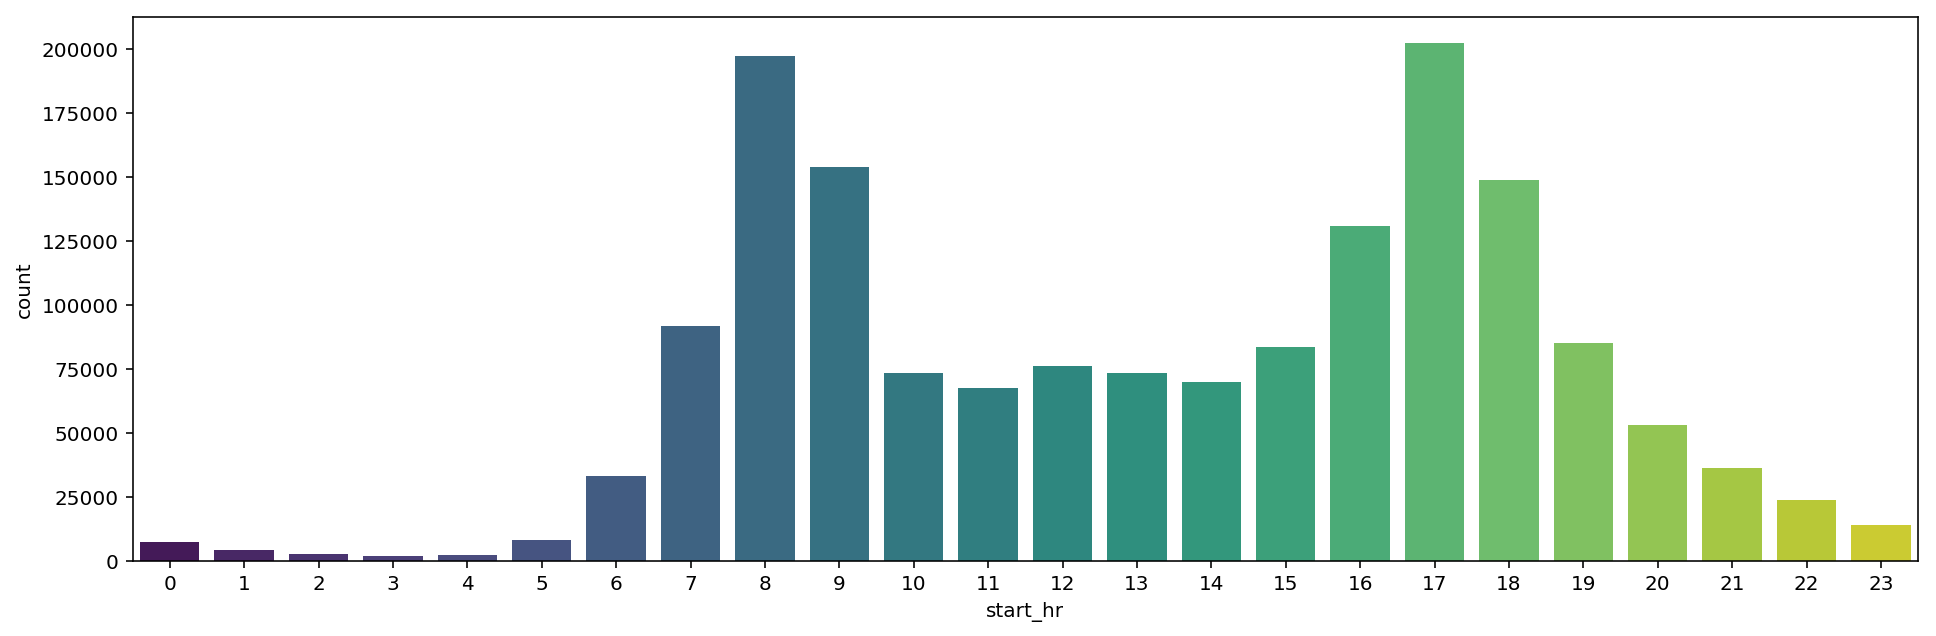

In [365]:
fig, ax = plt.subplots(figsize = (16,5))

sns.countplot(x = "start_hr", data = df.query("label == 2"), palette = "viridis", ax = ax);


Nope


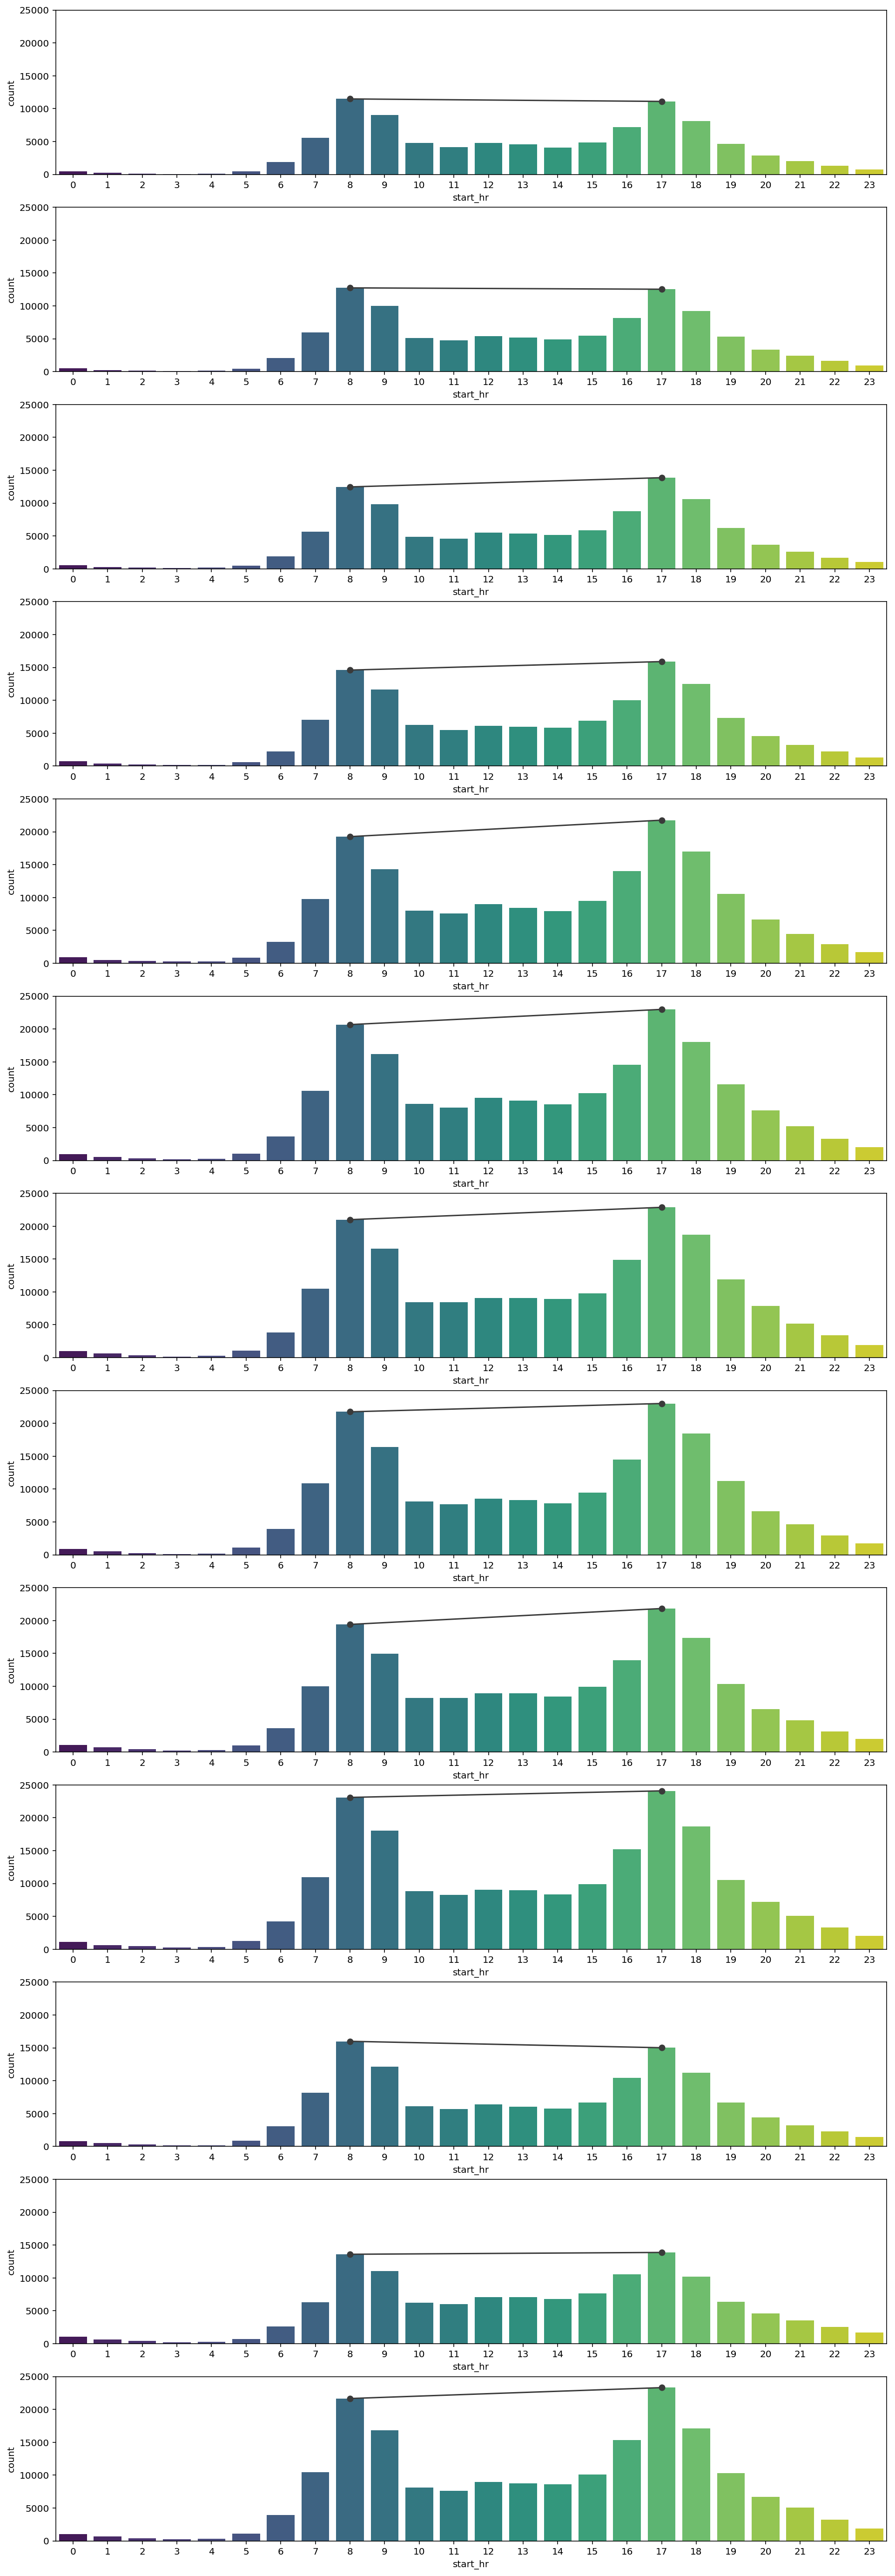

In [366]:
fig, ax = plt.subplots(13,1,figsize = (16,50))

dates = [pd.to_datetime(f"2018-{x}") for x in range(1,13)] + [pd.to_datetime(f"2019-{x}")for x in range(1,3)]

for i, date in enumerate(dates):
    try:
        sns.countplot(x = "start_hr", data = df[(df['start_time'] < dates[i+1])&(df['start_time'] >= date)], palette = "viridis", ax = ax[i]);
        ax[i].set_ylim(0,25000)
        ax[i].set_xlim(-0.5,23.5)
        ax[i].plot([8,17], [ax[i].patches[8].get_height(),ax[i].patches[17].get_height()], 'o-', color = "#3a3a3a")
        
        
    except:
        print("Nope")
        pass

In [367]:
for i, date in enumerate(dates):
    try:
        print(str(df[(df['start_time'] < dates[i+1])&(df['start_time'] >= date)].start_hr.value_counts().head(2)))
    except:
        pass

8     11480
17    11103
Name: start_hr, dtype: int64
8     12738
17    12532
Name: start_hr, dtype: int64
17    13864
8     12460
Name: start_hr, dtype: int64
17    15889
8     14596
Name: start_hr, dtype: int64
17    21765
8     19261
Name: start_hr, dtype: int64
17    22980
8     20665
Name: start_hr, dtype: int64
17    22866
8     20994
Name: start_hr, dtype: int64
17    23025
8     21762
Name: start_hr, dtype: int64
17    21836
8     19420
Name: start_hr, dtype: int64
17    24098
8     23104
Name: start_hr, dtype: int64
8     15999
17    15022
Name: start_hr, dtype: int64
17    13882
8     13602
Name: start_hr, dtype: int64
17    23316
8     21660
Name: start_hr, dtype: int64


<a id='bi'></a>
### Bivariate Exploration
> Relationships

In [368]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,end_station_id_new,new_id,label,age,month_year,day_month_year,dayofweek,start_hr,end_hr,label_name
0,13709,2018-01-01 00:01:53.847,2018-01-01 03:50:23.433,86,Market St at Dolores St,37.769305,-122.426826,119,18th St at Noe St,37.761047,...,119_0,86_0,2,2018,2018-01,2018-01-01,0,0,3,San Francisco
1,9996,2018-01-01 04:37:08.115,2018-01-01 07:23:44.143,86,Market St at Dolores St,37.769305,-122.426826,223,16th St Mission BART Station 2,37.764765,...,223_0,86_0,2,2018,2018-01,2018-01-01,0,4,7,San Francisco
2,197,2018-01-01 09:29:57.079,2018-01-01 09:33:14.662,86,Market St at Dolores St,37.769305,-122.426826,85,Church St at Duboce Ave,37.770083,...,85_0,86_0,2,61,2018-01,2018-01-01,0,9,9,San Francisco
3,183,2018-01-01 11:25:27.634,2018-01-01 11:28:31.059,86,Market St at Dolores St,37.769305,-122.426826,75,Market St at Franklin St,37.773793,...,75_0,86_0,2,31,2018-01,2018-01-01,0,11,11,San Francisco
4,893,2018-01-01 12:07:39.271,2018-01-01 12:22:32.393,86,Market St at Dolores St,37.769305,-122.426826,42,San Francisco City Hall (Polk St at Grove St),37.778650,...,42_0,86_0,2,2018,2018-01,2018-01-01,0,12,12,San Francisco


In [369]:
df["combi"] = df["start_station_id_new"] + " - " + df["end_station_id_new"]
df.combi.value_counts().head(10)

15_0 - 6_0       8352
6_0 - 16_0       5403
81_0 - 15_0      5238
196_0 - 182_0    4607
182_0 - 196_0    4355
6_0 - 15_0       4171
16_0 - 6_0       3685
15_0 - 81_0      3620
90_0 - 67_0      3417
195_0 - 182_0    3396
Name: combi, dtype: int64

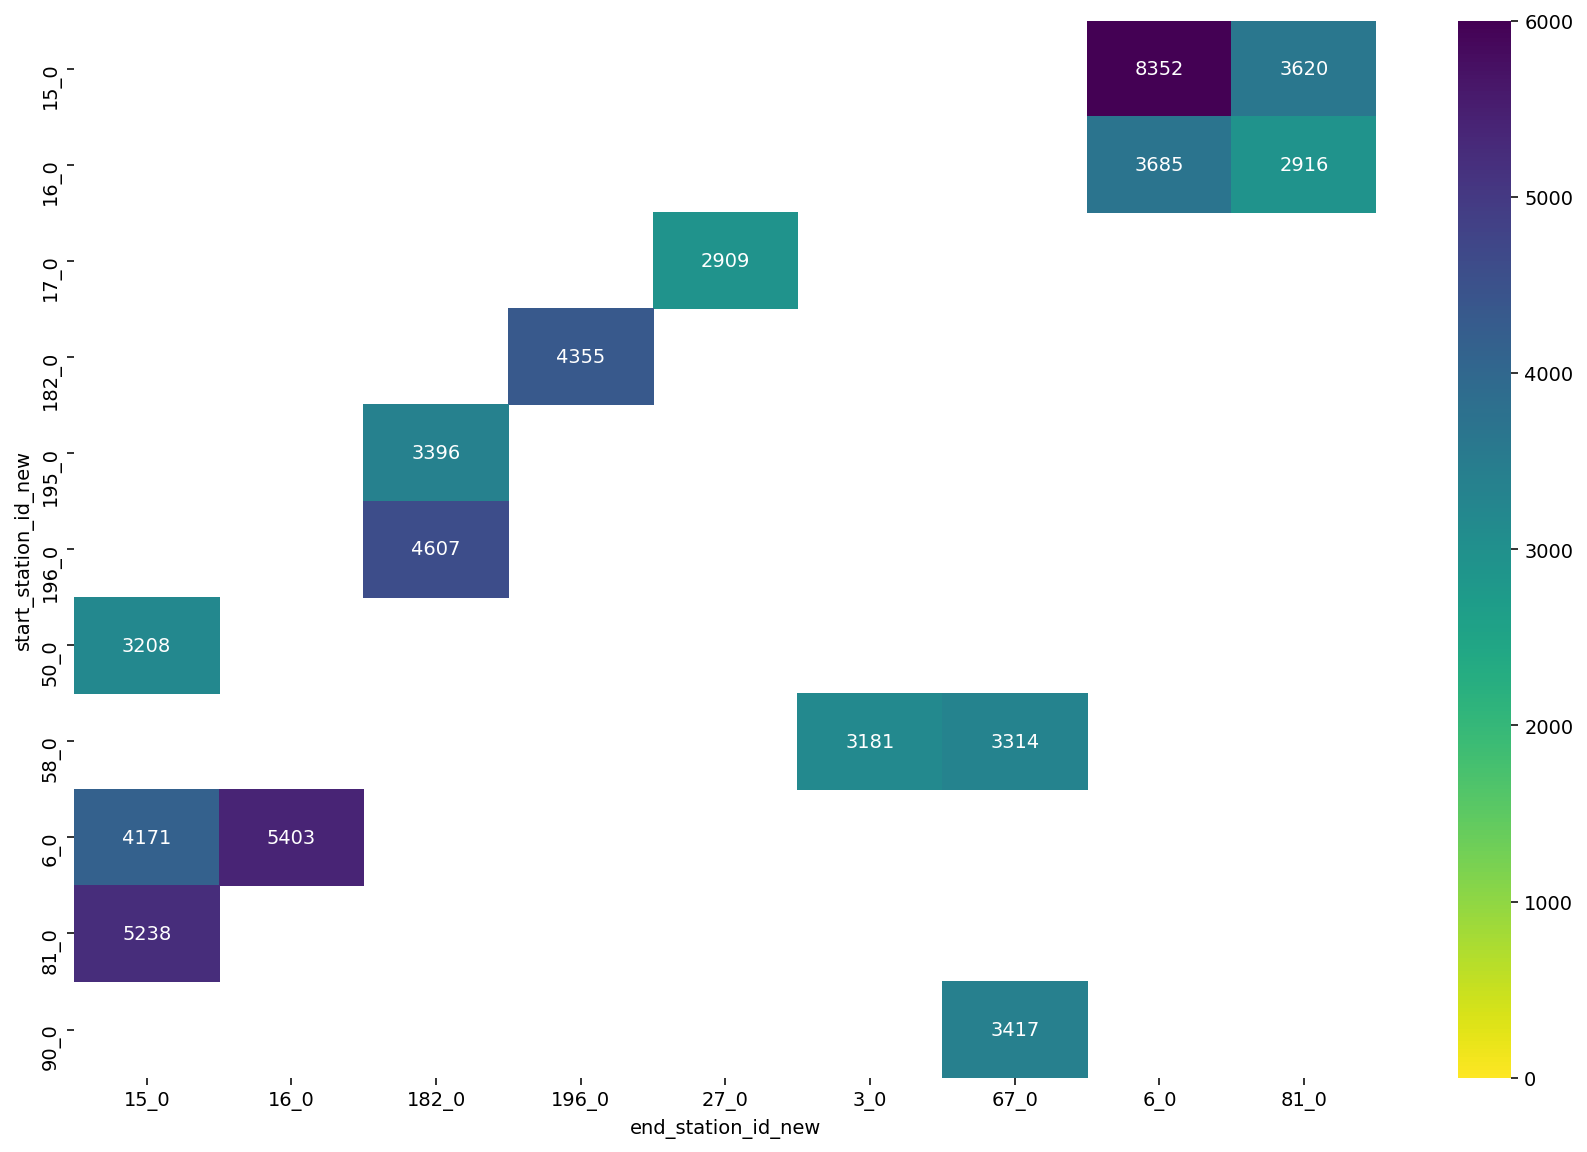

In [370]:
combi_list = df.combi.value_counts().head(15).keys()

df_criteria = df[df["combi"].isin(combi_list)]

df_pivot = df_criteria.pivot_table(index="start_station_id_new", columns = "end_station_id_new", values = "start_time", aggfunc = "count", fill_value = 0)

fig, axes = plt.subplots(figsize = (15,10), dpi = 70)
sns.heatmap(df_pivot, annot = True, cmap = "viridis_r", fmt='g', vmin = 1, vmax = 6000, mask= df_pivot == 0)

In [371]:
for i, x in enumerate(combi_list):
    start, end = x.split(" - ")
    start_name = df.query(f"start_station_id_new == '{start}'").start_station_name.drop_duplicates().get_values()
    end_name = df.query(f"end_station_id_new == '{end}'").end_station_name.drop_duplicates().get_values()
    print(start," ",start_name[0], " - ",end, " ", end_name[0])


15_0   San Francisco Ferry Building (Harry Bridges Plaza)  -  6_0   The Embarcadero at Sansome St
6_0   The Embarcadero at Sansome St  -  16_0   Steuart St at Market St
81_0   Berry St at 4th St  -  15_0   San Francisco Ferry Building (Harry Bridges Plaza)
196_0   Grand Ave at Perkins St  -  182_0   19th Street BART Station
182_0   19th Street BART Station  -  196_0   Grand Ave at Perkins St
6_0   The Embarcadero at Sansome St  -  15_0   San Francisco Ferry Building (Harry Bridges Plaza)
16_0   Steuart St at Market St  -  6_0   The Embarcadero at Sansome St
15_0   San Francisco Ferry Building (Harry Bridges Plaza)  -  81_0   Berry St at 4th St
90_0   Townsend St at 7th St  -  67_0   San Francisco Caltrain Station 2  (Townsend St at 4th St)
195_0   Bay Pl at Vernon St  -  182_0   19th Street BART Station
58_0   Market St at 10th St  -  67_0   San Francisco Caltrain Station 2  (Townsend St at 4th St)
50_0   2nd St at Townsend St  -  15_0   San Francisco Ferry Building (Harry Bridges Plaz

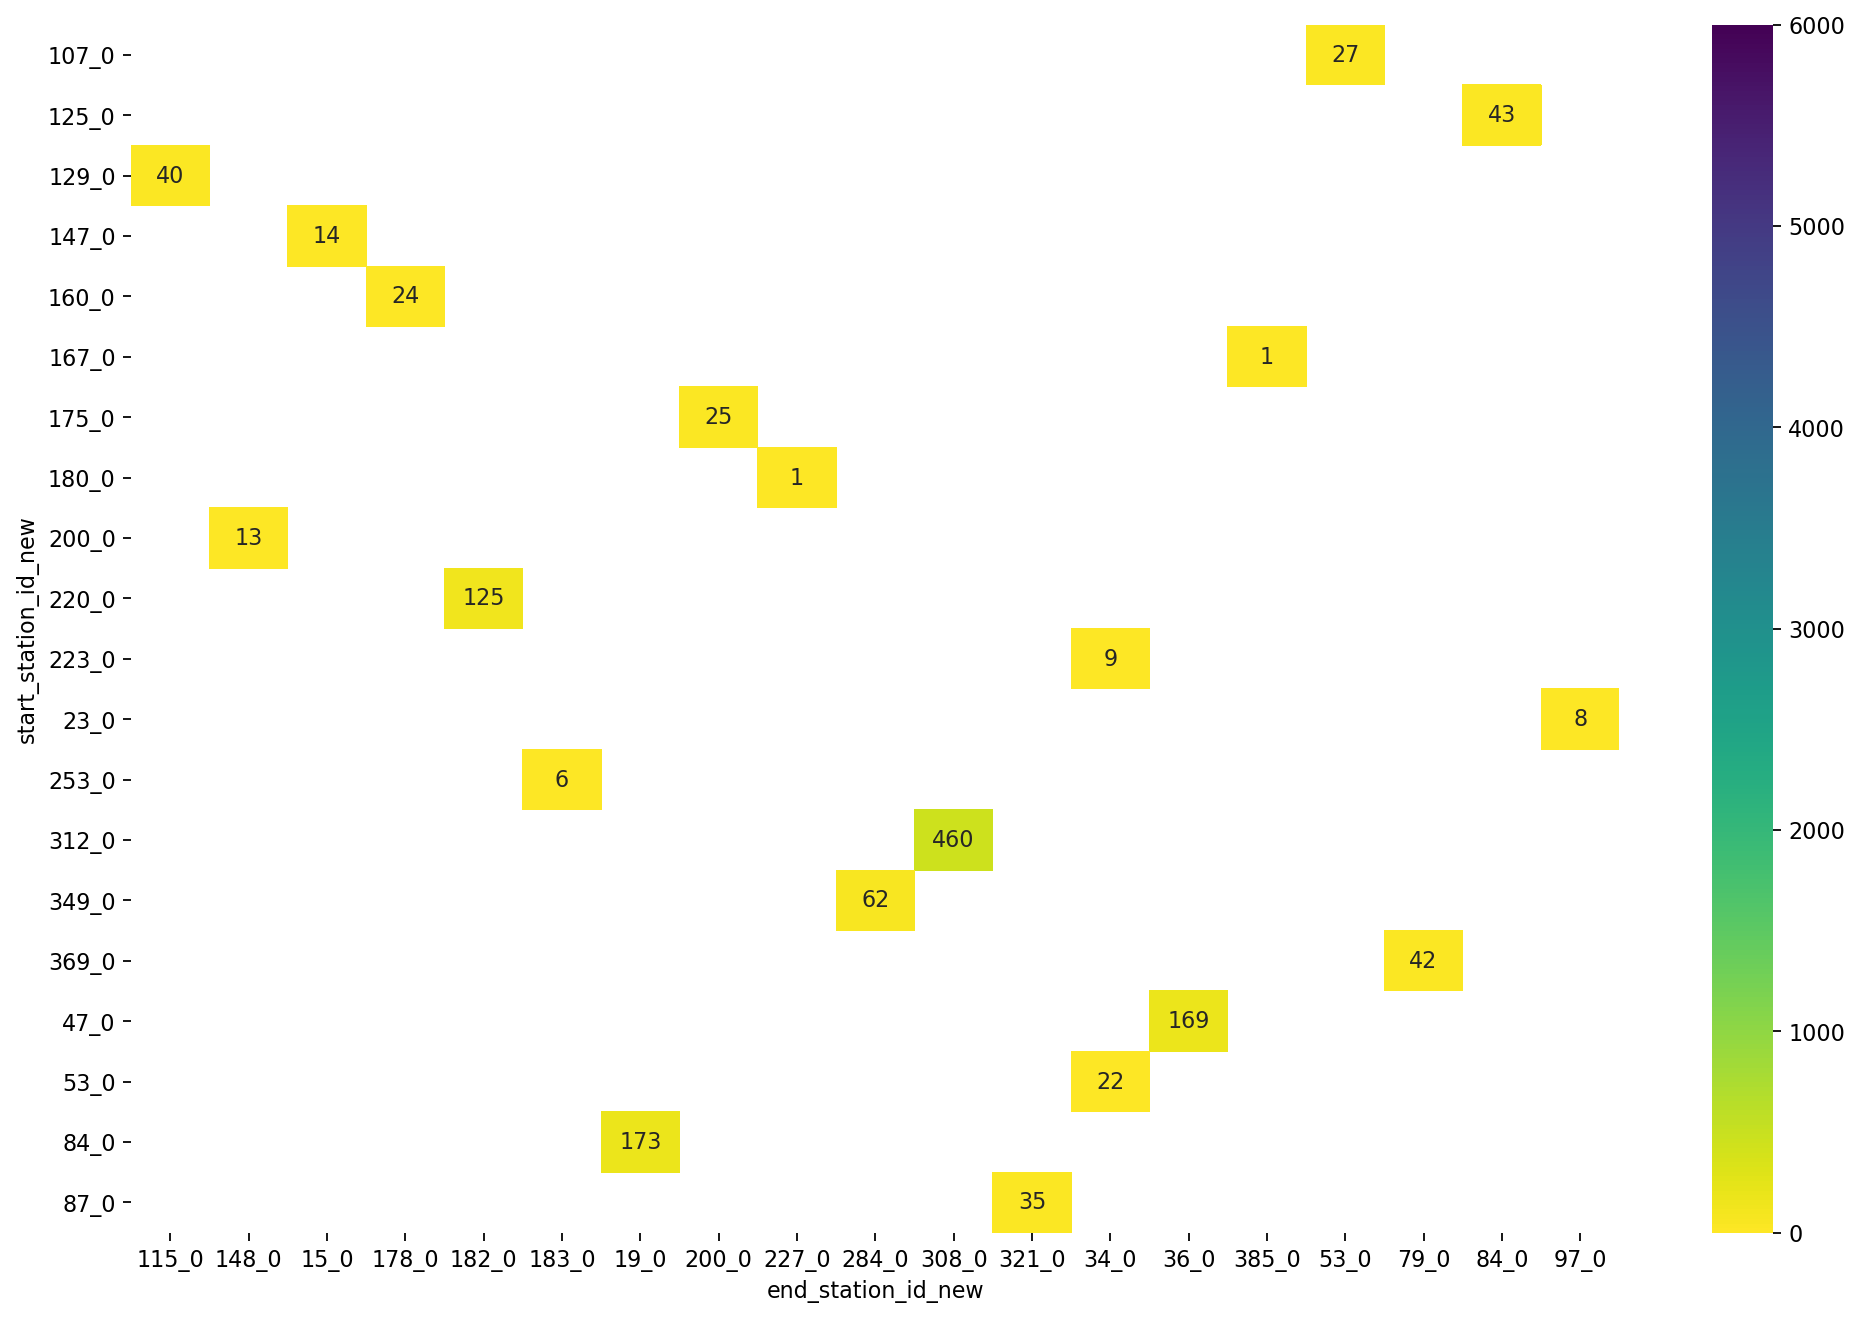

In [372]:
combi_list = df.combi.value_counts().sample(20).keys()

df_criteria = df[df["combi"].isin(combi_list)]

df_pivot = df_criteria.pivot_table(index="start_station_id_new", columns = "end_station_id_new", values = "start_time", aggfunc = "count", fill_value = 0)

fig, axes = plt.subplots(figsize = (15,10), dpi = 80)
sns.heatmap(df_pivot, annot = True, cmap = "viridis_r", fmt='g', vmin = 1, vmax = 6000, mask= df_pivot == 0)

In [373]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,new_id,label,age,month_year,day_month_year,dayofweek,start_hr,end_hr,label_name,combi
0,13709,2018-01-01 00:01:53.847,2018-01-01 03:50:23.433,86,Market St at Dolores St,37.769305,-122.426826,119,18th St at Noe St,37.761047,...,86_0,2,2018,2018-01,2018-01-01,0,0,3,San Francisco,86_0 - 119_0
1,9996,2018-01-01 04:37:08.115,2018-01-01 07:23:44.143,86,Market St at Dolores St,37.769305,-122.426826,223,16th St Mission BART Station 2,37.764765,...,86_0,2,2018,2018-01,2018-01-01,0,4,7,San Francisco,86_0 - 223_0
2,197,2018-01-01 09:29:57.079,2018-01-01 09:33:14.662,86,Market St at Dolores St,37.769305,-122.426826,85,Church St at Duboce Ave,37.770083,...,86_0,2,61,2018-01,2018-01-01,0,9,9,San Francisco,86_0 - 85_0
3,183,2018-01-01 11:25:27.634,2018-01-01 11:28:31.059,86,Market St at Dolores St,37.769305,-122.426826,75,Market St at Franklin St,37.773793,...,86_0,2,31,2018-01,2018-01-01,0,11,11,San Francisco,86_0 - 75_0
4,893,2018-01-01 12:07:39.271,2018-01-01 12:22:32.393,86,Market St at Dolores St,37.769305,-122.426826,42,San Francisco City Hall (Polk St at Grove St),37.778650,...,86_0,2,2018,2018-01,2018-01-01,0,12,12,San Francisco,86_0 - 42_0


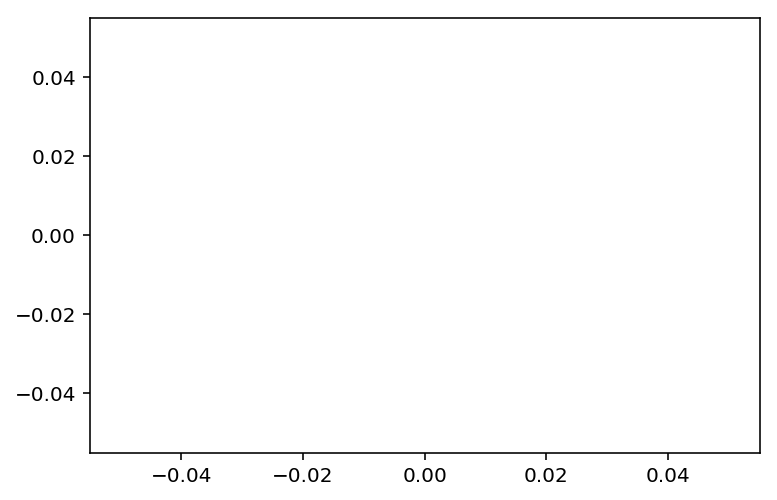

In [374]:
legend_obj = []

colors = [sns.color_palette("viridis")[0],
          sns.color_palette("viridis")[1],
          sns.color_palette("viridis")[2],
          sns.color_palette("viridis")[3],
          sns.color_palette("viridis")[4],
          sns.color_palette("viridis")[5],
          (163/255, 199/255, 70/255)]

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for i, s in enumerate(days):
    legend_obj.append(plt.scatter([],[],color = colors[i]));  



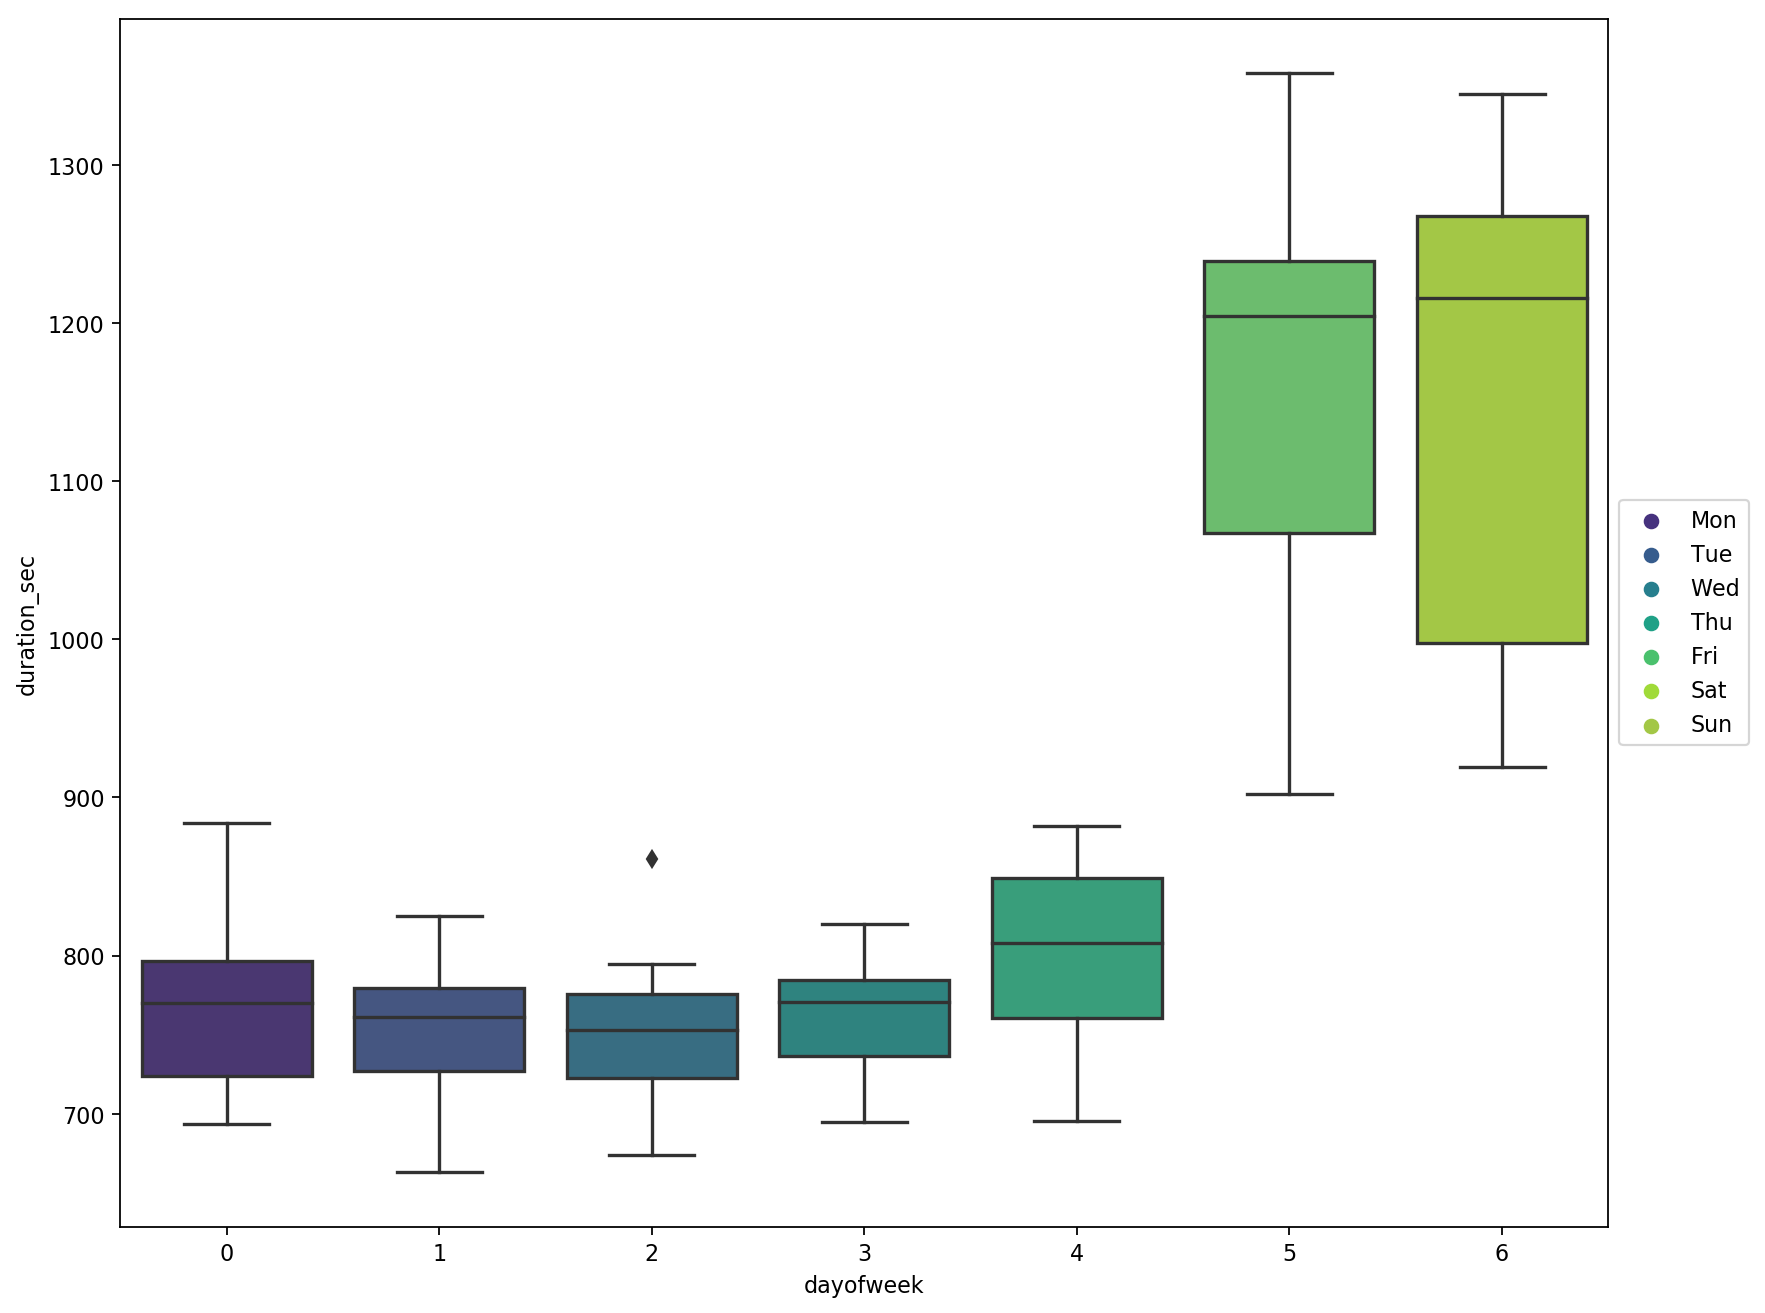

In [375]:
#https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "dayofweek", y = "duration_sec", data = df.groupby(["dayofweek", "month_year"], as_index = False).mean(), palette = "viridis")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(legend_obj, days, loc='center left', bbox_to_anchor=(1, 0.5))

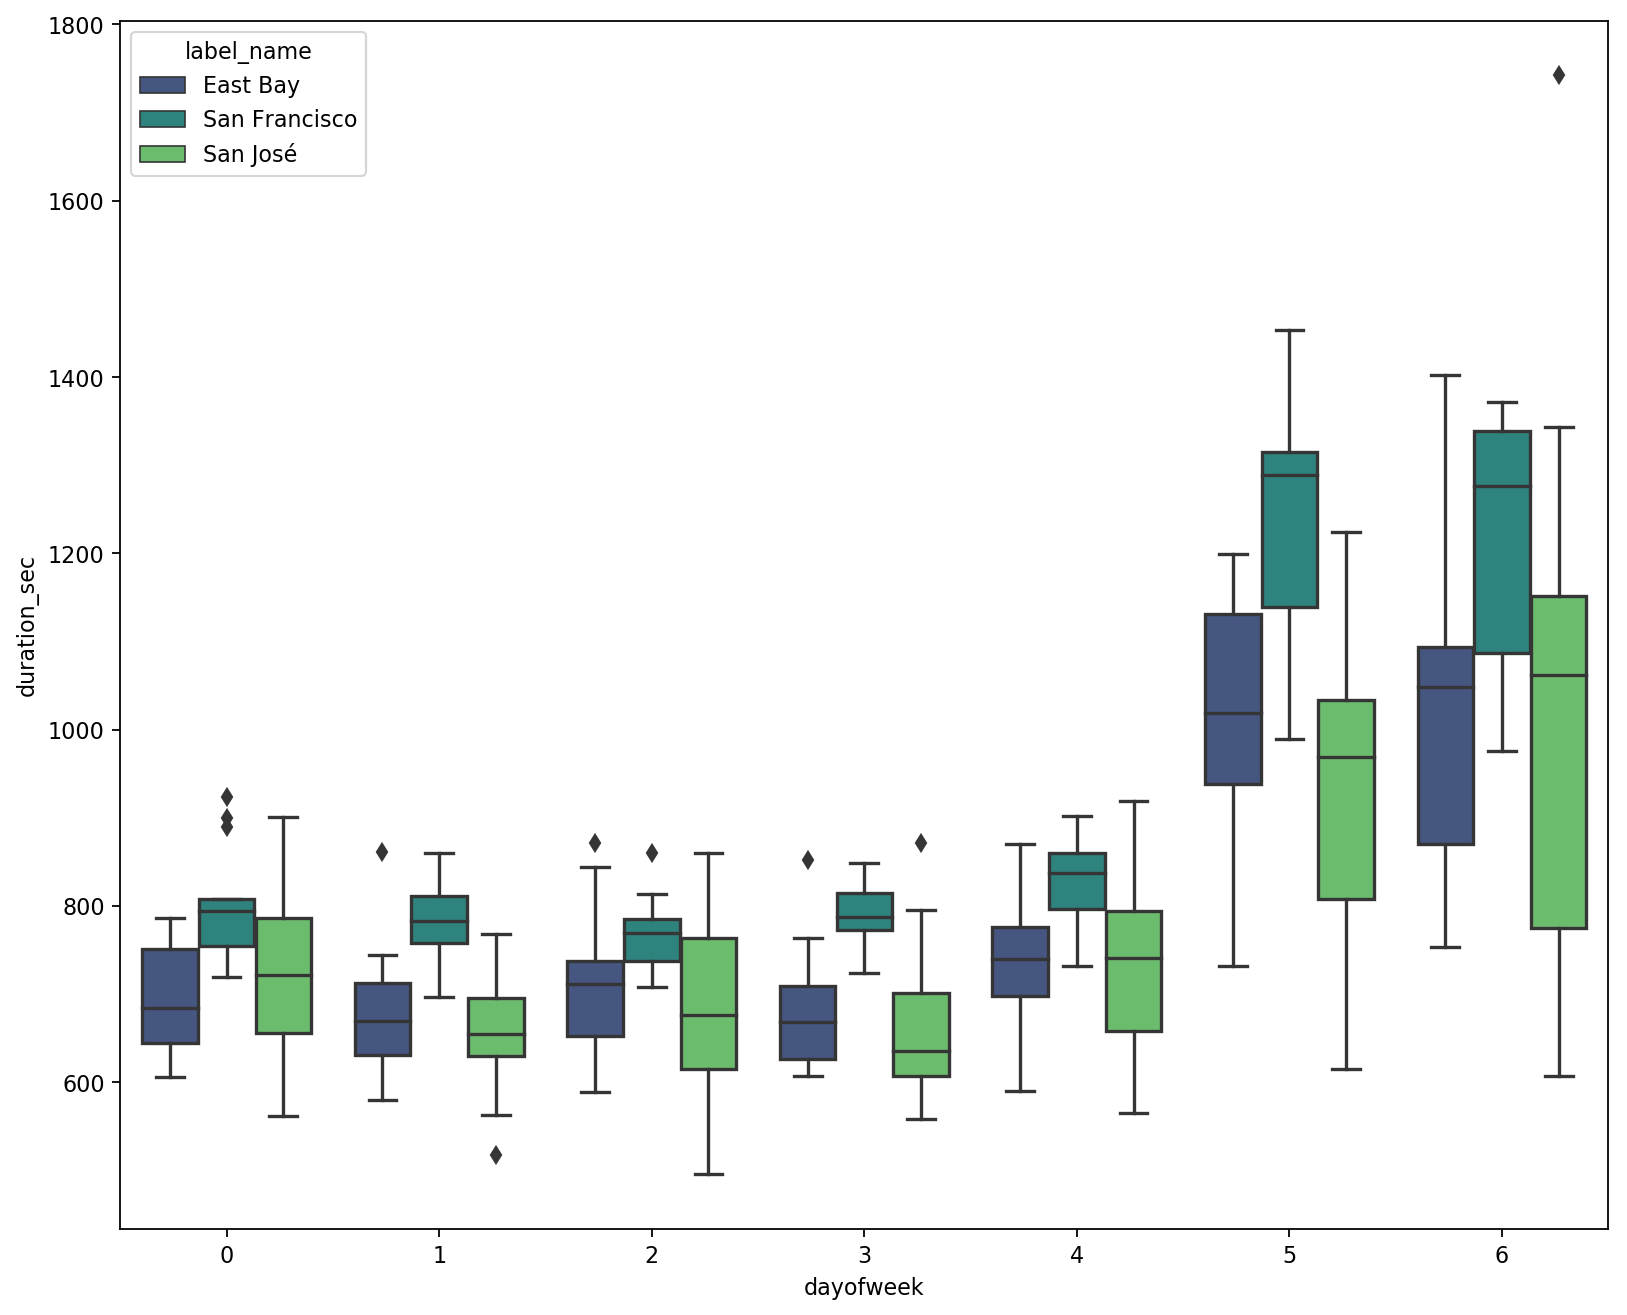

In [376]:
#https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "dayofweek", y = "duration_sec", data = df.groupby(["dayofweek", "month_year", "label_name"], as_index = False).mean(), palette = "viridis", hue = "label_name")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


(250, 1500)

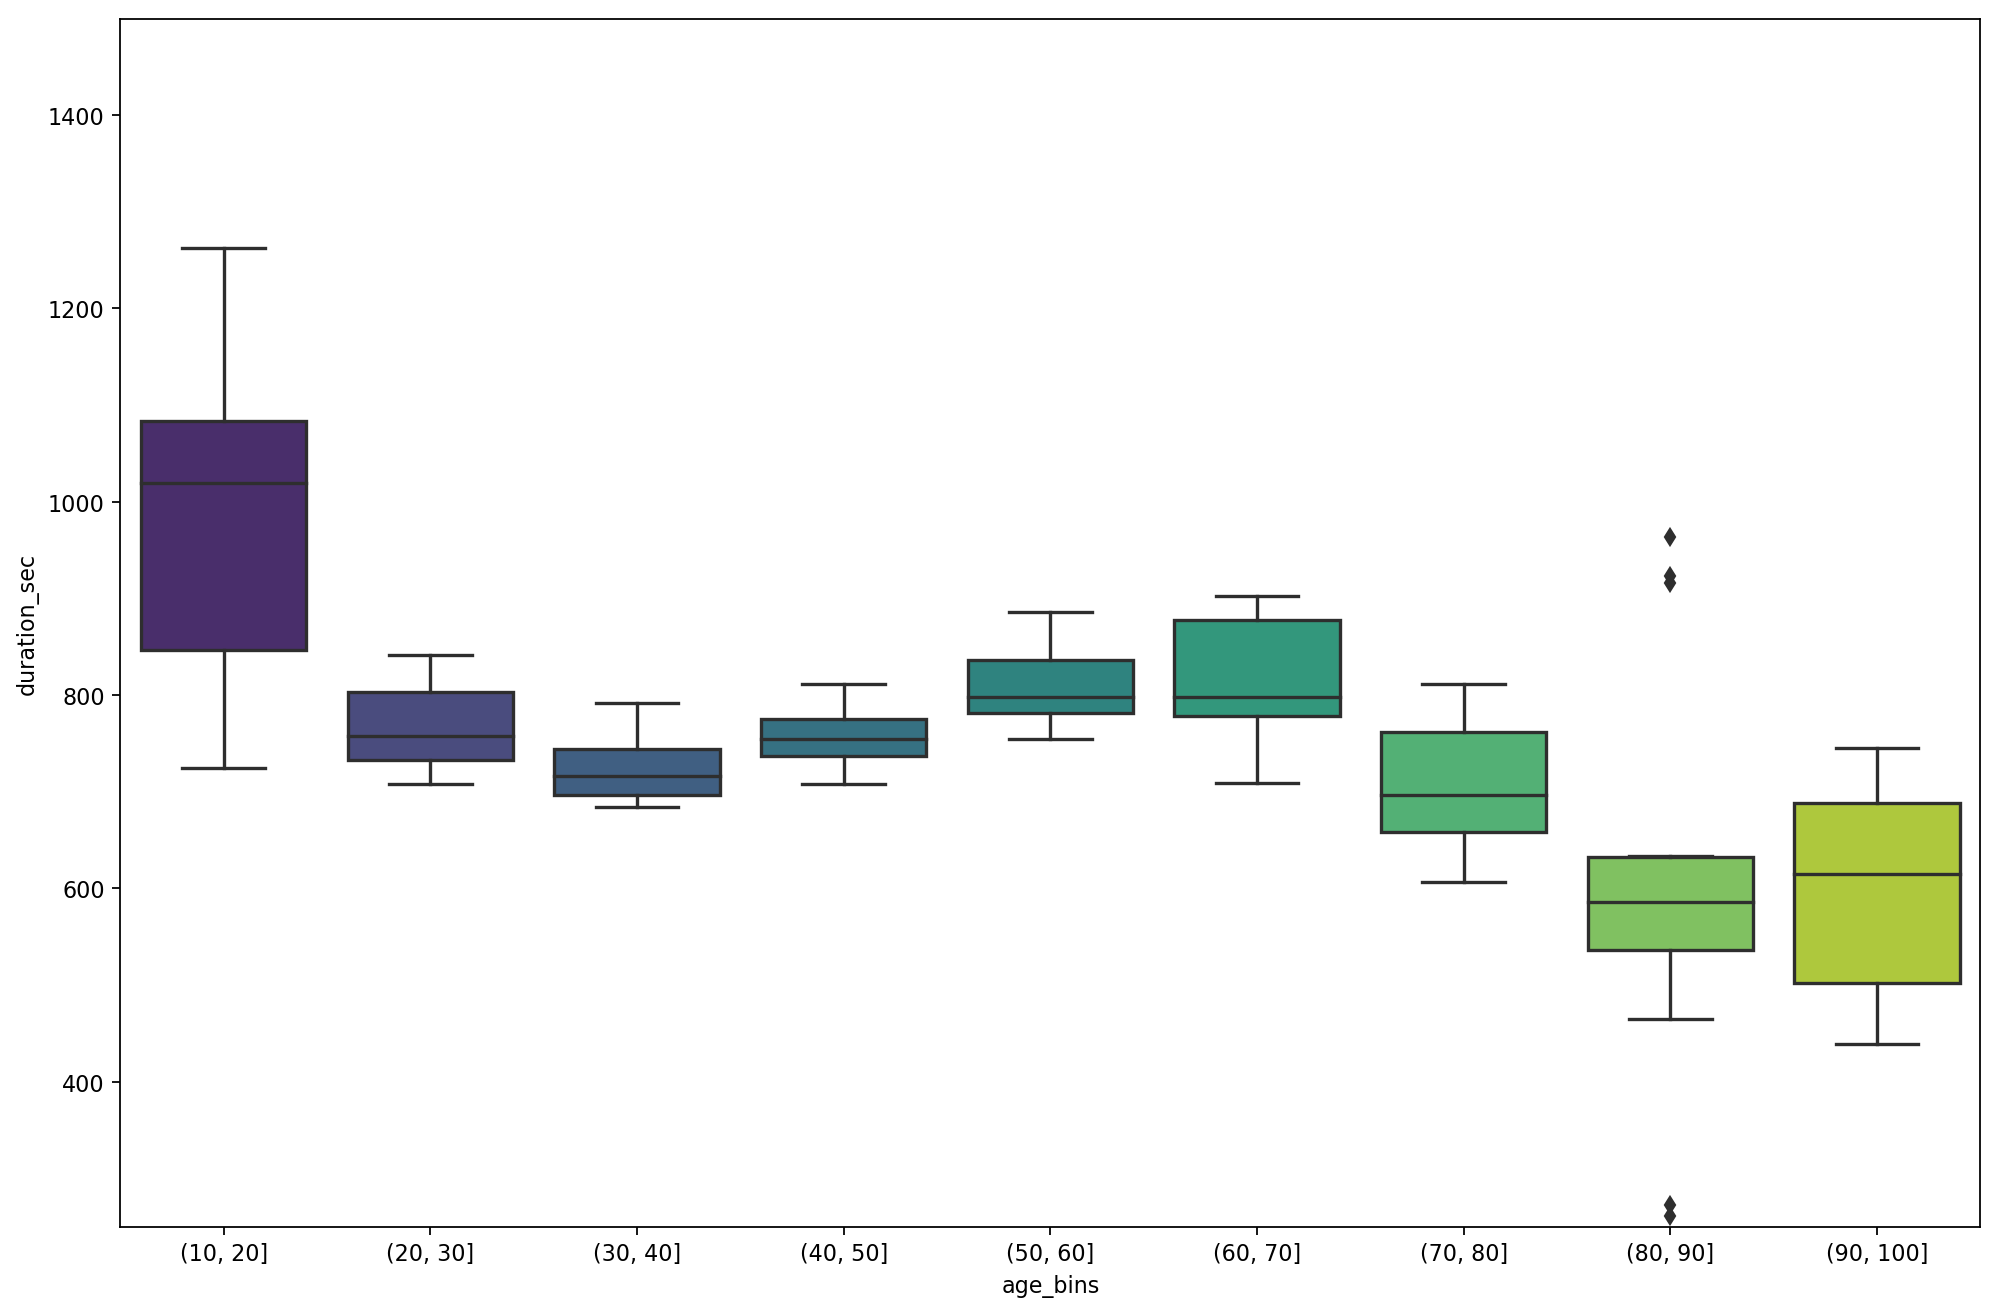

In [377]:
fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "age_bins", y = "duration_sec", data = df_age.groupby(["age_bins", "month_year"], as_index = False).mean(), palette = "viridis")
plt.ylim(250,1500)


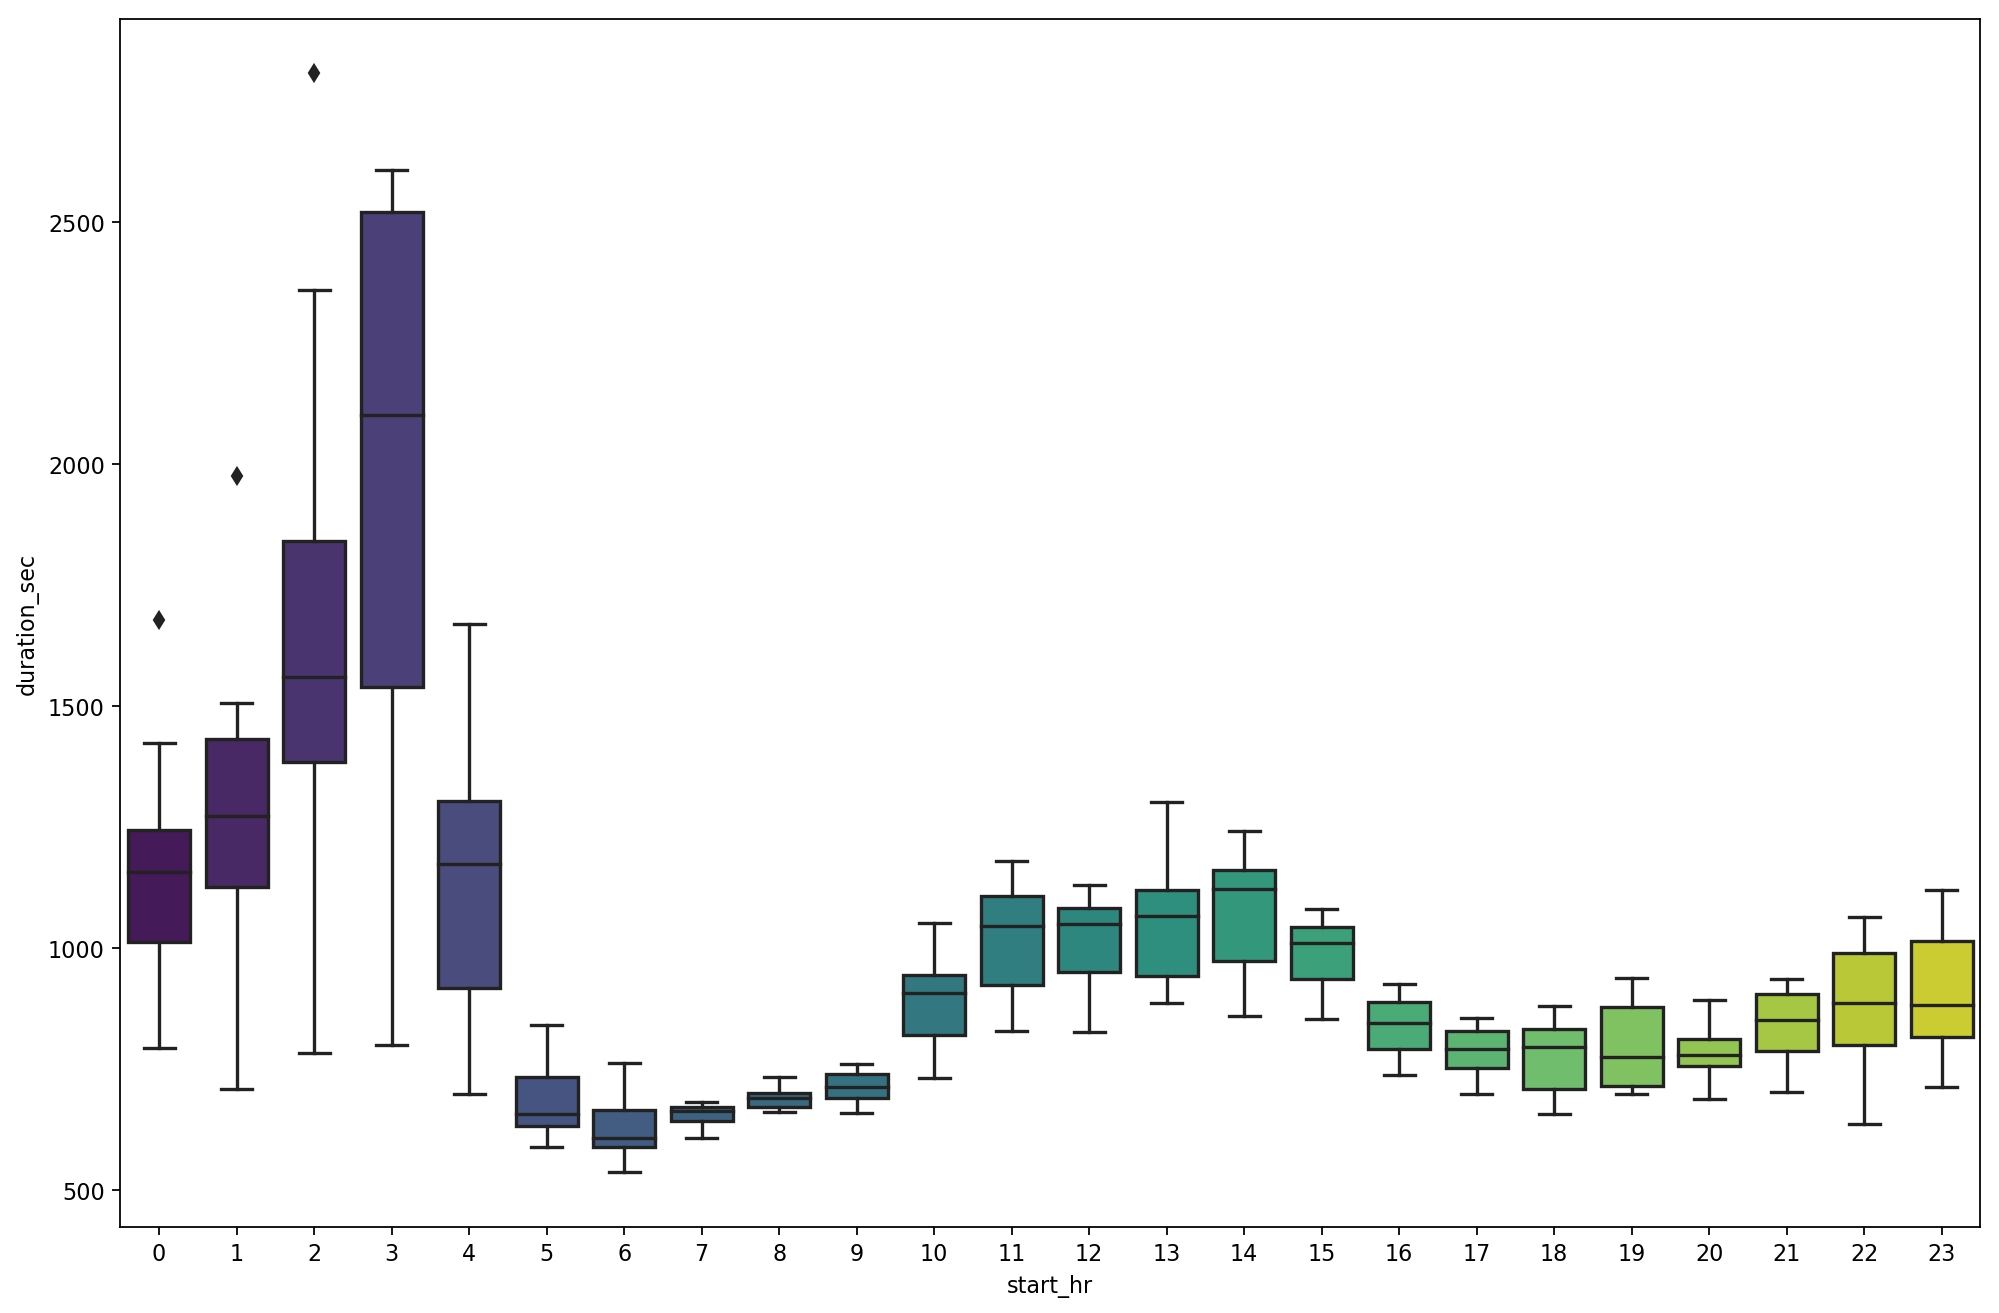

In [378]:
fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "start_hr", y = "duration_sec", data = df.groupby(["start_hr", "month_year"], as_index = False).mean(), palette = "viridis")

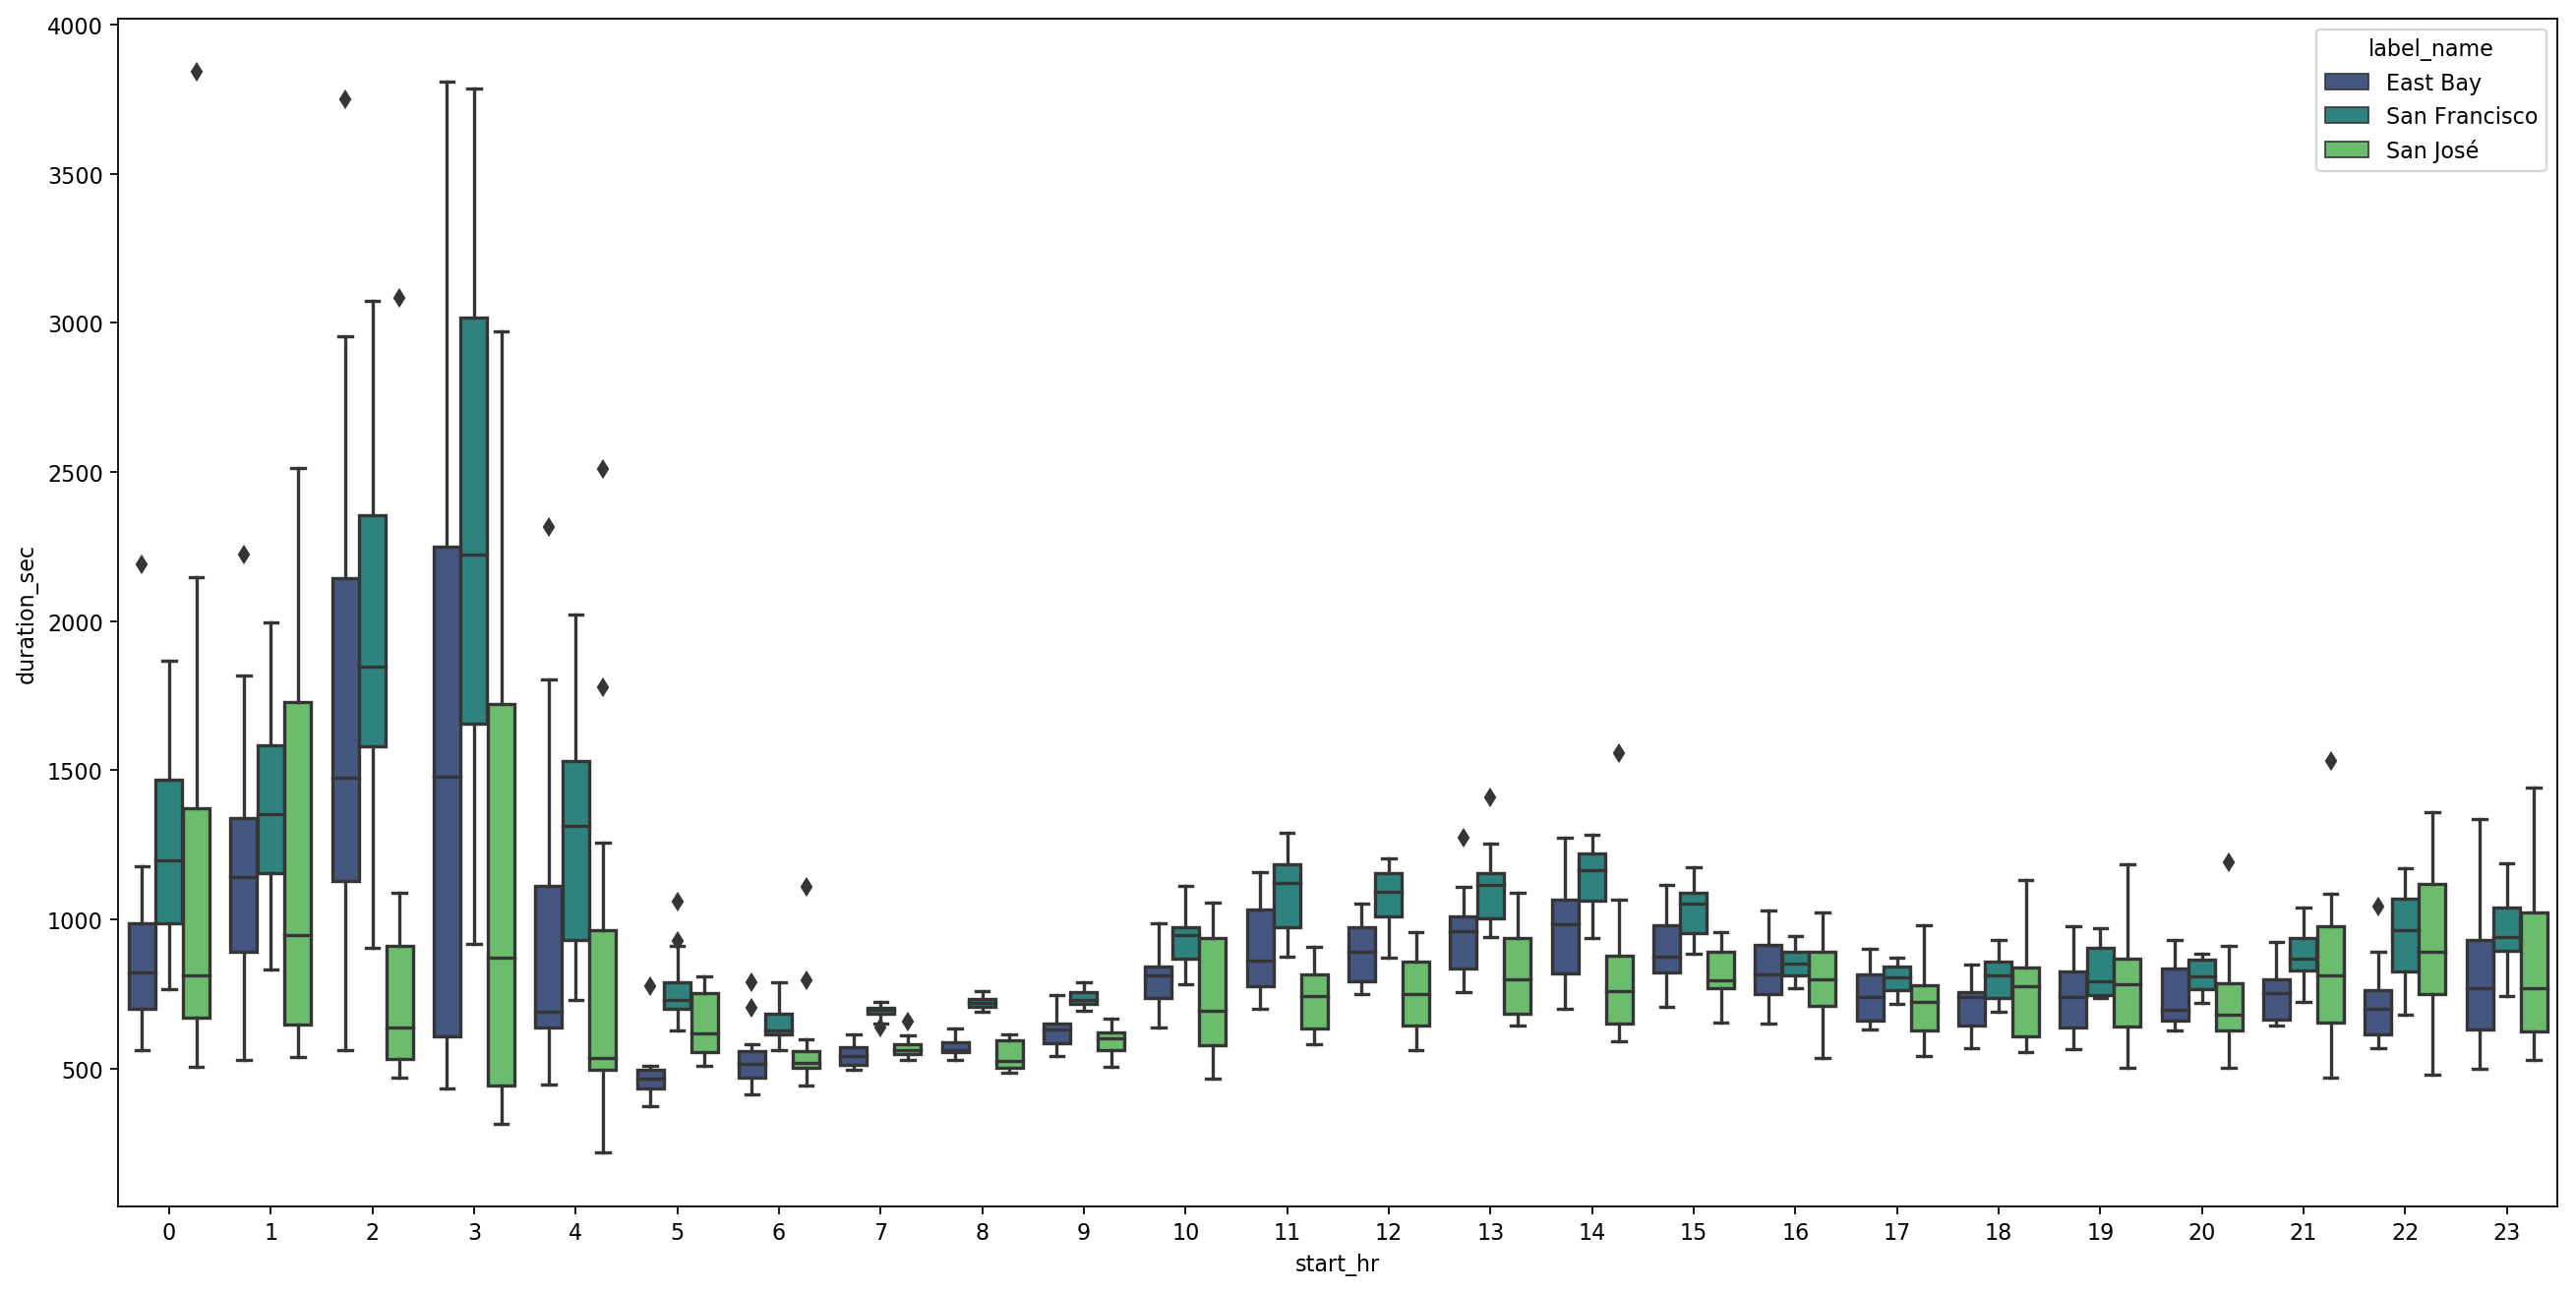

In [379]:
fig, ax = plt.subplots(figsize = (20,10), dpi = 80)
sns.boxplot(x = "start_hr", y = "duration_sec", data = df.groupby(["start_hr", "month_year", "label_name"], as_index = False).mean(), palette = "viridis", hue = "label_name")

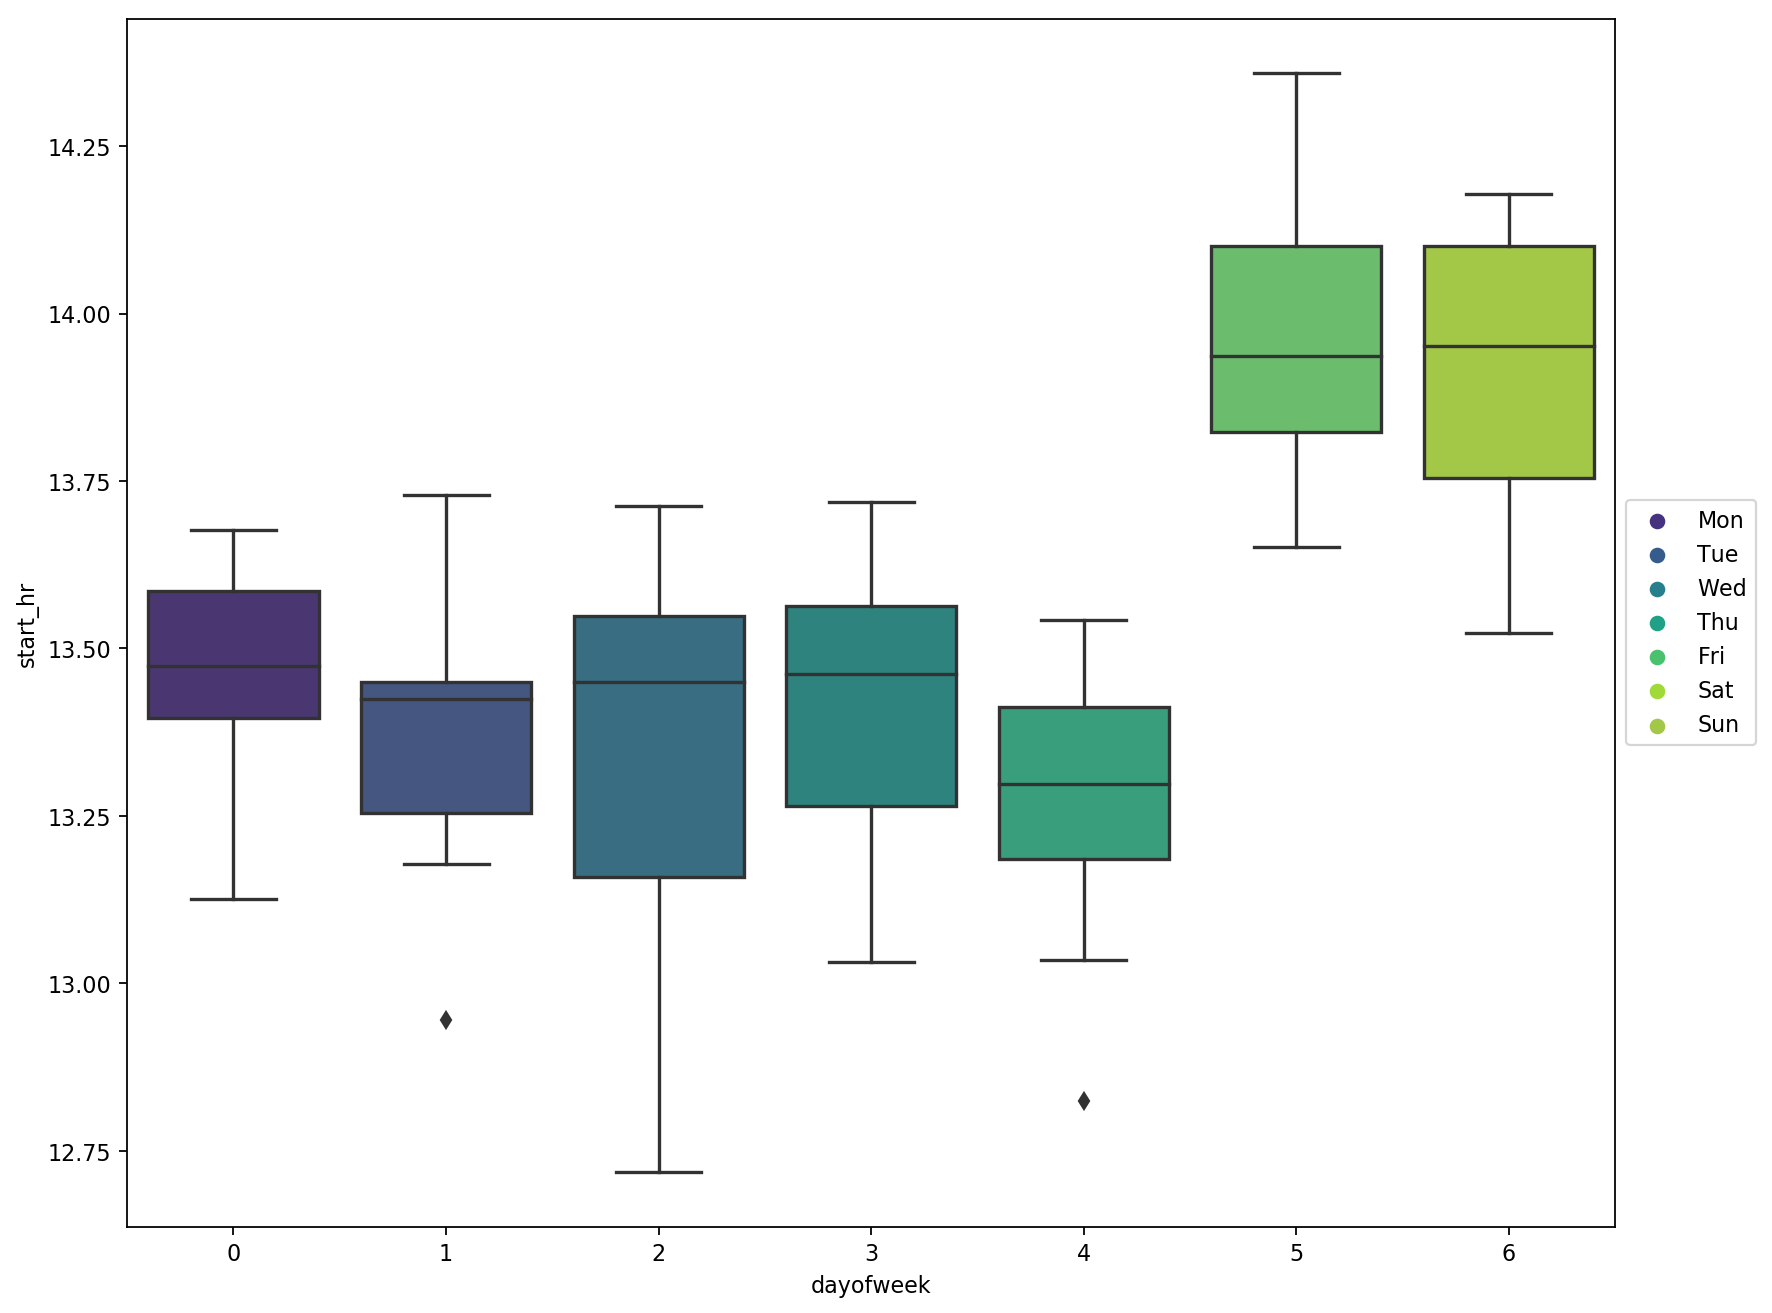

In [380]:
fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "dayofweek", y = "start_hr", data = df.groupby(["dayofweek", "month_year"], as_index = False).mean(), palette = "viridis")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(legend_obj, days, loc='center left', bbox_to_anchor=(1, 0.5)) #misleading

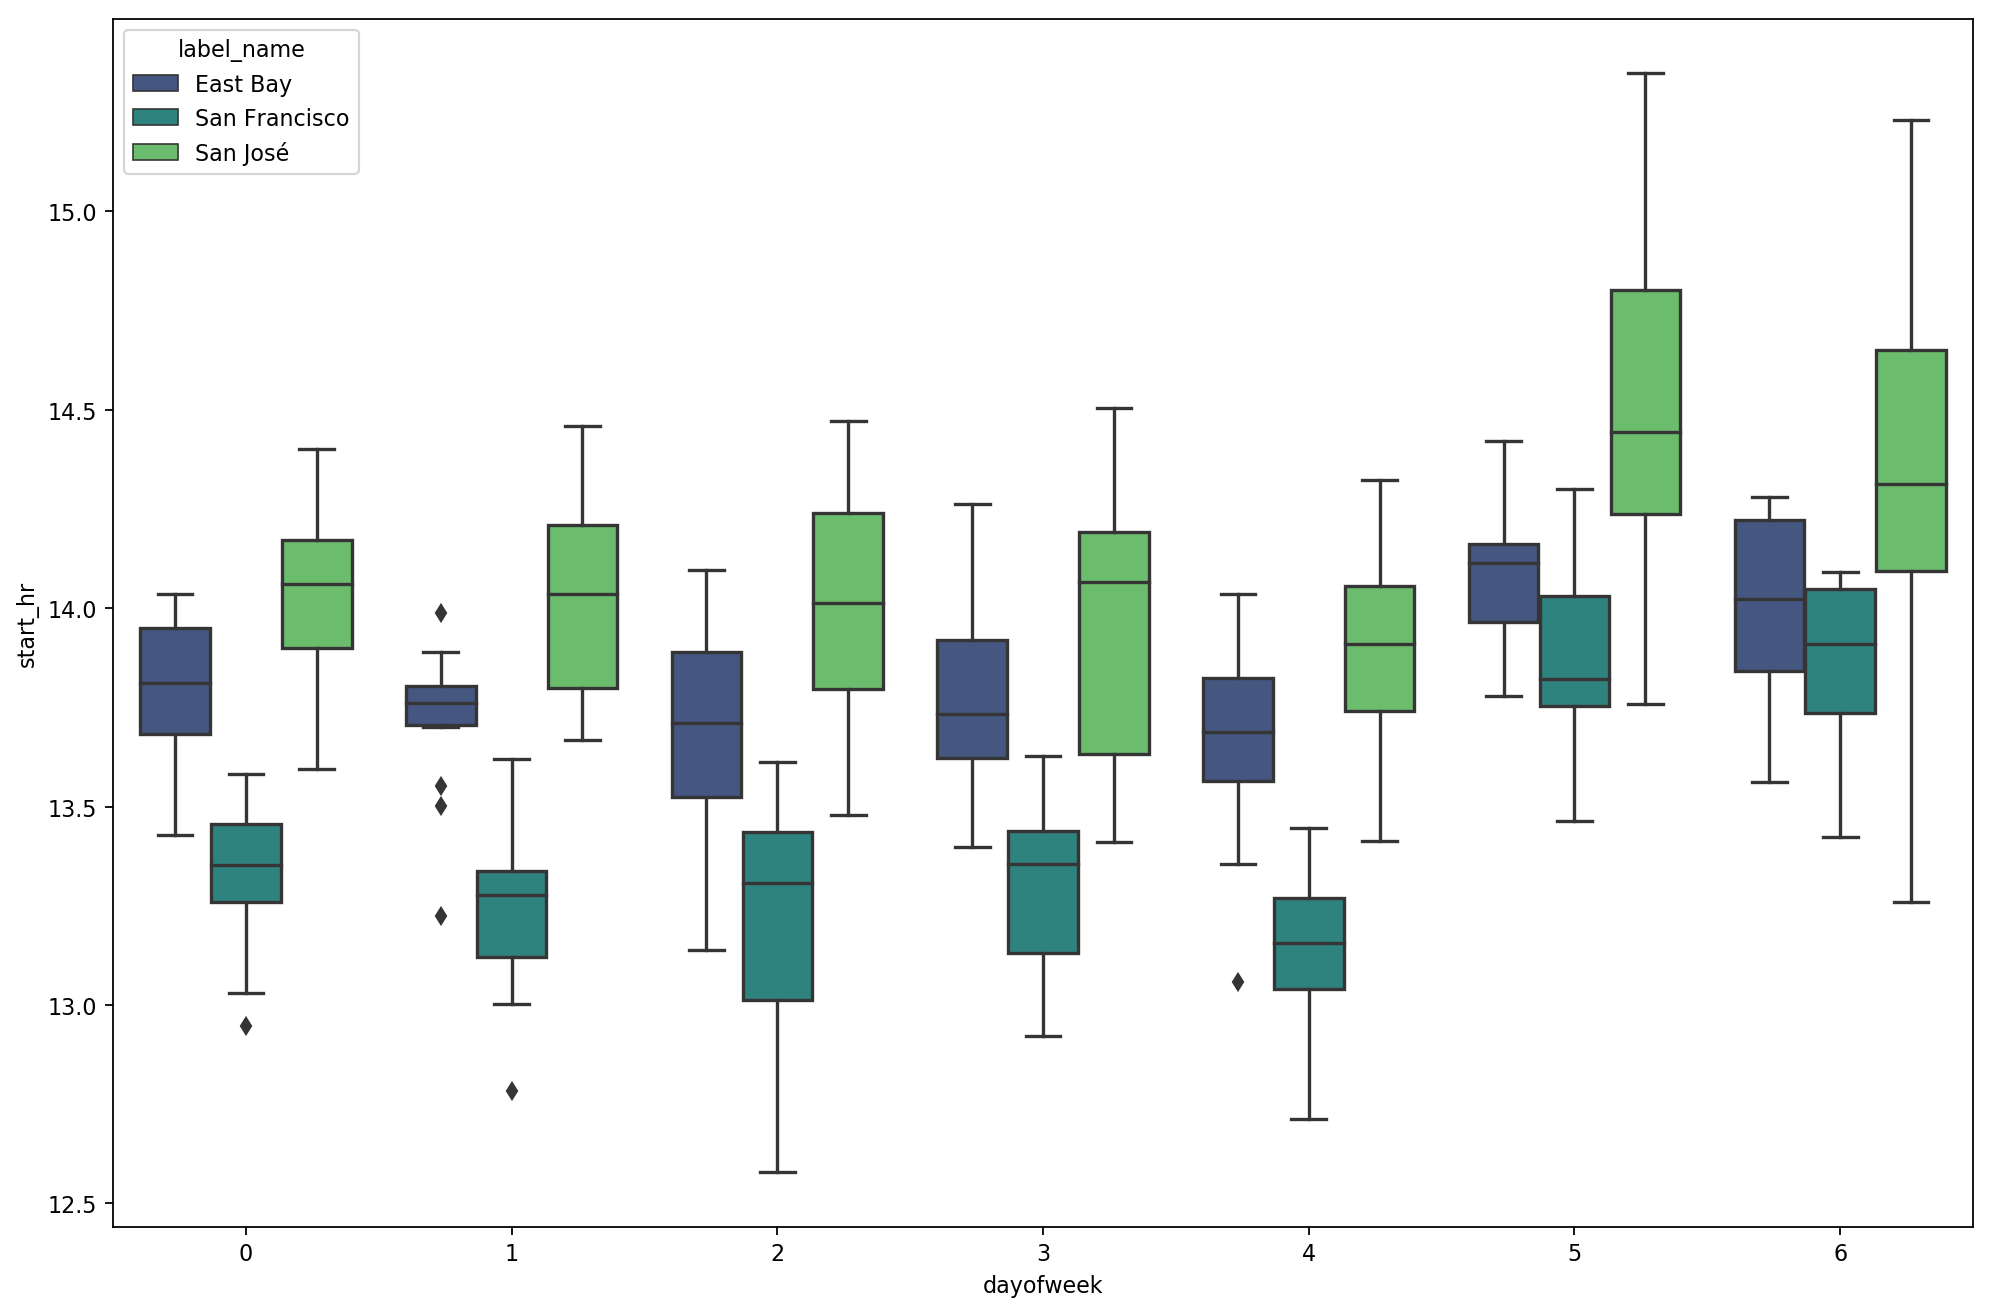

In [381]:
fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "dayofweek", y = "start_hr", data = df.groupby(["dayofweek", "month_year", "label_name"], as_index = False).mean(), palette = "viridis", hue = "label_name")

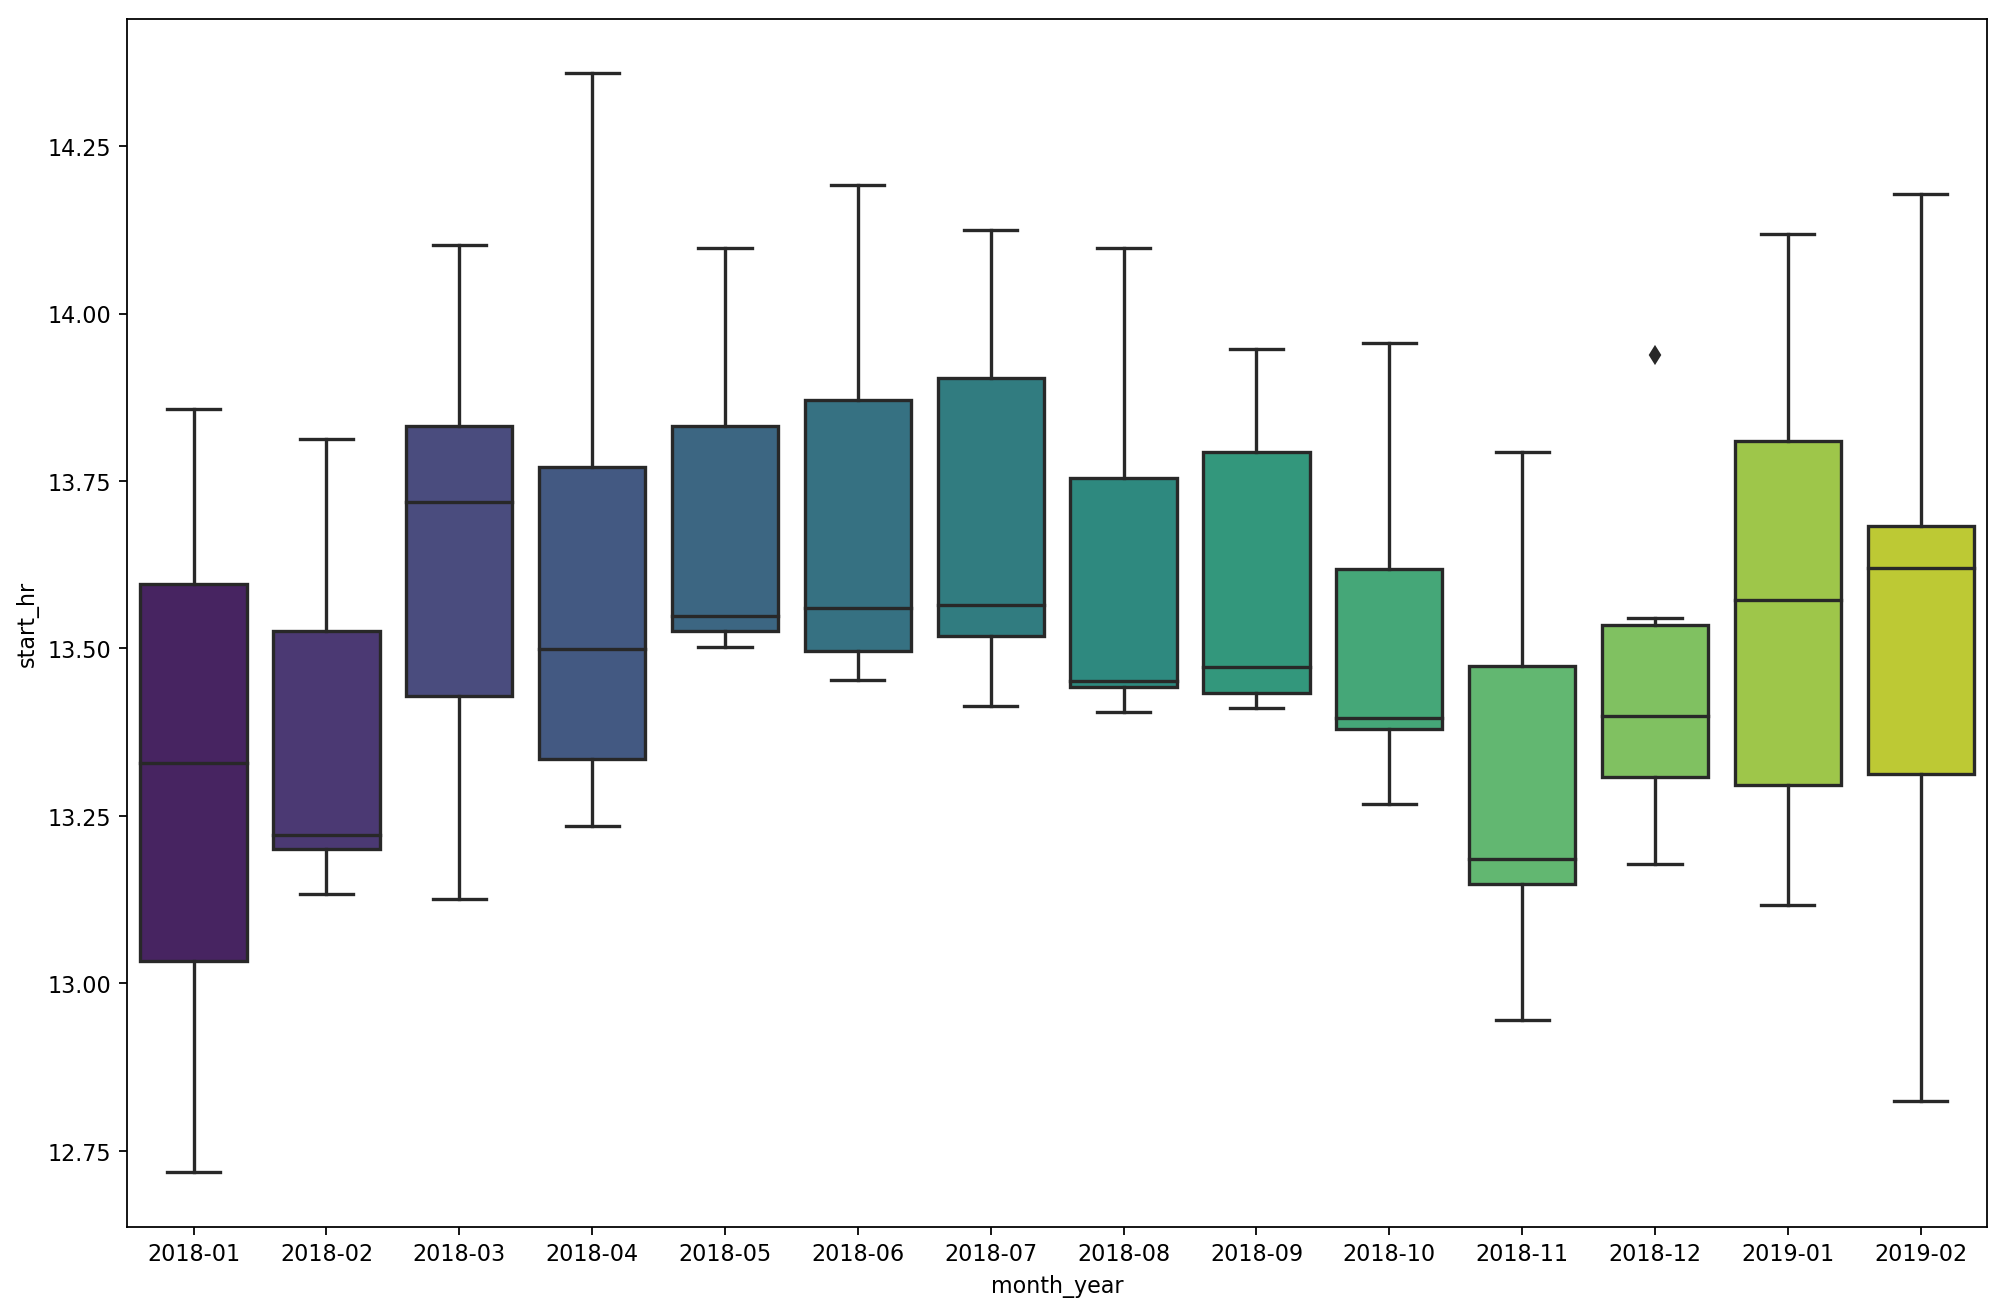

In [382]:
fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "month_year", y = "start_hr", data = df.groupby(["month_year","dayofweek"], as_index = False).mean(), palette = "viridis")


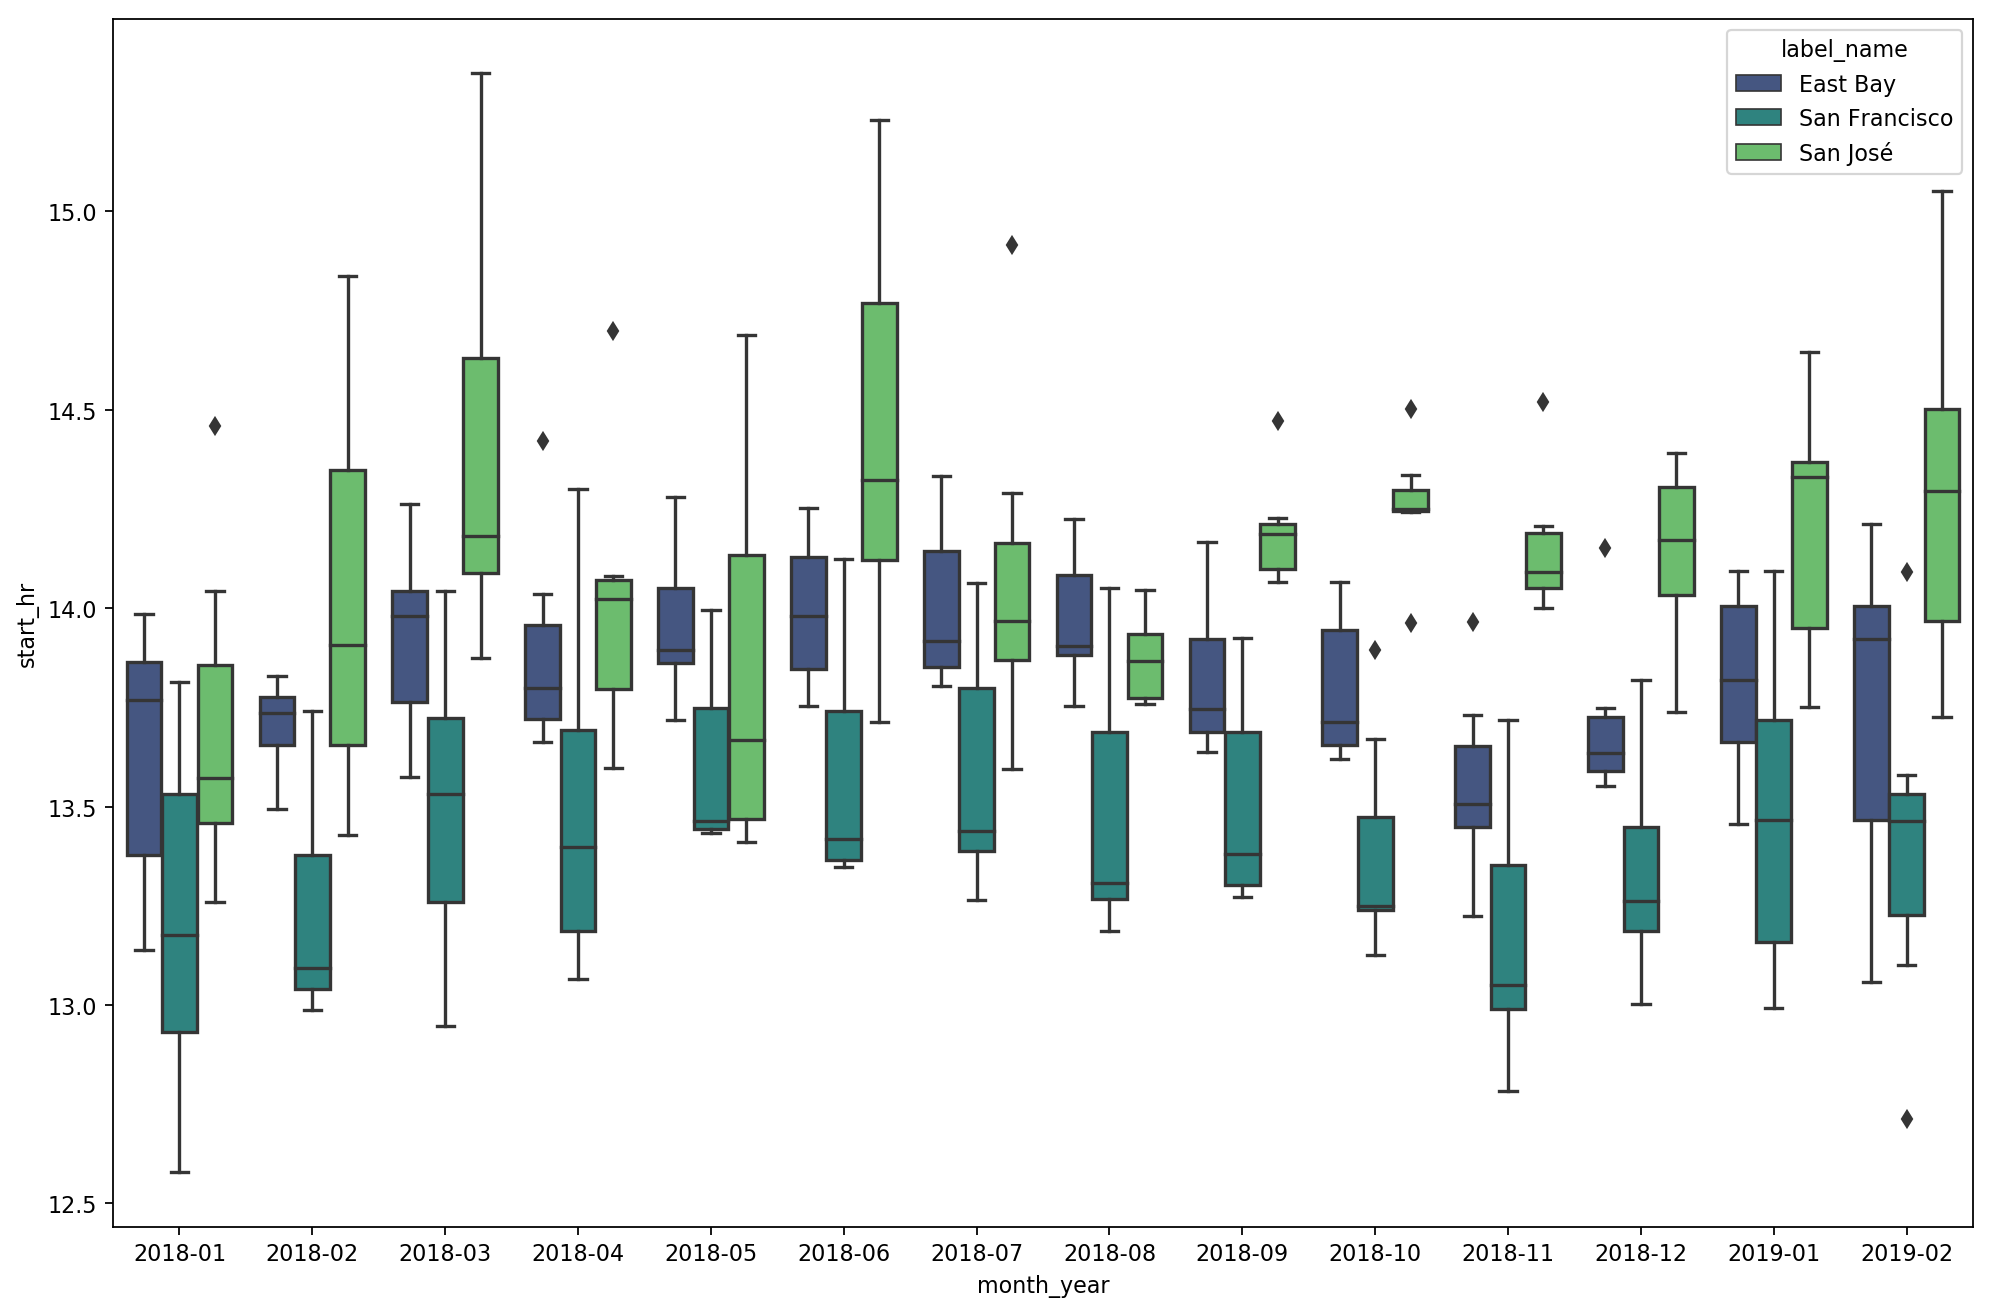

In [383]:
fig, ax = plt.subplots(figsize = (15,10), dpi = 80)
sns.boxplot(x = "month_year", y = "start_hr", data = df.groupby(["month_year","dayofweek", "label_name"], as_index = False).mean(), palette = "viridis", hue = "label_name")

<a id='multi'></a>
### Multivariate Exploration
> Relationships

In [384]:
df_station_names.head()

,id,station_name,station_latitude,station_longitude,new_id,label,label_name
0,10,Washington St at Kearny St,37.795393,-122.404770,10_0,2,San Francisco
1,100,Bryant St at 15th St,37.767100,-122.410662,100_0,2,San Francisco
2,101,San Bruno Ave at 16th St,37.766008,-122.405677,101_0,2,San Francisco
3,101,15th St at Potrero Ave,37.767079,-122.407359,101_1,2,San Francisco
5,102,Irwin St at 8th St,37.766883,-122.399579,102_0,2,San Francisco


In [385]:
df_trips = df[["start_station_latitude", "start_station_longitude",  "end_station_latitude", "end_station_longitude","start_station_id_new", "end_station_id_new"]].copy()

In [386]:
df_trips["cnt"] = 1

In [387]:
df_trips_grp = df_trips.groupby([x for x in df_trips.columns[:-1]], as_index = False).sum().sort_values("cnt", ascending = False)

In [388]:
df_trips_grp.head()

,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id_new,end_station_id_new,cnt
25841,37.795392,-122.394203,37.804770,-122.403234,15_0,6_0,8352
28155,37.804770,-122.403234,37.794130,-122.394430,6_0,16_0,5403
16138,37.775880,-122.393170,37.795392,-122.394203,81_0,15_0,5238
29022,37.808894,-122.256460,37.809013,-122.268247,196_0,182_0,4607
29136,37.809013,-122.268247,37.808894,-122.256460,182_0,196_0,4355


In [389]:
df_trips_grp.to_csv("grps.csv", index = False)

![San Francisco Trips with more than 1000 trips](Images/san_francisco_1000.png)
![East Bay Trips with more than 500 trips](Images/east_bay_500.png)
![San Jose Trips with more than 200 trips](Images/san_jose_200.png)

<a id='conclusion'></a>
## Summary and Conclusions

**Discussed questions:**
><ol>
>    <li><p><b>Question</b></p></li>
> Answer 
>    <li><p><b>Question</b></p></li>
> Answer
></ol>

**Limitations due to the cleaning process in the used datasets:**

><ol>
    ><li><p>Describing limitations to the original dataset</li>
></ol>

**Summary**
><ol>
>  Summary and Conclusions
</ol>